## towards_few_shot_learning
Jupyter notebook with some steps towards few shot learning

We run this jupyter notebook within conda and have installed cupy (using conda) and emnist (using pip).

We start defining some functions for later use. They are code folded here to keep the notebook readable.

In [1]:
%%writefile _code_.py 
# uncomment line before to run in jupyter notebook with command after constant definition


NN2_file_identifier = '_' + str(do_batch_training) + '_' + str(hidden_size) # used for the pickle file to reload pretrained files with different parameters

if use_bias:
    NN2_file_identifier += 'b_'
if do_pm:
    NN2_file_identifier += 'pm'
    
if few_shot_more_at_once != 1:
    print('Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!')
if load_mnist:
    print('labels (last two are used for few_shot)', all_labels)
    
#np.seterr(under='ignore', over='ignore')

def sigmoid(x):
    if do_pm:
        return np.tanh(x)
    xx = scale_sigmoid * (x - shift_sigmoid)
    return 1 / (1 + np.exp(-xx)) #* 2 -1

def sigmoid_derivative(x):
    if do_pm:
        return 1-np.tanh(x)**2
    xx = scale_sigmoid * (x - shift_sigmoid)
    return scale_sigmoid * (np.exp(-xx) / (np.exp(-xx) + 1) ** 2)

def transform_01_mp(x):
    return 2*x - 1

def run_load_mnist(show_msg = True, use_test = False, limit_labels = None, only_load_num = None):
    #global inputs, outputs, bbs
    # simelar to https://www.python-course.eu/neural_network_mnist.php
    #image_size = 28 # width and length
    #no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
    #image_pixels = image_size * image_size
    if not load_mnist:
        print('This should not happen!!')
    data_path = "test_few_shot/data/mnist/" # makes it possible to use kernel from jupyter notebook
    
    # speedup loading
    fac = 0.99 / 255
    if not use_emnist:
        try:
            with open(data_path + "pickled_mnist.pkl", "br") as fh:
                (train_data, test_data) = pickle.load(fh)
        except:
            train_data = np.loadtxt(data_path + "mnist_train.csv", 
                                    delimiter=",")
            test_data = np.loadtxt(data_path + "mnist_test.csv", 
                               delimiter=",") 
            with open(data_path + "pickled_mnist.pkl", "bw") as fh:
                pickle.dump((train_data, test_data), fh)
                
        
        if use_test:
            used_imgs = np_array(test_data[:, 1:]) * fac + 0.01
            dataset_name = 'Test dataset'
            used_labels = np_array(test_data[:, :1])
        else:
            used_imgs = np_array(train_data[:, 1:]) * fac + 0.01
            dataset_name = 'Train dataset'
            used_labels = np_array(train_data[:, :1])
    else:
        if use_test:
            dataset_name = 'Test dataset'
            (used_imgs, used_labels) = extract_test_samples('digits')
        else:
            dataset_name = 'Train dataset'
            (used_imgs, used_labels) = extract_training_samples('digits')
        used_imgs = np_array(used_imgs.reshape(-1, 28*28)) * fac + 0.01
        used_labels = used_labels.reshape(-1,1)
        
    if limit_labels is not None:
        new_imgs = []
        new_labels = []
        for i in range(len(used_labels)):
            if int(used_labels[i][0]) in limit_labels:
                new_imgs.append(used_imgs[i].tolist())
                new_labels.append(used_labels[i].tolist())
                if only_load_num is not None and len(new_labels) >= only_load_num:
                    break
        used_imgs = np_array(new_imgs)
        used_labels = np_array(new_labels)
    
    
    if num_outputs == 1:
        used_labels = np.around(1 - np.sign(np.abs(used_labels - label_to_one)))
    elif num_outputs == 10:
        label_transform = np.zeros((10, 10), int)
        np.fill_diagonal(label_transform, 1)
        label_transform = label_transform.tolist()
        used_labels = [label_transform[int(np.around(x[0]))] for x in used_labels]
        used_labels = np_array(used_labels)
#        raise Exception('not yet implementd')
    else:
        raise Exception('not yet implementd')

    inputs = used_imgs[:first_n_to_use]     
    outputs = used_labels[:first_n_to_use]
    bbs = ''
    for l in np.around(outputs):
        bbs += str(int(l[0]))
    if show_msg:
        if num_outputs == 10:
            if verbose > 0:
                print('loaded mnist', dataset_name,' with 10 labels', limit_labels)
        else:
            print('loaded mnist', dataset_name,' with output labels ',label_to_one,' resulting in learning labels', bbs[:10], '....')
    if len(bbs) > 50:
        bbs = 'to long to plot'
    if do_pm:
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)
    return (inputs, outputs, bbs)


if load_mnist:
    (inputs, outputs, bbs) = run_load_mnist()
else:
    if do_pm: # prepare the fixed inputs, load_mnist does it in the function
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)




vertical_distance_between_layers = 6
horizontal_distance_between_neurons = 2
neuron_radius = 0.5
neuron_scale_line = 2.0
number_of_neurons_in_widest_layer = 4
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, v):
        if v > 0:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='green', linewidth = 3)
        else:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='gray', linewidth = 3)
        pyplot.gca().add_patch(circle)

class Layer():
    def __init__(self, network, number_of_neurons, weights, bias, values, slow_learning):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.weights = weights
        if weights is not None:
            self.stability = np.zeros(weights.shape)
        self.drop_weights = None
        self.bias = bias
        self.values = values
        self.slow_learning = slow_learning

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, linewidth, graylevel = None, usage = None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        if graylevel is None:
            nr = neuron_radius * neuron_scale_line
        else:
            nr = neuron_radius * 1.4
        x_adjustment = nr * sin(angle)
        y_adjustment = nr * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        if linewidth > 0:
            c = 'green'
        else:
            c = 'red'
        
        lw = linewidth * scale_linewidth
        if graylevel is not None:
            #graylevel = (graylevel +1)/2
            if graylevel < 0: graylevel = 0
            if graylevel > 1: graylevel = 1
            c = (0, 0, 1, graylevel)
            lw = linewidth
        if usage is not None:
            #graylevel = (graylevel +1)/2
            if usage < 0: usage = 0
            if usage > 1: usage = 1
            c = (1, 1- usage / 3, 1 - usage)
            lw = linewidth
            
        line = pyplot.Line2D(line_x_data, line_y_data, linewidth=np.abs(lw), color = c)
        pyplot.gca().add_line(line)

    def draw(self, usage):
        for this_layer_neuron_index in range(len(self.neurons)):
            neuron = self.neurons[this_layer_neuron_index]
            neuron.draw(round(self.values[this_layer_neuron_index]))
            if self.previous_layer:
                for previous_layer_neuron_index in range(len(self.previous_layer.neurons)):
                    previous_layer_neuron = self.previous_layer.neurons[previous_layer_neuron_index]
                    weight = self.previous_layer.weights[previous_layer_neuron_index, this_layer_neuron_index]
                    stability = self.previous_layer.stability[previous_layer_neuron_index, this_layer_neuron_index]
                    used = 0
                    if weight > 0:
                        used = self.previous_layer.values[previous_layer_neuron_index] * self.values[this_layer_neuron_index]
                    else:
                        used = self.previous_layer.values[previous_layer_neuron_index] * (1 - self.values[this_layer_neuron_index])
                                                              
                    #print("connection %2d %2d    %6.3f    %6.3f    %6.3f    %6.3f used: %6.3f" % (previous_layer_neuron_index, this_layer_neuron_index, self.previous_layer.values[previous_layer_neuron_index], self.values[this_layer_neuron_index], weight, stability, used))
                    if usage:
                        self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, usage = used)
                    else:
                        if use_stability:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, stability)
                        else:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, 0.3)
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weight)
                    
    def backward(self, post_error):
        
        error_between_sigmoid_and_full = post_error * sigmoid_derivative(self.between_full_sigmoid) # post layer may be wrong!!!!!!!!
        
        pre_error = np.dot(error_between_sigmoid_and_full, self.weights.T) 
        d_weights = np.dot(self.values.T, error_between_sigmoid_and_full) / len(post_error) # scale learning rate per input
        d_bias = np.sum(error_between_sigmoid_and_full, axis = 0) /len(post_error) 
        
        self.change_weights(d_weights, d_bias)
        return pre_error
    
    def forward(self, pre_layer, dostability):
        self.values = pre_layer
        if self.weights is None:
            return pre_layer
        self.between_full_sigmoid = np.dot(pre_layer, self.weights)
        if use_bias:
            self.between_full_sigmoid += self.bias
        post_layer = sigmoid(self.between_full_sigmoid)
        if dostability:
            post_l = np.expand_dims(post_layer,-2)
            pre_l_2d = np.expand_dims(pre_layer, -2)
            
            # this is necessary if 0 1 neurons are used, not if -1 1 ones
            post_l = transform_01_mp(post_l)
            pre_l = transform_01_mp(pre_l_2d)
            
            #print(np.transpose(post_l[2]), pre_l[2])
            stability = (np.tanh(scale_for_neuron_diff * np.matmul(pre_l.swapaxes(-1,-2), post_l)) * np.tanh(self.weights / weight_tanh_scale) + 1) / 2
            stability = pre_l_2d.swapaxes(-1,-2) * stability # only active inputs count for stability
            if len(stability.shape) == 2:
                stability = np.expand_dims(stability, 0) # handle single and multi inputs
            stability = np.sum(stability, axis = 0) / len(stability)
            #print(stability)
            #self.stability = stability_mean * pre_layer.T * stability + (1 - stability_mean * pre_layer.T) * self.stability
            self.stability = stability_mean * stability + (1 - stability_mean) * self.stability
        return post_layer
        
    def change_weights(self, d_weights, d_bias):
        if use_stability:
            direct = 1 - self.stability
        else:
            direct = np_array([1])
        #print('direct', direct)
        self.weights += d_weights * lr * direct * self.slow_learning
        self.bias +=  d_bias *lr * np.sum(direct, axis = 0) * self.slow_learning
        if clip_weights is not None:
            np.clip(self.weights, -clip_weights, clip_weights, self.weights)
        if clip_bias is not None:
            np.clip(self.bias, -clip_bias, clip_bias, self.bias)
        if self.drop_weights is not None:
            self.weights *= self.drop_weights
            
        
class DrawNet():
    def __init__(self):
        self.layers = []
        self.epoch_list = []
        self.error_history = []
        self.error = None

        # batch handling, as cuda might not have enough memory to hold all inputs
        self.all_input = None
        self.all_output = None
        self.batch_pos = None
        self.batch_size = None
        
    def add_layer(self, number_of_neurons, weights, bias, values, slow_learning = 1):
        layer = Layer(self, number_of_neurons, weights, bias, values, slow_learning)
        self.layers.append(layer)
    
    def forward(self, dostability = False):
        outp = self.layers[0].values
        for layer in self.layers:
            outp = layer.forward(outp, dostability)
        #self.layers[-1].values = outp
        self.error = self.y - self.layers[-1].values
        if check_for_nan:
            if np.any(np.isnan(self.error)):
                print('nan')
        return outp
    
    def backward(self):
        #self.error = pre_error = self.y - self.layers[-1].values # forward must be called first anyway
        pre_error = self.error
        for layer in reversed(self.layers[:-1]):
            #print('pre_error', pre_error.flatten())
            pre_error = layer.backward(pre_error)
        return pre_error
    
    def train(self, epochs=1000):
        self.epochs = epochs # just to know how it was trained for output
        self.error_history = []
        self.epoch_list = []
        ttt = tqdm(range(epochs), mininterval = 10, disable=disable_progressbar)
        for epoch in ttt:
            # flow forward and produce an output
            self.forward(True)
            # go back though the network to make corrections based on the output
            self.backward()
            self.next_batch()
            # keep track of the error history over each epoch
            err = np.sum(np.square(self.error))
            self.error_history.append(err)
            self.epoch_list.append(epoch)
            if self.batch_size is not None:
                ttt.set_description("Err %6.3f" % (err/self.batch_size), refresh=False)
            else:
                ttt.set_description("Err %6.3f" % (err), refresh=False)
        self.forward() # to update the output layer, if one needs to print infos...
    
    def plot_train_history(self):
        pyplot.figure(figsize=(15,5))
        pyplot.plot(self.epoch_list, self.error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.show()
        pyplot.close()

    def set_input(self, new_input, new_output, batch_size = None):
        self.all_input = new_input
        self.all_output = new_output
        self.batch_size = batch_size
        if batch_size is not None:
            self.layers[0].values = new_input[:batch_size]
            self.y = new_output[:batch_size]
        else:
            self.layers[0].values = new_input
            self.y = new_output
        self.batch_pos = self.batch_size
        
    def next_batch(self):
        if self.batch_size is not None:
            self.layers[0].values = self.all_input[self.batch_pos : self.batch_pos+self.batch_size]
            self.y = self.all_output[self.batch_pos : self.batch_pos+self.batch_size]
            # if len(self.y) == 0:
            #     self.batch_pos = self.batch_size
            #     self.layers[0].values = self.all_input[:self.batch_pos]
            #     self.y = self.all_output[:self.batch_pos]
            if len(self.y) < self.batch_size:
                self.batch_pos = self.batch_size - len(self.y)
                self.layers[0].values = np.concatenate((self.layers[0].values, self.all_input[:self.batch_pos]))
                self.y = np.concatenate((self.y, self.all_output[:self.batch_pos]))
            else:
                self.batch_pos += self.batch_size
            
            
    def draw(self, result = None, usage = False, display_title = None):
        c = 0
        for layer in self.layers:
            c+=1
            #print('layer',c)
            layer.draw(usage)
        if result is not None:
            if result[0] > 0:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='green', linewidth = 3)
            else:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='gray', linewidth = 3)
            pyplot.gca().add_patch(circle)
        pyplot.axis('scaled')
        if display_title is not None:
            pyplot.title(display_title)
        pyplot.show()
        pyplot.close()
        
    def predict(self, new_input, oo = None, drawit=False, usage = False, display_title = None):
        self.set_input(new_input, oo)
        prediction = self.forward(False)
        if oo is not None:
            self.error = oo - prediction
        if drawit:
            self.draw(oo, usage, display_title)
        return prediction
    
    def count_parameters(self):
        count = 0
        drops = 0
        for l in self.layers:
            if l.weights is not None:
                count += l.weights.size
                if use_bias:
                    count += l.bias.size
                if l.drop_weights is not None:
                    drops += l.drop_weights.size - np.sum(l.drop_weights)
        return count, drops

def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    if two_hidden_layers:
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    if verbose > 0:
        print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

def bbs_to_output(x):
    res = []
    for c in x:
        res.append([int(c)])
    return np_array(res)

def creat_output_from_int(bb, length=8):
    bbs = ('{0:0'+str(length)+'b}').format(bb)
    output = bbs_to_output(bbs)
    if do_pm:
        output = transform_01_mp(output)
    return output, bbs

if do_check_all > 0:
    # checks all possible input output combinations to check, if the neural net is capable of learning in
    notok = 0
    sum_error_history = None
    for bb in range(0, check_output_limit):
        # bbs = '{0:08b}'.format(bb)
        # for l in range(len(bbs)): 
        #     if bbs[l] =='1':
        #         outputs[l] = 1
        #     else:
        #         outputs[l] = 0
        (outputs, bbs) = creat_output_from_int(bb)
        NN2 = setup_net()
        NN2.train(do_check_all)
        err = np.sum(NN2.error**2)
        ok = '*'
        if err < 0.2: 
            ok = ' '
        else:
            notok += 1
        if sum_error_history is None:
            sum_error_history = np_array(NN2.error_history)
        else:
            sum_error_history += np_array(NN2.error_history)
        if verbose > 1:
            #print(bbs, '{0:5.3f}'.format(float(err)),ok,notok)
            pyplot.figure(figsize=(15,5))
            pyplot.plot(NN2.epoch_list, NN2.error_history)
            pyplot.xlabel('Epoch')
            pyplot.ylabel('Error')
            pyplot.title(bbs)
            pyplot.show()
            pyplot.close()
        print("Label %8s error %6.3f" % (bbs, err), ok, "total fails yet:", notok)
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (sum_error_history / check_output_limit).tolist())
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Error')
    pyplot.title('sum error history')
    pyplot.show()
    pyplot.close()


        

# train neural network
#NN2.train()

#testing single inputs for few shot learning
askuser = True
stopit = False
few_shot = (multi_test > 0)


#NN2 = setup_net()
sum_error_history = None
if do_batch_training >= 0:
    loaded_pretrained = False
    if try_load_pretrained:
        try:
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "br") as fh:
                NN2 = pickle.load(fh)
            num_params, count_drops = NN2.count_parameters()
            print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
            loaded_pretrained = True
            print('loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        except Exception as e:
            print('loading pretrained NN2 failed:', e)
            NN2 = setup_net()
    else:
        NN2 = setup_net()    
    if try_mnist_few_shot > 0:
        if loaded_pretrained:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2], only_load_num=few_shot_fast_load_num)
        else:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2])
    NN2.set_input(inputs, outputs, batch_size=1000)
    if not loaded_pretrained:
        try:
            print('start', datetime.now().strftime("%H:%M:%S"))
            NN2.train(do_batch_training)
            print('end', datetime.now().strftime("%H:%M:%S"))
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "bw") as fh:
                pickle.dump(NN2, fh)
        except KeyboardInterrupt:
            print('Interrupted by keyboard')
    NN2.forward() # most of the time, this should result in an OK net, but not safe, as train could be interrupted at any position
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (np_array(NN2.error_history) / len(NN2.error)).tolist())
    pyplot.xlabel('Batches')
    pyplot.ylabel('Error')
    pyplot.title('trained with epochs: ' + str(NN2.epochs))
    pyplot.show()
    pyplot.close()
    
    if num_outputs == 1:
        print('train', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('train', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('test ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('test', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    print('Testing if new lables were not learned !!!!!!!!!')
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    # now try a few shot learning for some steps
    # load with labels [8,9] and train every to a measure
    #
    # criteria label correct: (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0] true
    # distance to second largest label
    # biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
    # ratio = biggest_two[-1] / [-2] > threshold
    
    # max_iter is the maximal number of try's to optimize one data point in few_shot
    pos_1 = 0
    pos_2 = 0
    try:
        print('few shot accuracy results')
        print('shot     try       old labels            new labels  new labels (forced)              over all')
        for i_shot in range(try_mnist_few_shot): # some shots
            if change_first_layers_slow_learning is not None:
                for l in range(len(change_first_layers_slow_learning)):
                    before = NN2.layers[l].slow_learning
                    NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
                    if verbose > 0:
                        print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
            before = lr
            lr = lr_few_shot
            if verbose > 0:
                print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
            (inputs, outputs, bbs) = run_load_mnist(use_test = False)
            few1 = all_labels[-2]
            few2 = all_labels[-1]
            ok1 = False
            while not ok1:
                while outputs[pos_1].argmax() != few1:
                    pos_1 += 1
                inp_1 = inputs[pos_1:pos_1+few_shot_more_at_once]
                outp_1 = outputs[pos_1:pos_1+few_shot_more_at_once]
                pos_1 += few_shot_more_at_once # prepare the next shot
                ok1 = True
                if check_wrong:
                    for ii in range(1, few_shot_more_at_once):
                        if outp_1[ii].argmax() == few2:
                            ok1 = False
            ok2 = False
            while not ok2:
                while outputs[pos_2].argmax() != few2:
                    pos_2 += 1
                inp_2 = inputs[pos_2:pos_2+few_shot_more_at_once]
                outp_2 = outputs[pos_2:pos_2+few_shot_more_at_once]
                pos_2 += few_shot_more_at_once
                ok2 = True
                if check_wrong:
                    for ii in range(1, few_shot_more_at_once):
                        if outp_2[ii].argmax() == few1:
                            ok1 = False
            for m in range(use_every_shot_n_times):
                for (inp,outp) in [(inp_1,outp_1), (inp_2,outp_2)]:
                    if verbose > 0:
                        print('start training', outp)
                    epoch = 0
                    NN2.set_input(inp, outp)
                    while epoch < few_shot_max_try:
                        NN2.forward()
                        NN2.backward()
                        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
                        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0]:
                            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
                            if do_pm:
                                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
                            else:
                                ratio = biggest_two[-1] / biggest_two[-2]
                            if verbose > 0:
                                print(biggest_two, ratio)
                            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                                break
                if verbose > 0:
                    print('Results after few shot', i_shot + 1, 'used the ', m + 1, '. time')
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_old_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_new_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                # here only the few_shot trained lables are considdered
                res_values = NN2.layers[-1].values
                mask = [0] * len(all_labels)
                for l in all_labels[-2:]:
                    mask[l] = 1
                mask = np_array([mask])
                res_values = res_values * mask
                # deb = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum())
                acc_only_new_labels_forced = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('using only the few shot trained labels for possible output of neural net')
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(res_values.argmax(axis = 1) == few1), 'few2:', np.sum(res_values.argmax(axis = 1) == few2), 'correct', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                
                
                (inputs, outputs, bbs) = run_load_mnist(use_test = True, only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_overall_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                print("%4d    %3d           %7.3f               %7.3f              %7.3f               %7.3f" % (i_shot + 1, m + 1, acc_only_old_labels, acc_only_new_labels, acc_only_new_labels_forced, acc_only_overall_labels))
    except KeyboardInterrupt:
        print('Interrupted')
else:
    NN2 = setup_net()

multi = 0
while multi <= multi_test:
    # tries to do a few shot learning multiple times and checks, how fast it is learned
    # initializes the last layer weights when the label is changed
    pos_under_few_shot = 0
    if test_from_random_input:
        inp = []
        while len(inp) < 8:
            r = random.randrange(0,2**i_bits-1)
            if r not in inp:
                inp.append(r)
        inputs = []
        for bb in inp:
            v= [0]*i_bits
            bbs = ('{0:0'+str(i_bits)+'b}').format(bb)
            for l in range(len(bbs)): 
                if bbs[l] =='1':
                    v[l] = 1
                else:
                    v[l] = 0
            inputs.append(v)
        inputs = np_array(inputs)
    if not load_mnist:
        (outputs, bbs) = creat_output_from_int(random.randrange(0,check_output_limit - 1)) # first output always 0, as sigmoid network is not capable of outputting 1 here
        disp_label = bbs
    else:
        label_to_one = random.randrange(0, 9) # change the label used
        run_load_mnist(False)
        disp_label = label_to_one
        
    # reset weights in the last layer
    NN2.layers[-2].weights = init_rand_ampl * np_array(np.random.rand(hidden_size, 1)- 0.5)
    NN2.layers[-2].bias = init_rand_ampl * np_array(np.random.rand(1)- 0.5)

    NN2.set_input(inputs, outputs)
    # used to reset whole NN every time
    #NN2 = setup_net()

    error_history = []
    epoch_list = []
    epoch = 0
    while epoch < max_iter:
        for i in range(len(inputs)):
            same = True
            first = True
            fl = 0
            while same:
                if not few_shot:
                    same = False
                if askuser and multi_test == 0:
                    same = True
                    NN2.predict(inputs[i], outputs[i], True, usage = False)
                    # t = '3' 
                    doask = True
                    while doask:
                        doask = False
                        t = input(str(i)+' '+str(NN2.error)+' (1: same, 2:next, 3:stop asking, 4:exit, 5:few_shot, 6: change max epoch num)?')
                        if t.isdigit():
                            t = int(t)
                            if t == 2:
                                same = False
                                break
                            if t == 3:
                                askuser = False
                                same = False
                            if t == 4:
                                stopit = True
                                break
                            if t == 5:
                                few_shot = True
                                askuser = False
                            if t == 6:
                                max_iter = int(input('change max epoch num ' + str(max_iter) + ' '))
                                doask = True
                NN2.set_input(inputs[i:i+1], outputs[i:i+1])
                NN2.forward(dostability = first)
                NN2.backward()
                first = False
                this_error = sum(np.square(NN2.error))
                if this_error[0] > few_shot_end:
                    pos_under_few_shot = epoch + 1
                if len(epoch_list) == 0 or (len(epoch_list) > 0 and epoch_list[-1] != epoch + i / len(inputs)):
                    epoch_list.append(epoch + i / len(inputs))
                    error_history.append(this_error)
                fl += 1
                if fl > few_shot_max_try:
                    break
                if few_shot:
                    if abs(NN2.error[0]) < few_shot_end:
                        break
            if stopit:
                break
        if stopit:
            break
        NN2.set_input(inputs, outputs)
        NN2.forward()
        err = outputs - NN2.layers[-1].values
        NN2.predict(inputs[0], outputs[0], multi_test == 0, display_title = str(epoch)+': '+'{0:6.3f}'.format(float(np.sum(err**2))))
        epoch += 1
    

    if multi_test == 0:
        for i in range(len(inputs)):
            print(NN2.predict(inputs[i], outputs[i], drawit= (multi_test > 0), usage = True), 'correct', outputs[i])
    
    # plot the error over the entire training duration
    if sum_error_history is None:
        sum_error_history = np_array(error_history)
    else:
        sum_error_history += np_array(error_history)
    if verbose > 0:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title(str(multi)+ ' ' + bbs)
        pyplot.show()
        pyplot.close()
    
    print("%3d Label %3s Error %6.3f     Ready %3d" % (multi, str(disp_label), np.sum(np_array(error_history[-8:])), pos_under_few_shot))
    multi += 1
if sum_error_history is not None:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, (sum_error_history / multi_test).tolist())
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title('sum error history')
        pyplot.show()
        pyplot.close()


Overwriting _code_.py


Here a set of constants are defined, which control the configuration of the test network. There are a number of constants, which are not important at the moment, as it the code is a playing tool.

In [38]:
#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 8
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.7 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 1


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!

try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 8

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [0], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = False
load_mnist = False

do_batch_training = 0
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 1 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]

disable_progressbar = True
# End of constant definitions

We define a input output combination, which should be learned

In [35]:
for i in range(len(outputs)):
    print(inputs[i][0], inputs[i][1], inputs[i][2], '-->', outputs[i])

0 0 0 --> [0]
0 0 1 --> [0]
0 1 0 --> [0]
0 1 1 --> [0]
1 0 0 --> [1]
1 0 1 --> [1]
1 1 0 --> [0]
1 1 1 --> [1]


Now let's test training the net and draw the result

In [36]:
NN2 = setup_net()
NN2.set_input(inputs, outputs)
NN2.train(3000)
NN2.plot_train_history()
NN2.set_input(inputs[5], outputs[5])
NN2.forward()
NN2.draw(outputs[5])

TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

Here you see propagating the input up to the output. The big circle around the output is the 'correct' answer, we trained for.
If one tries different input -> output relations it can be seen, that not all are trained correct every time. Here it starts to become interesting, as the training success depends on the random initialization of the weights within the layers. It might also be possible, that the network is not capable to learn the input output relation. For example we choose a network, which is not very powerfull, as it does not contain bias and uses sigmoid activation layers. If all inputs are 0 the output must be 0 therefore. We check all other input output combinations and see, that the network is capable of learning them:

In [101]:
lr = 2
hidden_size = 8
missed = 0
stats = {}
for k in range(8):
    stats[k] = 0
for i in range(128):
    for k in range(8):
        NN2 = setup_net()
        bbs = ('{0:0'+str(i_bits)+'b}').format(i)
        outputs = bbs_to_output(bbs)
        NN2.set_input(inputs, outputs)
        NN2.train(5000 * 2 ** k)
        errsum = np.sum(NN2.error**2)
        if errsum <= 0.25:
            break
    stats[k] += 1
    if errsum > 0.25:
        missed += 1
    print('%4d %8s %6.3f %3d %d' % (i, bbs, errsum, missed, k))
print('tried %4d  missed: %3d' % (i + 1, missed), stats)

   0 00000000  0.002   0 0
   1 00000001  0.016   0 0
   2 00000010  0.035   0 0
   3 00000011  0.012   0 0
   4 00000100  0.037   0 0
   5 00000101  0.010   0 0
   6 00000110  0.013   0 0
   7 00000111  0.021   0 0
   8 00001000  0.034   0 0
   9 00001001  0.013   0 1
  10 00001010  0.043   0 0
  11 00001011  0.024   0 0
  12 00001100  0.039   0 0
  13 00001101  0.017   0 0
  14 00001110  0.036   0 0
  15 00001111  0.030   0 0
  16 00010000  0.044   0 0
  17 00010001  0.009   0 0
  18 00010010  0.037   0 0
  19 00010011  0.008   0 0
  20 00010100  0.043   0 0
  21 00010101  0.018   0 0
  22 00010110  0.016   0 0
  23 00010111  0.009   0 0
  24 00011000  0.006   0 2
  25 00011001  0.018   0 1
  26 00011010  0.083   0 0
  27 00011011  0.059   0 0
  28 00011100  0.113   0 0
  29 00011101  0.011   0 0
  30 00011110  0.155   0 1
  31 00011111  0.029   0 0
  32 00100000  0.036   0 0
  33 00100001  0.027   0 0
  34 00100010  0.038   0 0
  35 00100011  0.020   0 0
  36 00100100  0.006   0 2
 

 From the list one can identify difficult combinations to train. If one runs them, sometimes it fails...

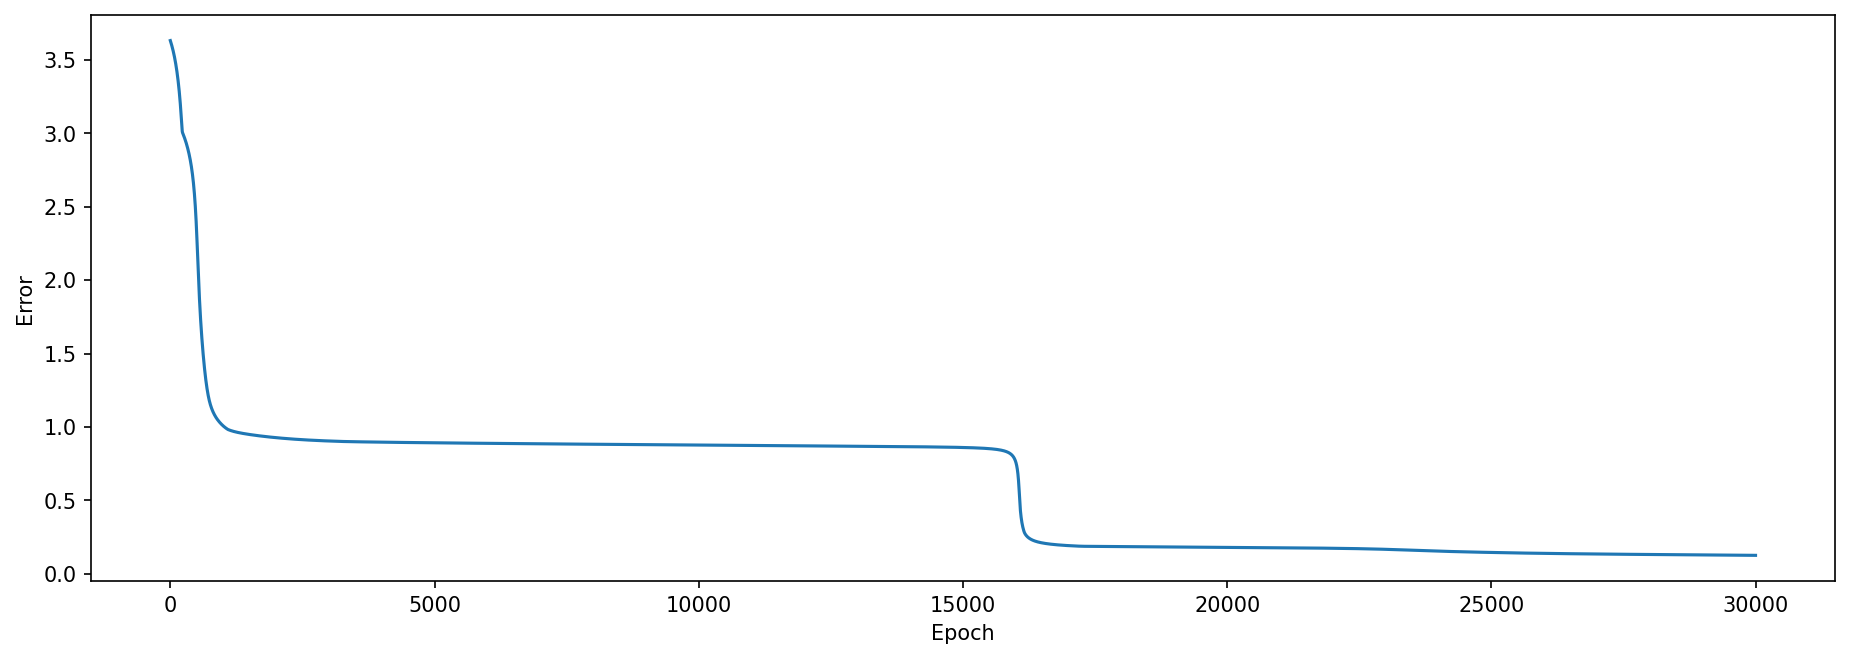

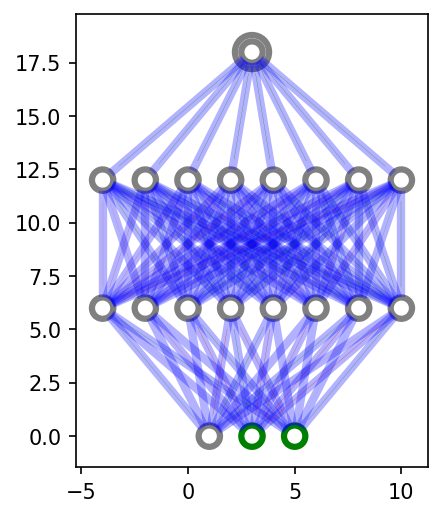

In [103]:
lr = 1
NN2 = setup_net()
outputs = bbs_to_output('01101100')
NN2.set_input(inputs, outputs)
NN2.train(30000)
NN2.plot_train_history()
i=3
NN2.set_input(inputs[i],outputs[i])
NN2.forward()
NN2.draw(outputs[i])

Now we will try so called few shot learning. As you can see from the training graph abough, usually the network uses every input output combination a very big number of times till the training is good. This is different from humans, which usualy learn a task with very few examples. We try this now

  0 Label 00100001 Error  1.501     Ready   1
  1 Label 01010010 Error  1.679     Ready   2
  2 Label 00000100 Error  0.396     Ready   1
  3 Label 00111100 Error  0.504     Ready   2
  4 Label 00010001 Error  0.268     Ready   2
  5 Label 01000011 Error  1.339     Ready   7
  6 Label 01100001 Error  1.701     Ready   1
  7 Label 00000000 Error  0.010     Ready   0
  8 Label 00101000 Error  1.147     Ready   1
  9 Label 00011110 Error  1.153     Ready   2
 10 Label 01110001 Error  0.209     Ready   1
 11 Label 00011111 Error  0.297     Ready   2
 12 Label 01011110 Error  0.307     Ready   3
 13 Label 01111001 Error  0.298     Ready   1
 14 Label 01000110 Error  0.292     Ready   5
 15 Label 00111111 Error  0.131     Ready   3
 16 Label 01001100 Error  0.125     Ready   3
 17 Label 01011111 Error  0.103     Ready   1
 18 Label 00001011 Error  0.024     Ready   3
 19 Label 00011100 Error  0.174     Ready   5
 20 Label 01110101 Error  0.091     Ready   2
 21 Label 00110101 Error  0.181   

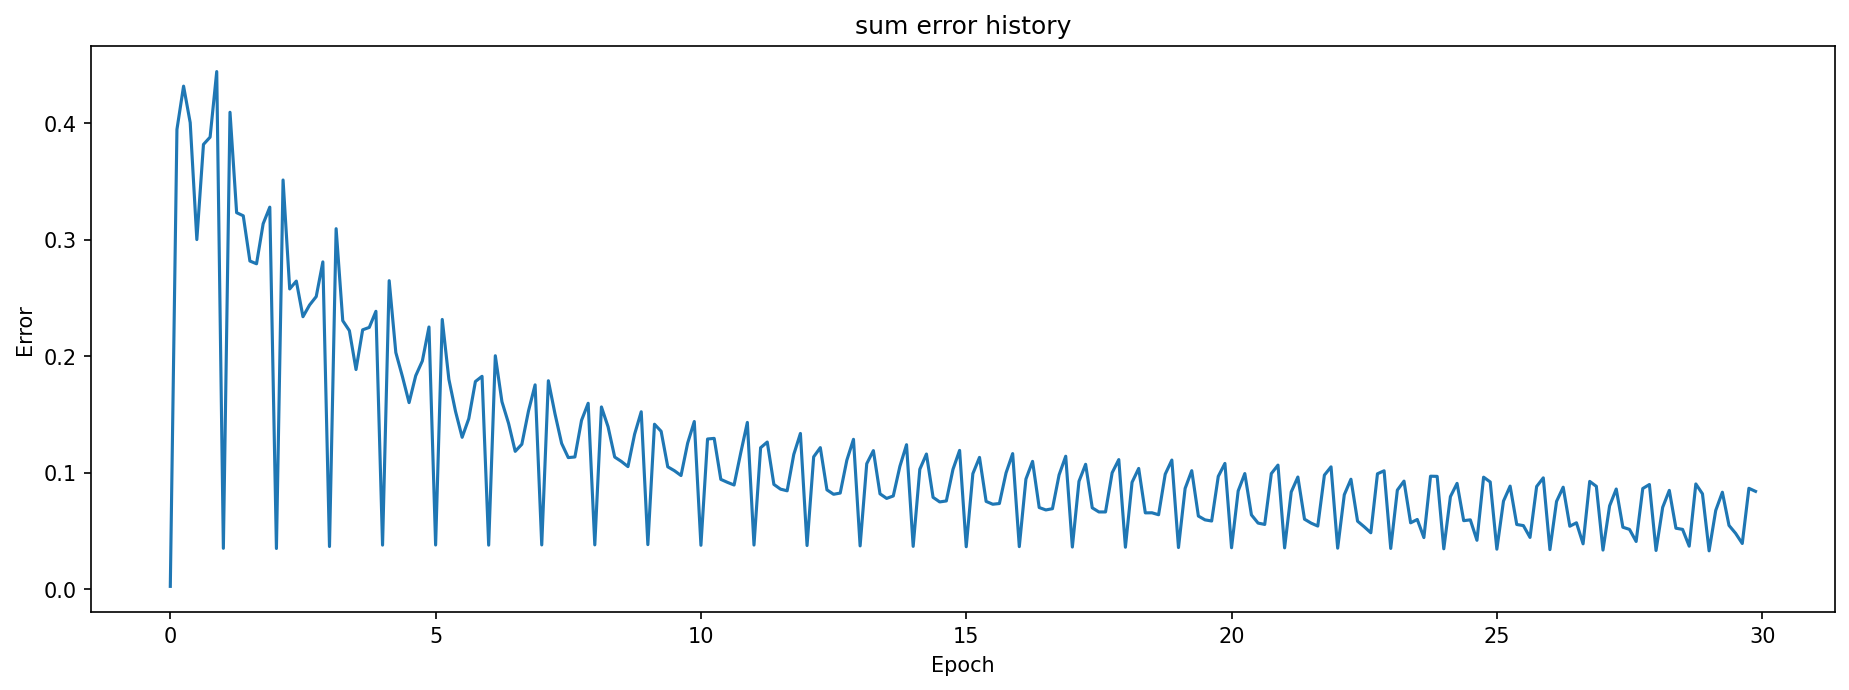

In [106]:
multi_test = 30 
%run -i _code_.py

as you can see, with seeing every data point only a small number of times, this trains the model. We use a very simple straight forward approach. With one data point we do a training up to a treshold, than we take the next data point. From the table you can see, that most of the time the training is successfull, but sometimes it is not.

In fact the training here is a little more improved: For every test we reinitialize the random weights of the last layer and train with a different randomly chosen output combination. We train the first layer with a slower learning rate, but this is not yet important. This simple examples work even without this additional improvments.

Now we will start using emnist data, which will result in few shot learning of handwritten digit recognition.

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  12960 dropped 0 real parameters 12960 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


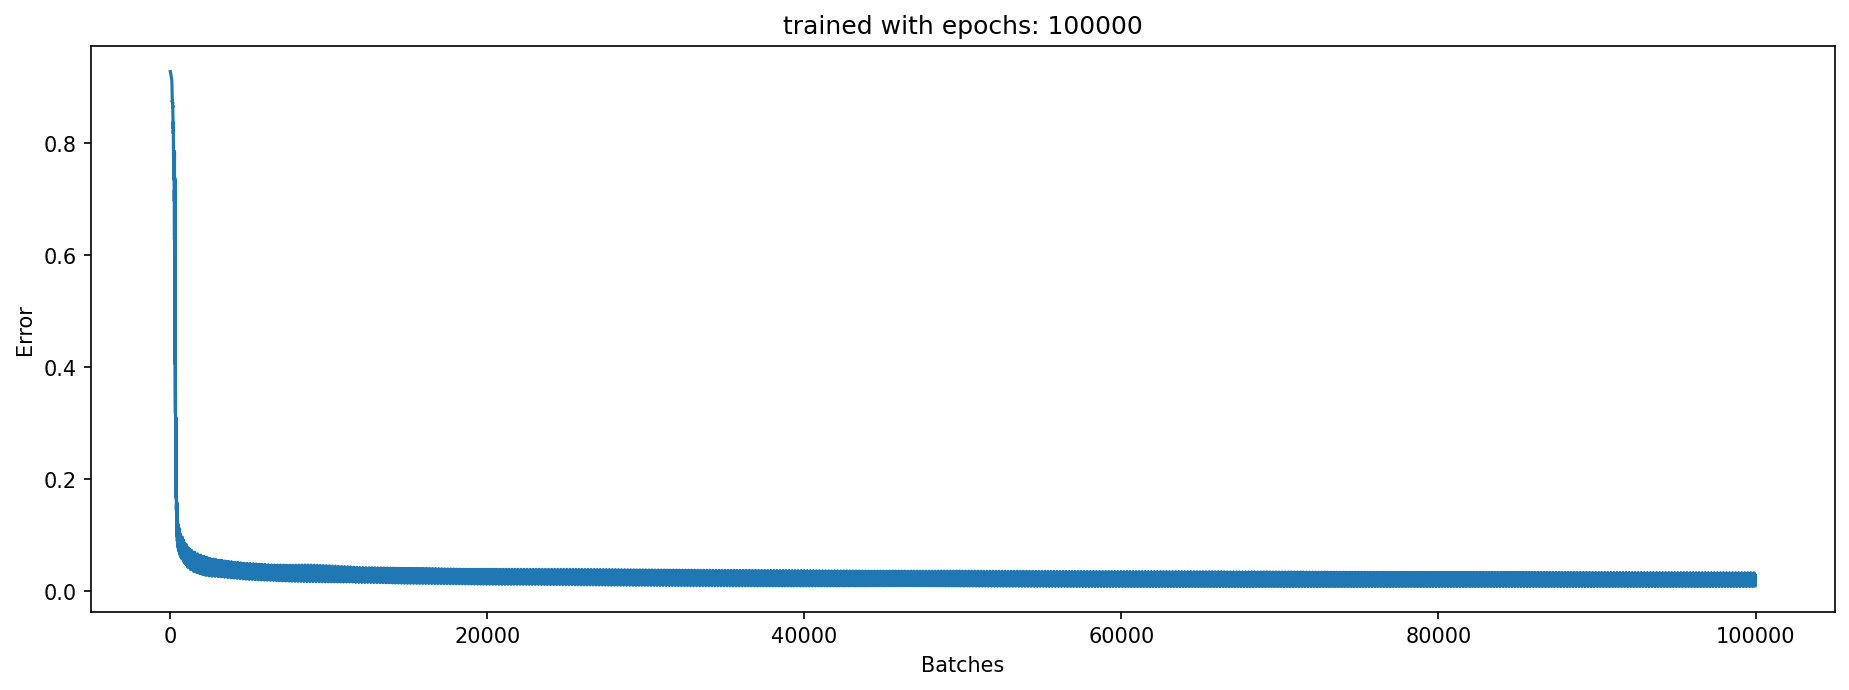

train 4000 batch_size 1000 correct 983.0 of 1000 Ratio 0.983 Error 0.025738144898819742
test 4000 batch_size 1000 correct 969.0 of 1000 Ratio 0.969 Error 0.04327703321805649
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.5863892075271515
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.752                 0.493                0.702                 0.697
   1      2             0.759                 0.513                0.711                 0.702
   1      3             0.764                 0.517                0.711                 0.708
   1      4             0.771                 0.517                0.711                 0.714
   1      5             0.784                 0.515                0.709                 0.723
   1      6             0.815                 0.505                0.700                 0.744
   1

   9      3             0.750                 0.803                0.905                 0.746
   9      4             0.749                 0.795                0.905                 0.747
   9      5             0.747                 0.792                0.904                 0.745
   9      6             0.744                 0.789                0.904                 0.742
   9      7             0.745                 0.787                0.904                 0.743
   9      8             0.741                 0.784                0.902                 0.740
   9      9             0.740                 0.784                0.902                 0.740
   9     10             0.740                 0.783                0.901                 0.740
  10      1             0.816                 0.795                0.891                 0.808
  10      2             0.841                 0.774                0.896                 0.821
  10      3             0.848                 0.76

In [107]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 16
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

It helps a lot to use the new data points more than once for training. Before same datapoints of the two new labels were used 10 times (counted as one shot, as it is really only one new information used). Using each new dataset only once results in a much lower performance:

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  12960 dropped 0 real parameters 12960 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


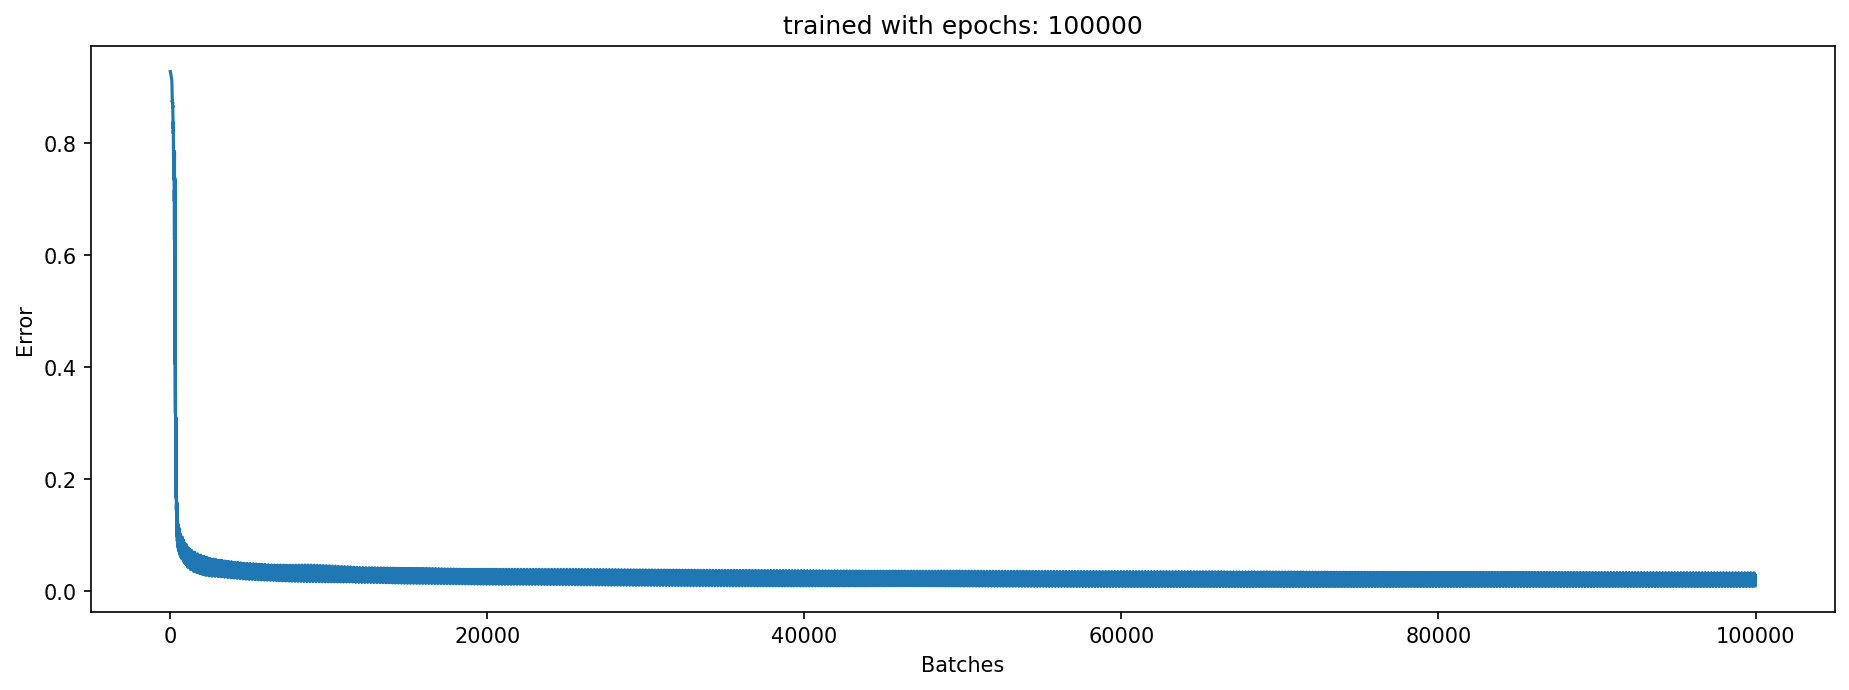

train 4000 batch_size 1000 correct 983.0 of 1000 Ratio 0.983 Error 0.025738144898819742
test 4000 batch_size 1000 correct 969.0 of 1000 Ratio 0.969 Error 0.04327703321805649
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.5863892075271515
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.752                 0.493                0.702                 0.697
   2      1             0.627                 0.715                0.791                 0.637
   3      1             0.812                 0.469                0.524                 0.759
   4      1             0.871                 0.485                0.622                 0.799
   5      1             0.670                 0.771                0.812                 0.688
   6      1             0.692                 0.498                0.813                 0.639
   7

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 16
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Even using it twice is comparable to using it 10 times:

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  12960 dropped 0 real parameters 12960 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


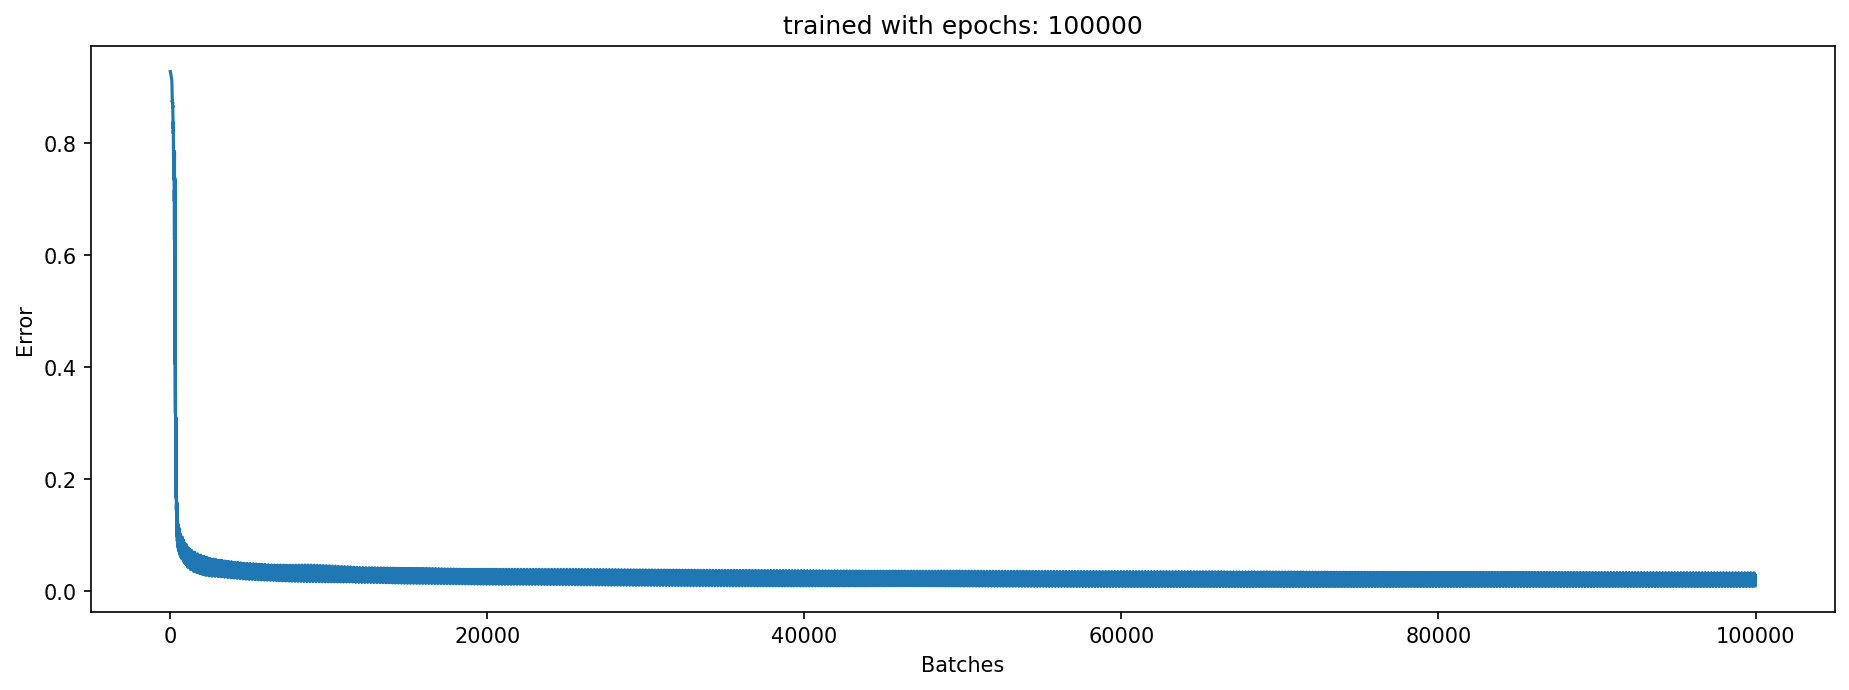

train 4000 batch_size 1000 correct 983.0 of 1000 Ratio 0.983 Error 0.025738144898819742
test 4000 batch_size 1000 correct 969.0 of 1000 Ratio 0.969 Error 0.04327703321805649
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.5863892075271515
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.752                 0.493                0.702                 0.697
   1      2             0.759                 0.513                0.711                 0.702
   2      1             0.646                 0.691                0.779                 0.649
   2      2             0.701                 0.598                0.784                 0.664
   3      1             0.853                 0.434                0.528                 0.781
   3      2             0.882                 0.411                0.600                 0.788
   4

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 16
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 2 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

In [3]:
Testing with a size of 64 for the hidden layers:

SyntaxError: invalid syntax (<ipython-input-3-7e51721897ee>, line 1)

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


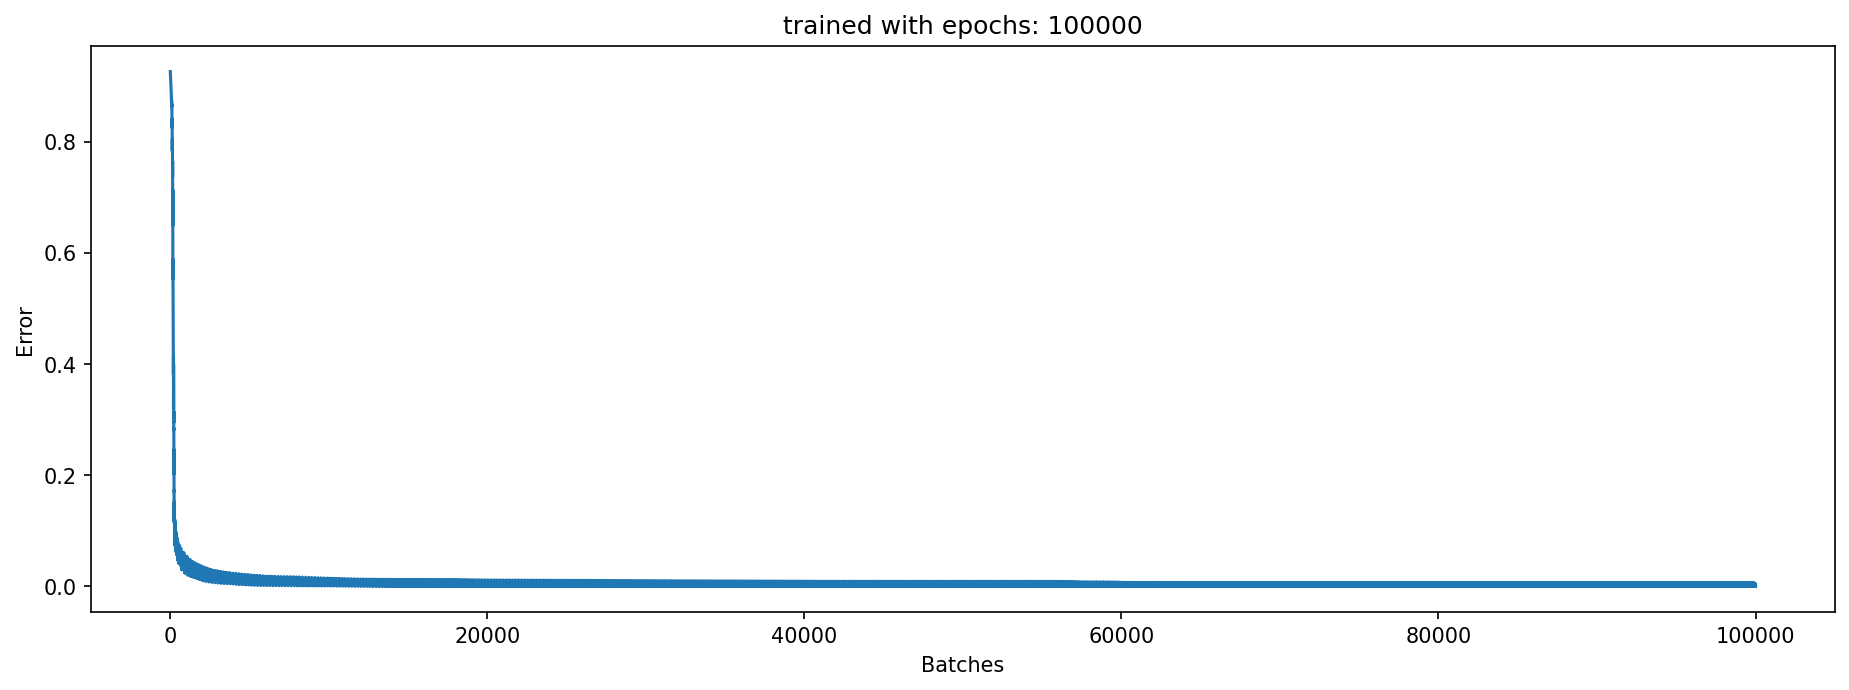

train 4000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.002056176738317593
test 4000 batch_size 1000 correct 989.0 of 1000 Ratio 0.989 Error 0.017220532802572196
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6742333548219135
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.919                 0.565                0.758                 0.855
   1      2             0.951                 0.436                0.703                 0.861
   1      3             0.954                 0.458                0.744                 0.865
   1      4             0.953                 0.456                0.745                 0.862
   1      5             0.952                 0.454                0.742                 0.860
   1      6             0.952                 0.454                0.740                 0.861
   

   9      3             0.927                 0.757                0.909                 0.889
   9      4             0.928                 0.757                0.909                 0.890
   9      5             0.929                 0.754                0.909                 0.891
   9      6             0.929                 0.754                0.910                 0.891
   9      7             0.929                 0.754                0.911                 0.891
   9      8             0.929                 0.753                0.910                 0.891
   9      9             0.929                 0.752                0.909                 0.891
   9     10             0.928                 0.750                0.909                 0.889
  10      1             0.910                 0.741                0.882                 0.872
  10      2             0.923                 0.747                0.900                 0.886
  10      3             0.927                 0.74

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

And trying only using every shot once for the net with hidden layer size 64

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


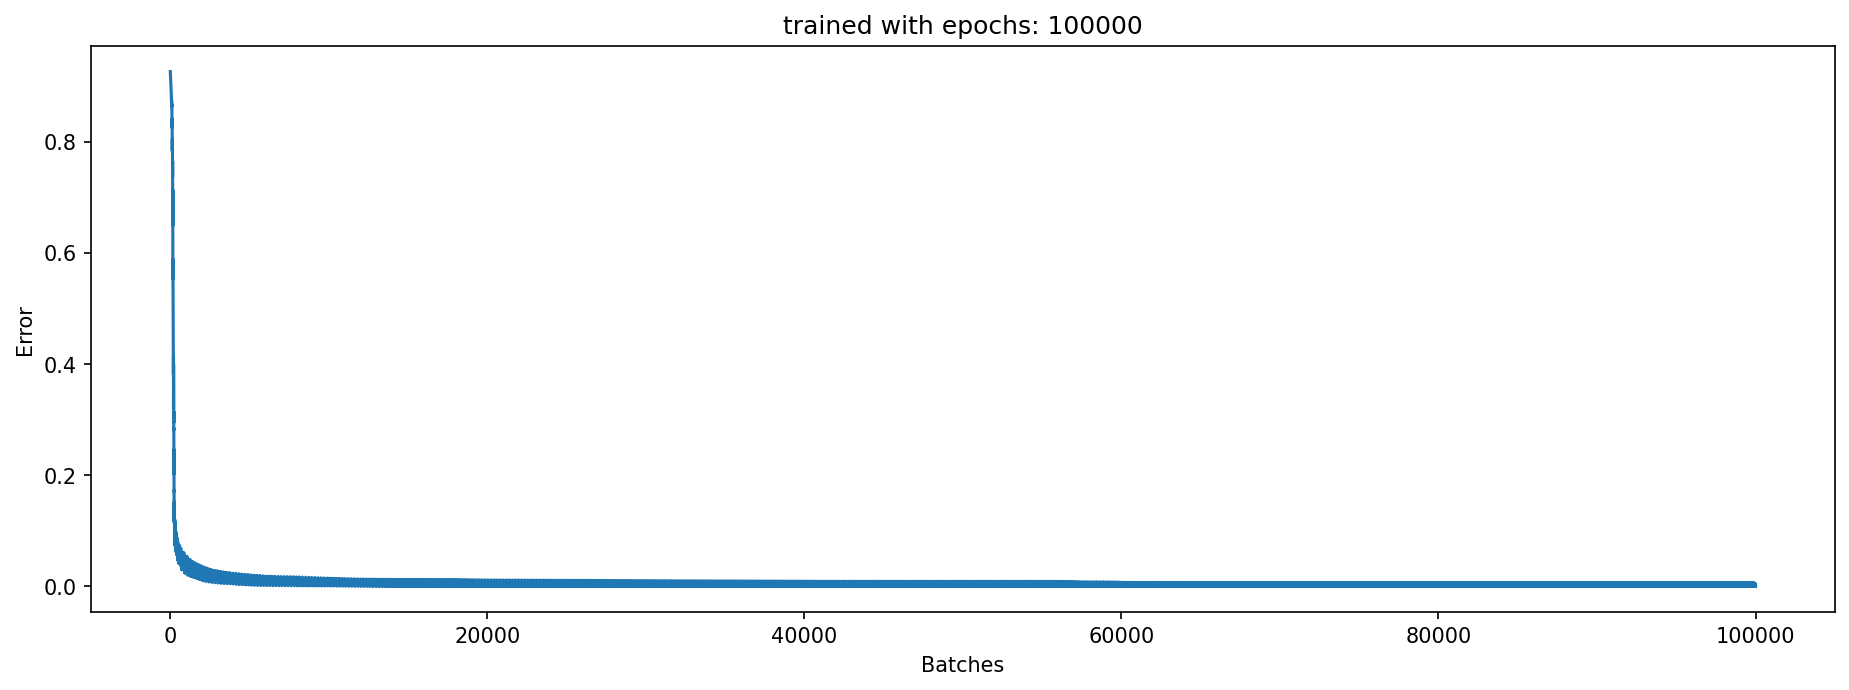

train 4000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.002056176738317593
test 4000 batch_size 1000 correct 989.0 of 1000 Ratio 0.989 Error 0.017220532802572196
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6742333548219135
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.919                 0.565                0.758                 0.855
   2      1             0.831                 0.684                0.784                 0.805
   3      1             0.929                 0.451                0.629                 0.844
   4      1             0.932                 0.509                0.796                 0.853
   5      1             0.840                 0.728                0.800                 0.817
   6      1             0.946                 0.696                0.830                 0.897
   

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

This is comparable to using every shot 10 times. Bigger nets seem to make less important to use every data point multiple times.

Now we try with an even bigger net. The size of the hidden layers is 128:


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 07:50:47


100%|██████████| 100000/100000 [2:48:09<00:00,  9.91it/s] 


end 10:38:57


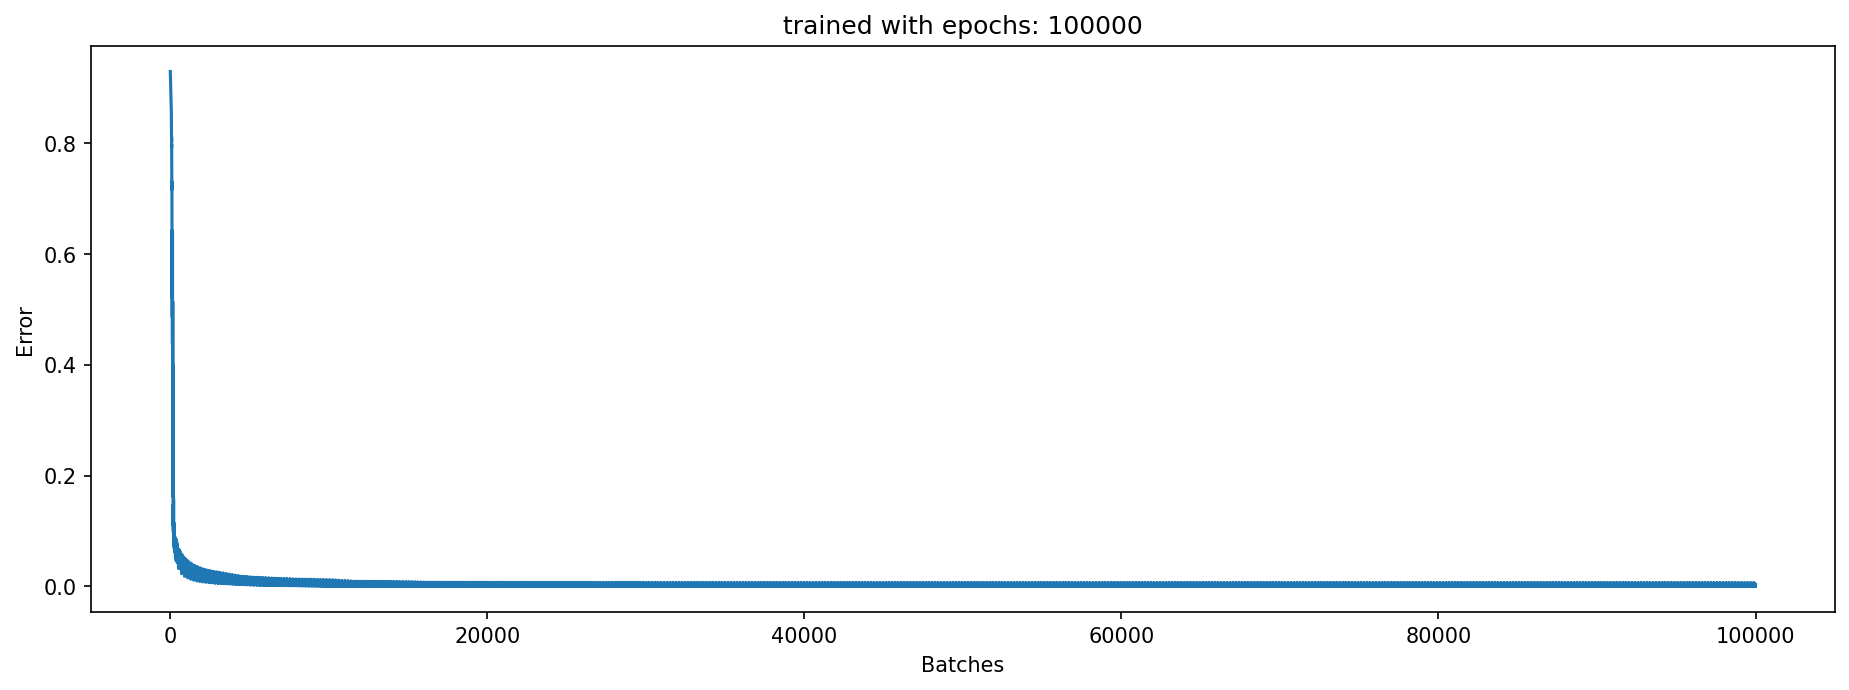

train 192000 batch_size 1000 correct 1000.0 of 1000 Ratio 1.0 Error 3.221398914560528e-05
test 4000 batch_size 1000 correct 991.0 of 1000 Ratio 0.991 Error 0.014413614294520559
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6693057776547948
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.847                 0.454                0.528                 0.776
   1      2             0.889                 0.435                0.520                 0.809
   1      3             0.861                 0.479                0.536                 0.794
   1      4             0.880                 0.488                0.560                 0.809
   1      5             0.897                 0.529                0.615                 0.827
   1      6             0.899                 0.526                0.613                 0.827
 

   9      3             0.884                 0.886                0.936                 0.877
   9      4             0.886                 0.887                0.938                 0.880
   9      5             0.887                 0.885                0.938                 0.881
   9      6             0.887                 0.885                0.938                 0.881
   9      7             0.887                 0.884                0.937                 0.881
   9      8             0.888                 0.884                0.937                 0.882
   9      9             0.890                 0.885                0.938                 0.883
   9     10             0.890                 0.885                0.938                 0.883
  10      1             0.903                 0.854                0.945                 0.892
  10      2             0.907                 0.861                0.949                 0.897
  10      3             0.908                 0.86

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 128
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

And trying using every shot only once:

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  118016 dropped 0 real parameters 118016 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


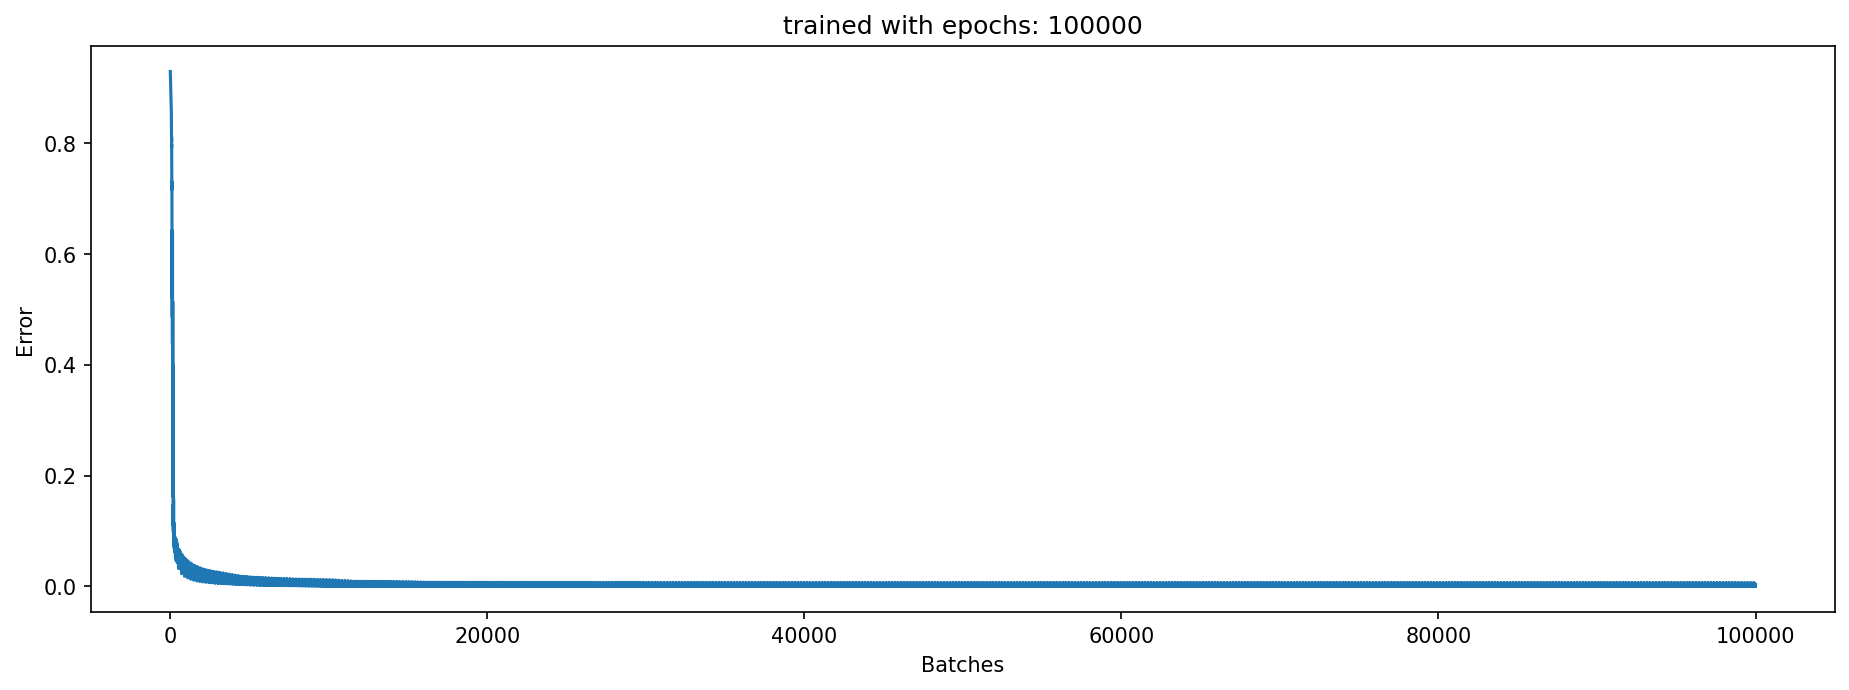

train 4000 batch_size 1000 correct 998.0 of 1000 Ratio 0.998 Error 0.0030186748020949315
test 4000 batch_size 1000 correct 991.0 of 1000 Ratio 0.991 Error 0.014413614294520559
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6693057776547948
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.847                 0.454                0.528                 0.776
   2      1             0.863                 0.678                0.723                 0.824
   3      1             0.949                 0.455                0.517                 0.859
   4      1             0.954                 0.465                0.537                 0.867
   5      1             0.867                 0.588                0.604                 0.821
   6      1             0.906                 0.800                0.878                 0.885
  

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 128
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

It seems, that shifting and scaling of the sigmoid function is indeed important. This was experienced by test with the toy net. It might make sense, as we use 0 and 1 with only weights and no bias. Test with hidden_size 16

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  12960 dropped 0 real parameters 12960 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


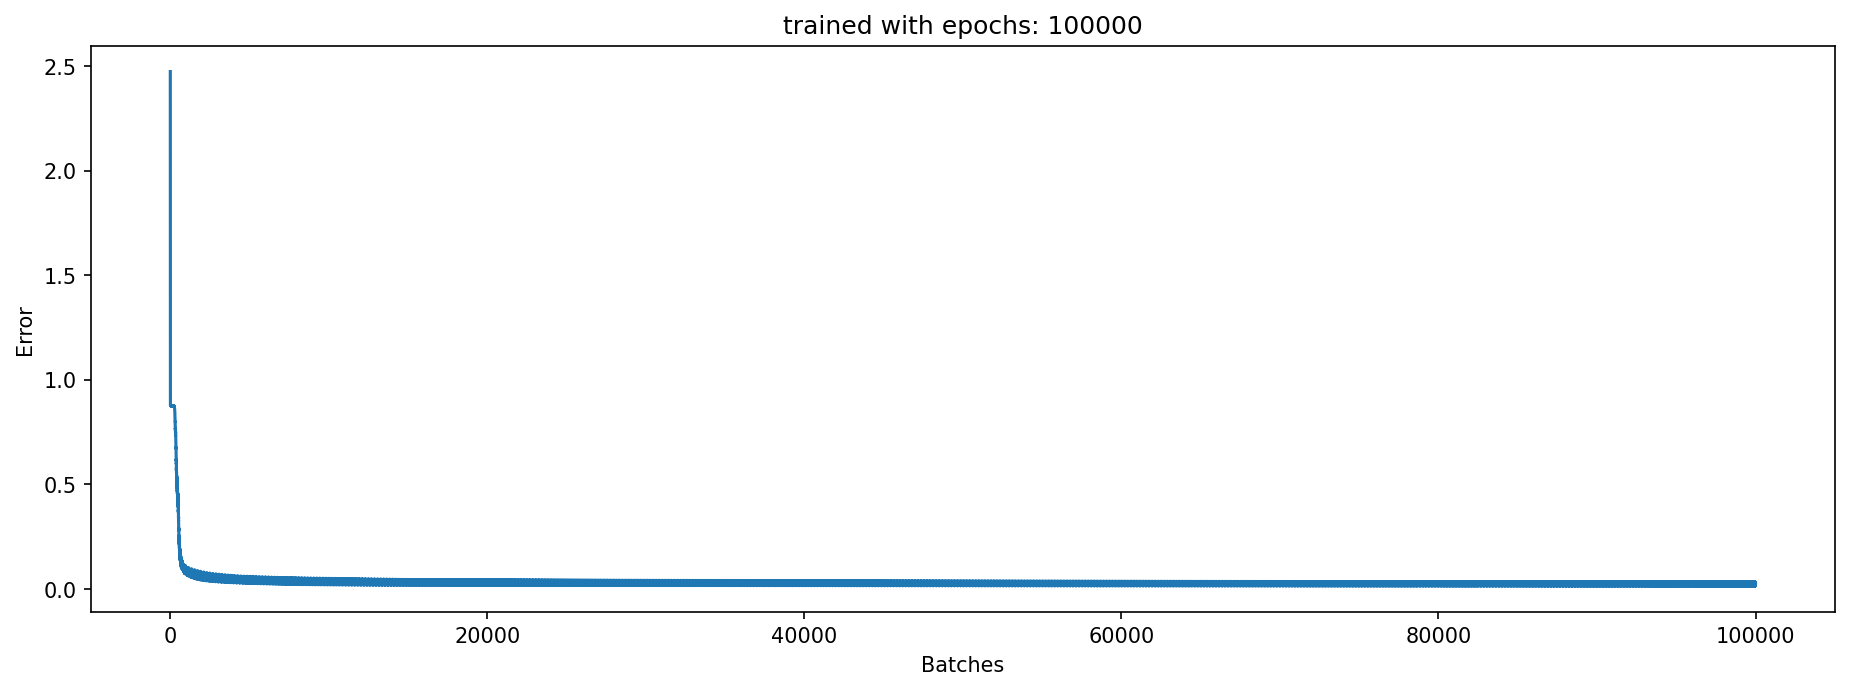

train 4000 batch_size 1000 correct 987.0 of 1000 Ratio 0.987 Error 0.019925590919582386
test 4000 batch_size 1000 correct 972.0 of 1000 Ratio 0.972 Error 0.04818163862308391
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.603544231118848
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.892                 0.204                0.611                 0.760
   1      2             0.896                 0.198                0.614                 0.760
   1      3             0.903                 0.192                0.617                 0.767
   1      4             0.910                 0.194                0.616                 0.773
   1      5             0.914                 0.189                0.615                 0.774
   1      6             0.920                 0.189                0.616                 0.779
   1 

   9      3             0.888                 0.618                0.819                 0.835
   9      4             0.890                 0.619                0.820                 0.835
   9      5             0.891                 0.616                0.823                 0.835
   9      6             0.893                 0.613                0.824                 0.836
   9      7             0.893                 0.607                0.822                 0.836
   9      8             0.894                 0.606                0.823                 0.837
   9      9             0.894                 0.611                0.825                 0.838
   9     10             0.895                 0.611                0.826                 0.836
  10      1             0.880                 0.642                0.798                 0.834
  10      2             0.882                 0.647                0.801                 0.838
  10      3             0.885                 0.65

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 16
two_hidden_layers = True
use_bias = False

lr = 6
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 1
shift_sigmoid = 0

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py

The sigmoid function shift is corrected to 0.5, which makes more sense, as it is between 0 and 1, the output of the activation functions. So everything is centered around the mean value...

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 14:42:29


100%|██████████| 100000/100000 [27:36<00:00, 60.36it/s]


end 15:10:06


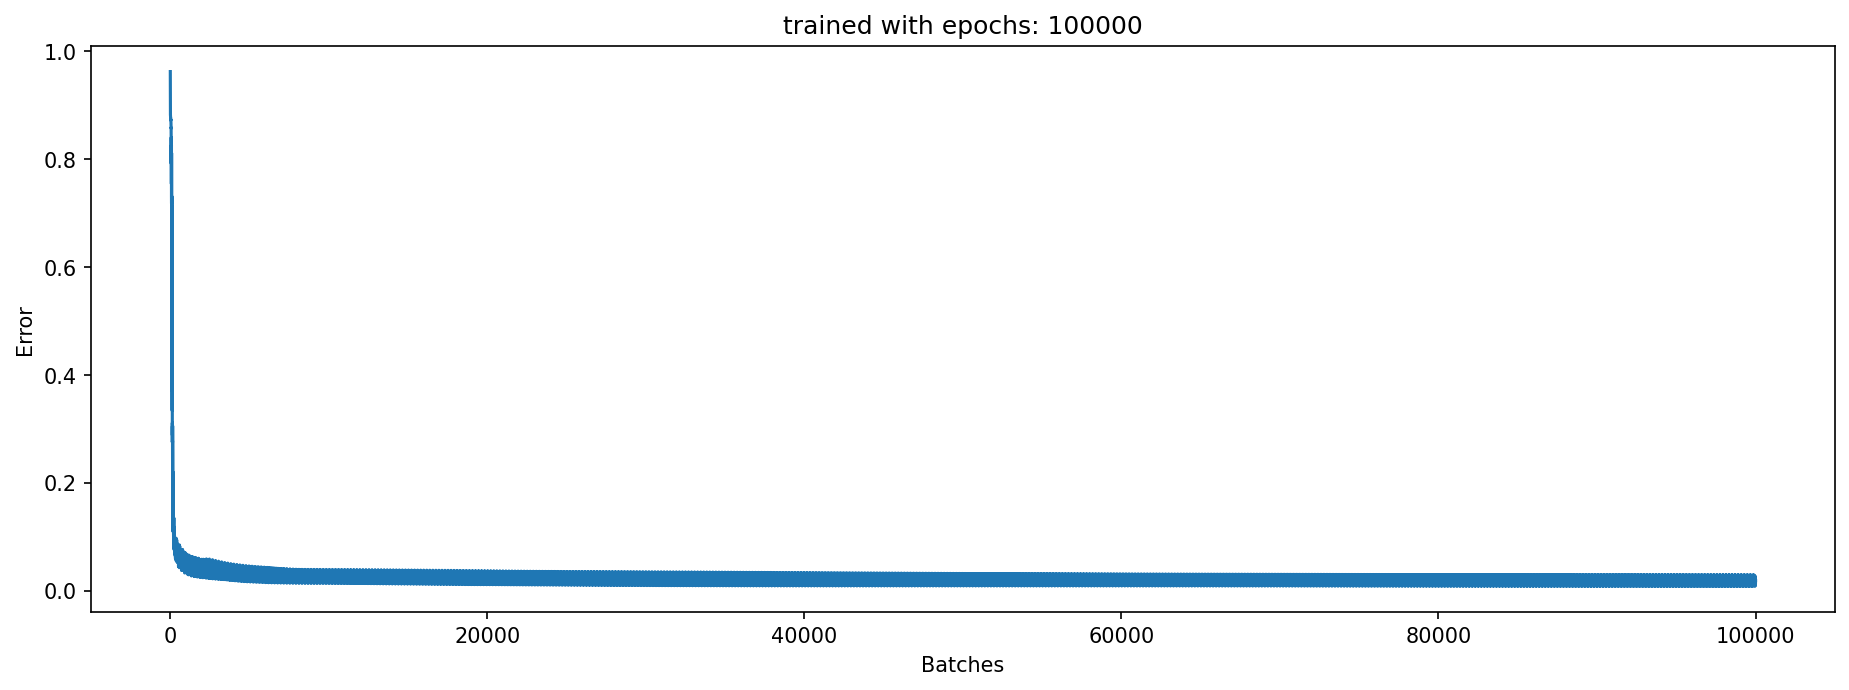

train 192000 batch_size 1000 correct 992.0 of 1000 Ratio 0.992 Error 0.018315556247151504
test 4000 batch_size 1000 correct 978.0 of 1000 Ratio 0.978 Error 0.03730650043390785
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6355480754347964
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.866                 0.441                0.745                 0.791
   1      2             0.894                 0.455                0.756                 0.809
   1      3             0.923                 0.448                0.762                 0.833
   1      4             0.937                 0.413                0.766                 0.837
   1      5             0.941                 0.394                0.759                 0.831
   1      6             0.938                 0.396                0.756                 0.830
  

   9      3             0.850                 0.800                0.879                 0.826
   9      4             0.849                 0.799                0.877                 0.823
   9      5             0.844                 0.795                0.874                 0.818
   9      6             0.842                 0.793                0.872                 0.817
   9      7             0.840                 0.793                0.875                 0.815
   9      8             0.838                 0.795                0.876                 0.813
   9      9             0.839                 0.792                0.874                 0.813
   9     10             0.837                 0.792                0.873                 0.812
  10      1             0.883                 0.778                0.875                 0.850
  10      2             0.890                 0.767                0.876                 0.853
  10      3             0.897                 0.76

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 16
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 0.5

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  12960 dropped 0 real parameters 12960 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


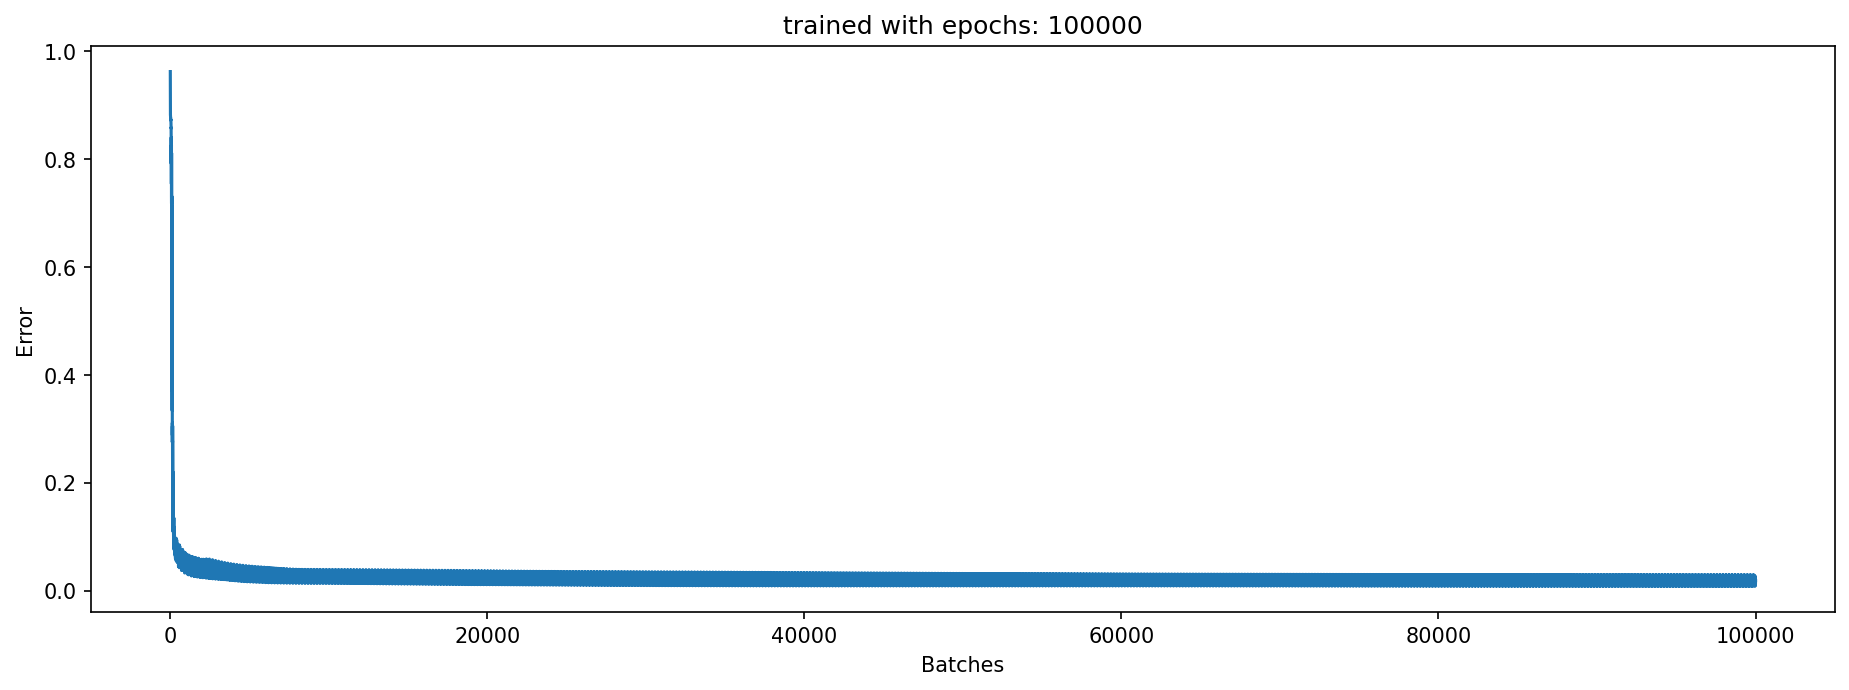

train 4000 batch_size 1000 correct 990.0 of 1000 Ratio 0.99 Error 0.020058774898112648
test 4000 batch_size 1000 correct 978.0 of 1000 Ratio 0.978 Error 0.03730650043390785
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6355480754347964
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.866                 0.441                0.745                 0.791
   2      1             0.674                 0.675                0.756                 0.668
   3      1             0.886                 0.519                0.793                 0.815
   4      1             0.858                 0.616                0.858                 0.815
   5      1             0.812                 0.731                0.876                 0.800
   6      1             0.834                 0.670                0.803                 0.801
   7 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 16
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 0.5

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 17:57:41


 41%|████      | 40599/100000 [33:39<49:14, 20.11it/s]  


Interrupted by keyboard


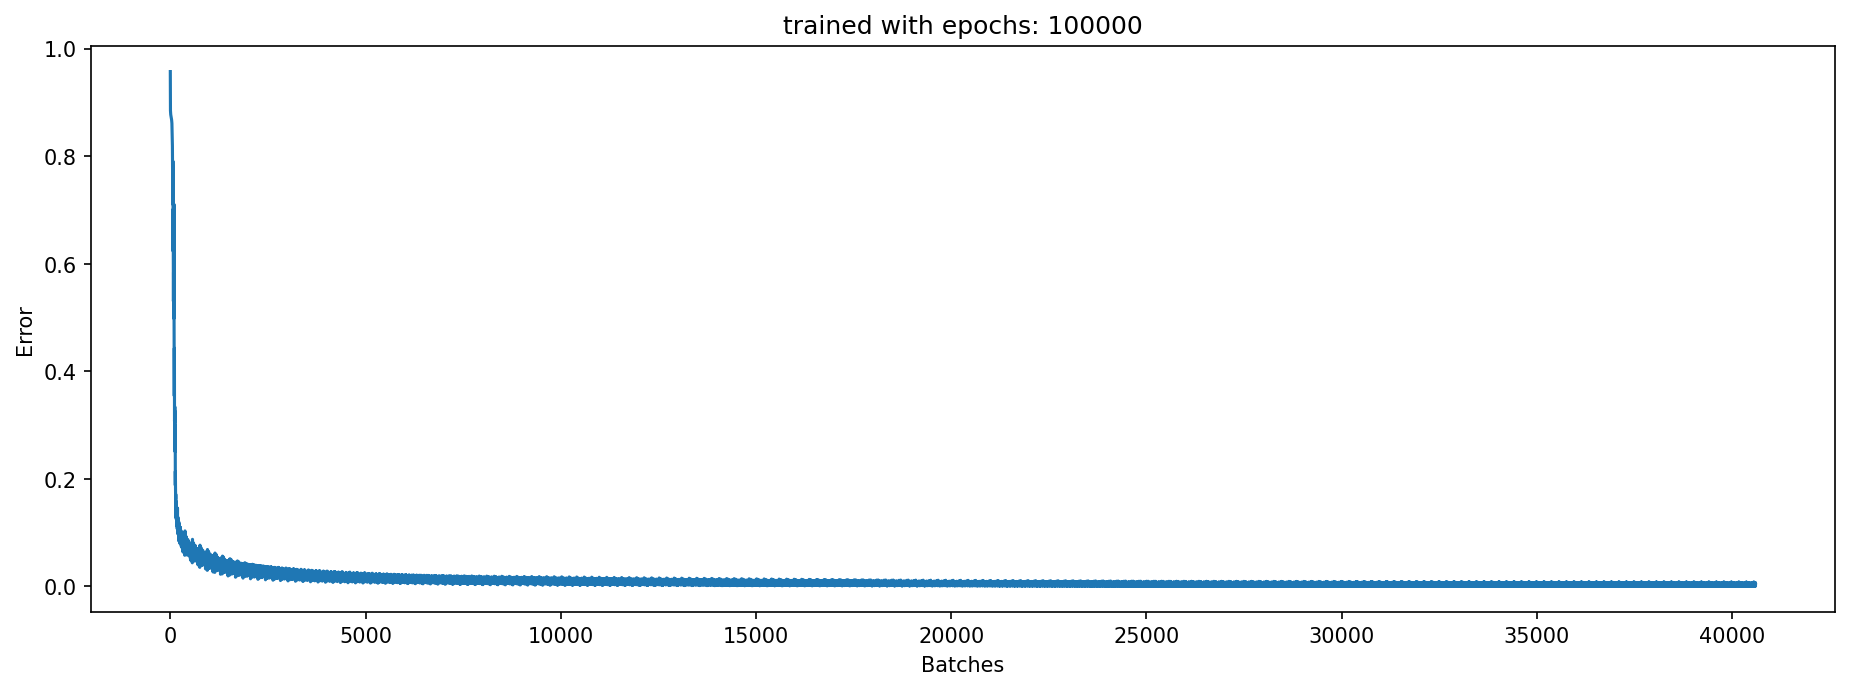

train 192000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.0015536708246029762
test 4000 batch_size 1000 correct 984.0 of 1000 Ratio 0.984 Error 0.02594435503951628
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6617531000473427
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.768                 0.443                0.516                 0.707
   2      1             0.627                 0.461                0.489                 0.591
   3      1             0.899                 0.387                0.519                 0.815
   4      1             0.917                 0.437                0.612                 0.837
   5      1             0.941                 0.511                0.695                 0.871
   6      1             0.948                 0.579                0.766                 0.882
 

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 1
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 0.5

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py

In [1]:
%%writefile _code_.py 
# uncomment line before to run in jupyter notebook with command after constant definition


NN2_file_identifier = '_' + str(do_batch_training) + '_' + str(hidden_size) # used for the pickle file to reload pretrained files with different parameters

if use_bias:
    NN2_file_identifier += 'b_'
if do_pm:
    NN2_file_identifier += 'pm'
    
if few_shot_more_at_once != 1:
    print('Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!')
if load_mnist:
    print('labels (last two are used for few_shot)', all_labels)
    
#np.seterr(under='ignore', over='ignore')

def sigmoid(x):
    if do_pm:
        return np.tanh(x)
    xx = scale_sigmoid * (x - shift_sigmoid)
    return 1 / (1 + np.exp(-xx)) #* 2 -1

def sigmoid_derivative(x):
    if do_pm:
        return 1-np.tanh(x)**2
    xx = scale_sigmoid * (x - shift_sigmoid)
    return scale_sigmoid * (np.exp(-xx) / (np.exp(-xx) + 1) ** 2)

def transform_01_mp(x):
    return 2*x - 1

def run_load_mnist(show_msg = True, use_test = False, limit_labels = None, only_load_num = None):
    #global inputs, outputs, bbs
    # simelar to https://www.python-course.eu/neural_network_mnist.php
    #image_size = 28 # width and length
    #no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
    #image_pixels = image_size * image_size
    if not load_mnist:
        print('This should not happen!!')
    data_path = "test_few_shot/data/mnist/" # makes it possible to use kernel from jupyter notebook
    
    # speedup loading
    fac = 0.99 / 255
    if not use_emnist:
        try:
            with open(data_path + "pickled_mnist.pkl", "br") as fh:
                (train_data, test_data) = pickle.load(fh)
        except:
            train_data = np.loadtxt(data_path + "mnist_train.csv", 
                                    delimiter=",")
            test_data = np.loadtxt(data_path + "mnist_test.csv", 
                               delimiter=",") 
            with open(data_path + "pickled_mnist.pkl", "bw") as fh:
                pickle.dump((train_data, test_data), fh)
                
        
        if use_test:
            used_imgs = np_array(test_data[:, 1:]) * fac + 0.01
            dataset_name = 'Test dataset'
            used_labels = np_array(test_data[:, :1])
        else:
            used_imgs = np_array(train_data[:, 1:]) * fac + 0.01
            dataset_name = 'Train dataset'
            used_labels = np_array(train_data[:, :1])
    else:
        if use_test:
            dataset_name = 'Test dataset'
            (used_imgs, used_labels) = extract_test_samples('digits')
        else:
            dataset_name = 'Train dataset'
            (used_imgs, used_labels) = extract_training_samples('digits')
        used_imgs = np_array(used_imgs.reshape(-1, 28*28)) * fac + 0.01
        used_labels = used_labels.reshape(-1,1)
        
    if limit_labels is not None:
        new_imgs = []
        new_labels = []
        for i in range(len(used_labels)):
            if int(used_labels[i][0]) in limit_labels:
                new_imgs.append(used_imgs[i].tolist())
                new_labels.append(used_labels[i].tolist())
                if only_load_num is not None and len(new_labels) >= only_load_num:
                    break
        used_imgs = np_array(new_imgs)
        used_labels = np_array(new_labels)
    
    
    if num_outputs == 1:
        used_labels = np.around(1 - np.sign(np.abs(used_labels - label_to_one)))
    elif num_outputs == 10:
        label_transform = np.zeros((10, 10), int)
        np.fill_diagonal(label_transform, 1)
        label_transform = label_transform.tolist()
        used_labels = [label_transform[int(np.around(x[0]))] for x in used_labels]
        used_labels = np_array(used_labels)
#        raise Exception('not yet implementd')
    else:
        raise Exception('not yet implementd')

    inputs = used_imgs[:first_n_to_use]     
    outputs = used_labels[:first_n_to_use]
    bbs = ''
    for l in np.around(outputs):
        bbs += str(int(l[0]))
    if show_msg:
        if num_outputs == 10:
            if verbose > 0:
                print('loaded mnist', dataset_name,' with 10 labels', limit_labels)
        else:
            print('loaded mnist', dataset_name,' with output labels ',label_to_one,' resulting in learning labels', bbs[:10], '....')
    if len(bbs) > 50:
        bbs = 'to long to plot'
    if do_pm:
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)
    return (inputs, outputs, bbs)


if load_mnist:
    (inputs, outputs, bbs) = run_load_mnist()
else:
    if do_pm: # prepare the fixed inputs, load_mnist does it in the function
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)




vertical_distance_between_layers = 6
horizontal_distance_between_neurons = 2
neuron_radius = 0.5
neuron_scale_line = 2.0
number_of_neurons_in_widest_layer = 4
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, v):
        if v > 0:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='green', linewidth = 3)
        else:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='gray', linewidth = 3)
        pyplot.gca().add_patch(circle)

class Layer():
    def __init__(self, network, number_of_neurons, weights, bias, values, slow_learning):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.weights = weights
        if weights is not None:
            self.stability = np.zeros(weights.shape)
        self.drop_weights = None
        self.bias = bias
        self.values = values
        self.slow_learning = slow_learning

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, linewidth, graylevel = None, usage = None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        if graylevel is None:
            nr = neuron_radius * neuron_scale_line
        else:
            nr = neuron_radius * 1.4
        x_adjustment = nr * sin(angle)
        y_adjustment = nr * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        if linewidth > 0:
            c = 'green'
        else:
            c = 'red'
        
        lw = linewidth * scale_linewidth
        if graylevel is not None:
            #graylevel = (graylevel +1)/2
            if graylevel < 0: graylevel = 0
            if graylevel > 1: graylevel = 1
            c = (0, 0, 1, graylevel)
            lw = linewidth
        if usage is not None:
            #graylevel = (graylevel +1)/2
            if usage < 0: usage = 0
            if usage > 1: usage = 1
            c = (1, 1- usage / 3, 1 - usage)
            lw = linewidth
            
        line = pyplot.Line2D(line_x_data, line_y_data, linewidth=np.abs(lw), color = c)
        pyplot.gca().add_line(line)

    def draw(self, usage):
        for this_layer_neuron_index in range(len(self.neurons)):
            neuron = self.neurons[this_layer_neuron_index]
            neuron.draw(round(self.values[this_layer_neuron_index]))
            if self.previous_layer:
                for previous_layer_neuron_index in range(len(self.previous_layer.neurons)):
                    previous_layer_neuron = self.previous_layer.neurons[previous_layer_neuron_index]
                    weight = self.previous_layer.weights[previous_layer_neuron_index, this_layer_neuron_index]
                    stability = self.previous_layer.stability[previous_layer_neuron_index, this_layer_neuron_index]
                    used = 0
                    if weight > 0:
                        used = self.previous_layer.values[previous_layer_neuron_index] * self.values[this_layer_neuron_index]
                    else:
                        used = self.previous_layer.values[previous_layer_neuron_index] * (1 - self.values[this_layer_neuron_index])
                                                              
                    #print("connection %2d %2d    %6.3f    %6.3f    %6.3f    %6.3f used: %6.3f" % (previous_layer_neuron_index, this_layer_neuron_index, self.previous_layer.values[previous_layer_neuron_index], self.values[this_layer_neuron_index], weight, stability, used))
                    if usage:
                        self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, usage = used)
                    else:
                        if use_stability:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, stability)
                        else:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, 0.3)
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weight)
                    
    def backward(self, post_error):
        
        error_between_sigmoid_and_full = post_error * sigmoid_derivative(self.between_full_sigmoid) # post layer may be wrong!!!!!!!!
        
        pre_error = np.dot(error_between_sigmoid_and_full, self.weights.T) 
        d_weights = np.dot(self.values.T, error_between_sigmoid_and_full) / len(post_error) # scale learning rate per input
        d_bias = np.sum(error_between_sigmoid_and_full, axis = 0) /len(post_error) 
        
        self.change_weights(d_weights, d_bias)
        return pre_error
    
    def forward(self, pre_layer, dostability):
        self.values = pre_layer
        if self.weights is None:
            return pre_layer
        self.between_full_sigmoid = np.dot(pre_layer, self.weights)
        if use_bias:
            self.between_full_sigmoid += self.bias
        post_layer = sigmoid(self.between_full_sigmoid)
        if dostability:
            post_l = np.expand_dims(post_layer,-2)
            pre_l_2d = np.expand_dims(pre_layer, -2)
            
            # this is necessary if 0 1 neurons are used, not if -1 1 ones
            post_l = transform_01_mp(post_l)
            pre_l = transform_01_mp(pre_l_2d)
            
            #print(np.transpose(post_l[2]), pre_l[2])
            stability = (np.tanh(scale_for_neuron_diff * np.matmul(pre_l.swapaxes(-1,-2), post_l)) * np.tanh(self.weights / weight_tanh_scale) + 1) / 2
            stability = pre_l_2d.swapaxes(-1,-2) * stability # only active inputs count for stability
            if len(stability.shape) == 2:
                stability = np.expand_dims(stability, 0) # handle single and multi inputs
            stability = np.sum(stability, axis = 0) / len(stability)
            #print(stability)
            #self.stability = stability_mean * pre_layer.T * stability + (1 - stability_mean * pre_layer.T) * self.stability
            self.stability = stability_mean * stability + (1 - stability_mean) * self.stability
        return post_layer
        
    def change_weights(self, d_weights, d_bias):
        if use_stability:
            direct = 1 - self.stability
        else:
            direct = np_array([1])
        #print('direct', direct)
        self.weights += d_weights * lr * direct * self.slow_learning
        self.bias +=  d_bias *lr * np.sum(direct, axis = 0) * self.slow_learning
        np.clip(self.weights, -clip_weights, clip_weights, self.weights)
        np.clip(self.bias, -clip_bias, clip_bias, self.bias)
        if self.drop_weights is not None:
            self.weights *= self.drop_weights
            
        
class DrawNet():
    def __init__(self):
        self.layers = []
        self.epoch_list = []
        self.error_history = []
        self.error = None

        # batch handling, as cuda might not have enough memory to hold all inputs
        self.all_input = None
        self.all_output = None
        self.batch_pos = None
        self.batch_size = None
        
    def add_layer(self, number_of_neurons, weights, bias, values, slow_learning = 1):
        layer = Layer(self, number_of_neurons, weights, bias, values, slow_learning)
        self.layers.append(layer)
    
    def forward(self, dostability = False):
        outp = self.layers[0].values
        for layer in self.layers:
            outp = layer.forward(outp, dostability)
        #self.layers[-1].values = outp
        self.error = self.y - self.layers[-1].values
        if check_for_nan:
            if np.any(np.isnan(self.error)):
                print('nan')
        return outp
    
    def backward(self):
        #self.error = pre_error = self.y - self.layers[-1].values # forward must be called first anyway
        pre_error = self.error
        for layer in reversed(self.layers[:-1]):
            #print('pre_error', pre_error.flatten())
            pre_error = layer.backward(pre_error)
        return pre_error
    
    def train(self, epochs=1000):
        self.epochs = epochs # just to know how it was trained for output
        self.error_history = []
        self.epoch_list = []
        ttt = tqdm(range(epochs), mininterval = 10, disable=disable_progressbar)
        for epoch in ttt:
            # flow forward and produce an output
            self.forward(True)
            # go back though the network to make corrections based on the output
            self.backward()
            self.next_batch()
            # keep track of the error history over each epoch
            err = np.sum(np.square(self.error))
            self.error_history.append(err)
            self.epoch_list.append(epoch)
            ttt.set_description("Err %6.3f" % (err/self.batch_size), refresh=False)
        self.forward() # to update the output layer, if one needs to print infos...
    
    def plot_train_history(self):
        pyplot.figure(figsize=(15,5))
        pyplot.plot(self.epoch_list, self.error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.show()
        pyplot.close()

    def set_input(self, new_input, new_output, batch_size = None):
        self.all_input = new_input
        self.all_output = new_output
        self.batch_size = batch_size
        if batch_size is not None:
            self.layers[0].values = new_input[:batch_size]
            self.y = new_output[:batch_size]
        else:
            self.layers[0].values = new_input
            self.y = new_output
        self.batch_pos = self.batch_size
        
    def next_batch(self):
        if self.batch_size is not None:
            self.layers[0].values = self.all_input[self.batch_pos : self.batch_pos+self.batch_size]
            self.y = self.all_output[self.batch_pos : self.batch_pos+self.batch_size]
            # if len(self.y) == 0:
            #     self.batch_pos = self.batch_size
            #     self.layers[0].values = self.all_input[:self.batch_pos]
            #     self.y = self.all_output[:self.batch_pos]
            if len(self.y) < self.batch_size:
                self.batch_pos = self.batch_size - len(self.y)
                self.layers[0].values = np.concatenate((self.layers[0].values, self.all_input[:self.batch_pos]))
                self.y = np.concatenate((self.y, self.all_output[:self.batch_pos]))
            else:
                self.batch_pos += self.batch_size
            
            
    def draw(self, result = None, usage = False, display_title = None):
        c = 0
        for layer in self.layers:
            c+=1
            #print('layer',c)
            layer.draw(usage)
        if result is not None:
            if result[0] > 0:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='green', linewidth = 3)
            else:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='gray', linewidth = 3)
            pyplot.gca().add_patch(circle)
        pyplot.axis('scaled')
        if display_title is not None:
            pyplot.title(display_title)
        pyplot.show()
        pyplot.close()
        
    def predict(self, new_input, oo = None, drawit=False, usage = False, display_title = None):
        self.set_input(new_input, oo)
        prediction = self.forward(False)
        if oo is not None:
            self.error = oo - prediction
        if drawit:
            self.draw(oo, usage, display_title)
        return prediction
    
    def count_parameters(self):
        count = 0
        drops = 0
        for l in self.layers:
            if l.weights is not None:
                count += l.weights.size
                if use_bias:
                    count += l.bias.size
                if l.drop_weights is not None:
                    drops += l.drop_weights.size - np.sum(l.drop_weights)
        return count, drops

def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    if two_hidden_layers:
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    if verbose > 0:
        print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

def bbs_to_output(x):
    res = []
    for c in x:
        res.append([int(c)])
    return np_array(res)

def creat_output_from_int(bb, length=8):
    bbs = ('{0:0'+str(length)+'b}').format(bb)
    output = bbs_to_output(bbs)
    if do_pm:
        output = transform_01_mp(output)
    return output, bbs

if do_check_all > 0:
    # checks all possible input output combinations to check, if the neural net is capable of learning in
    notok = 0
    sum_error_history = None
    for bb in range(0, check_output_limit):
        # bbs = '{0:08b}'.format(bb)
        # for l in range(len(bbs)): 
        #     if bbs[l] =='1':
        #         outputs[l] = 1
        #     else:
        #         outputs[l] = 0
        (outputs, bbs) = creat_output_from_int(bb)
        NN2 = setup_net()
        NN2.train(do_check_all)
        err = np.sum(NN2.error**2)
        ok = '*'
        if err < 0.2: 
            ok = ' '
        else:
            notok += 1
        if sum_error_history is None:
            sum_error_history = np_array(NN2.error_history)
        else:
            sum_error_history += np_array(NN2.error_history)
        if verbose > 1:
            #print(bbs, '{0:5.3f}'.format(float(err)),ok,notok)
            pyplot.figure(figsize=(15,5))
            pyplot.plot(NN2.epoch_list, NN2.error_history)
            pyplot.xlabel('Epoch')
            pyplot.ylabel('Error')
            pyplot.title(bbs)
            pyplot.show()
            pyplot.close()
        print("Label %8s error %6.3f" % (bbs, err), ok, "total fails yet:", notok)
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (sum_error_history / check_output_limit).tolist())
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Error')
    pyplot.title('sum error history')
    pyplot.show()
    pyplot.close()


        

# train neural network
#NN2.train()

#testing single inputs for few shot learning
askuser = True
stopit = False
few_shot = (multi_test > 0)


#NN2 = setup_net()
sum_error_history = None
if do_batch_training > 0:
    loaded_pretrained = False
    if try_load_pretrained:
        try:
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "br") as fh:
                NN2 = pickle.load(fh)
            num_params, count_drops = NN2.count_parameters()
            print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
            loaded_pretrained = True
            print('loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        except Exception as e:
            print('loading pretrained NN2 failed:', e)
            NN2 = setup_net()
    else:
        NN2 = setup_net()    
    if try_mnist_few_shot > 0:
        if loaded_pretrained:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2], only_load_num=few_shot_fast_load_num)
        else:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2])
    NN2.set_input(inputs, outputs, batch_size=1000)
    if not loaded_pretrained:
        try:
            print('start', datetime.now().strftime("%H:%M:%S"))
            NN2.train(do_batch_training)
            print('end', datetime.now().strftime("%H:%M:%S"))
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "bw") as fh:
                pickle.dump(NN2, fh)
        except KeyboardInterrupt:
            print('Interrupted by keyboard')
    NN2.forward() # most of the time, this should result in an OK net, but not safe, as train could be interrupted at any position
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (np_array(NN2.error_history) / len(NN2.error)).tolist())
    pyplot.xlabel('Batches')
    pyplot.ylabel('Error')
    pyplot.title('trained with epochs: ' + str(NN2.epochs))
    pyplot.show()
    pyplot.close()
    
    if num_outputs == 1:
        print('train', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('train', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('test ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('test', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    print('Testing if new lables were not learned !!!!!!!!!')
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    # now try a few shot learning for some steps
    # load with labels [8,9] and train every to a measure
    #
    # criteria label correct: (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0] true
    # distance to second largest label
    # biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
    # ratio = biggest_two[-1] / [-2] > threshold
    
    # max_iter is the maximal number of try's to optimize one data point in few_shot
    pos_1 = 0
    pos_2 = 0
    try:
        print('few shot accuracy results')
        print('shot     try       old labels            new labels  new labels (forced)              over all')
        for i_shot in range(try_mnist_few_shot): # some shots
            if change_first_layers_slow_learning is not None:
                for l in range(len(change_first_layers_slow_learning)):
                    before = NN2.layers[l].slow_learning
                    NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
                    if verbose > 0:
                        print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
            before = lr
            lr = lr_few_shot
            if verbose > 0:
                print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
            (inputs, outputs, bbs) = run_load_mnist(use_test = False)
            few1 = all_labels[-2]
            few2 = all_labels[-1]
            while outputs[pos_1].argmax() != few1:
                pos_1 += 1
            while outputs[pos_2].argmax() != few2:
                pos_2 += 1
            inp_1 = inputs[pos_1:pos_1+few_shot_more_at_once]
            outp_1 = outputs[pos_1:pos_1+few_shot_more_at_once]
            inp_2 = inputs[pos_2:pos_2+few_shot_more_at_once]
            outp_2 = outputs[pos_2:pos_2+few_shot_more_at_once]
            pos_1 += few_shot_more_at_once # prepare the next shot
            pos_2 += few_shot_more_at_once
            for m in range(use_every_shot_n_times):
                for (inp,outp) in [(inp_1,outp_1), (inp_2,outp_2)]:
                    if verbose > 0:
                        print('start training', outp)
                    epoch = 0
                    NN2.set_input(inp, outp)
                    while epoch < few_shot_max_try:
                        NN2.forward()
                        NN2.backward()
                        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
                        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0]:
                            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
                            if do_pm:
                                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
                            else:
                                ratio = biggest_two[-1] / biggest_two[-2]
                            if verbose > 0:
                                print(biggest_two, ratio)
                            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                                break
                if verbose > 0:
                    print('Results after few shot', i_shot + 1, 'used the ', m + 1, '. time')
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_old_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_new_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                # here only the few_shot trained lables are considdered
                res_values = NN2.layers[-1].values
                mask = [0] * len(all_labels)
                for l in all_labels[-2:]:
                    mask[l] = 1
                mask = np_array([mask])
                res_values = res_values * mask
                # deb = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum())
                acc_only_new_labels_forced = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('using only the few shot trained labels for possible output of neural net')
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(res_values.argmax(axis = 1) == few1), 'few2:', np.sum(res_values.argmax(axis = 1) == few2), 'correct', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                
                
                (inputs, outputs, bbs) = run_load_mnist(use_test = True, only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_overall_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                print("%4d    %3d           %7.3f               %7.3f              %7.3f               %7.3f" % (i_shot + 1, m + 1, acc_only_old_labels, acc_only_new_labels, acc_only_new_labels_forced, acc_only_overall_labels))
    except KeyboardInterrupt:
        print('Interrupted')
else:
    NN2 = setup_net()

multi = 0
while multi <= multi_test:
    # tries to do a few shot learning multiple times and checks, how fast it is learned
    # initializes the last layer weights when the label is changed
    pos_under_few_shot = 0
    if test_from_random_input:
        inp = []
        while len(inp) < 8:
            r = random.randrange(0,2**i_bits-1)
            if r not in inp:
                inp.append(r)
        inputs = []
        for bb in inp:
            v= [0]*i_bits
            bbs = ('{0:0'+str(i_bits)+'b}').format(bb)
            for l in range(len(bbs)): 
                if bbs[l] =='1':
                    v[l] = 1
                else:
                    v[l] = 0
            inputs.append(v)
        inputs = np_array(inputs)
    if not load_mnist:
        (outputs, bbs) = creat_output_from_int(random.randrange(0,check_output_limit - 1)) # first output always 0, as sigmoid network is not capable of outputting 1 here
        disp_label = bbs
    else:
        label_to_one = random.randrange(0, 9) # change the label used
        run_load_mnist(False)
        disp_label = label_to_one
        
    # reset weights in the last layer
    NN2.layers[-2].weights = init_rand_ampl * np_array(np.random.rand(hidden_size, 1)- 0.5)
    NN2.layers[-2].bias = init_rand_ampl * np_array(np.random.rand(1)- 0.5)

    NN2.set_input(inputs, outputs)
    # used to reset whole NN every time
    #NN2 = setup_net()

    error_history = []
    epoch_list = []
    epoch = 0
    while epoch < max_iter:
        for i in range(len(inputs)):
            same = True
            first = True
            fl = 0
            while same:
                if not few_shot:
                    same = False
                if askuser and multi_test == 0:
                    same = True
                    NN2.predict(inputs[i], outputs[i], True, usage = False)
                    # t = '3' 
                    doask = True
                    while doask:
                        doask = False
                        t = input(str(i)+' '+str(NN2.error)+' (1: same, 2:next, 3:stop asking, 4:exit, 5:few_shot, 6: change max epoch num)?')
                        if t.isdigit():
                            t = int(t)
                            if t == 2:
                                same = False
                                break
                            if t == 3:
                                askuser = False
                                same = False
                            if t == 4:
                                stopit = True
                                break
                            if t == 5:
                                few_shot = True
                                askuser = False
                            if t == 6:
                                max_iter = int(input('change max epoch num ' + str(max_iter) + ' '))
                                doask = True
                NN2.set_input(inputs[i:i+1], outputs[i:i+1])
                NN2.forward(dostability = first)
                NN2.backward()
                first = False
                this_error = sum(np.square(NN2.error))
                if this_error[0] > few_shot_end:
                    pos_under_few_shot = epoch + 1
                if len(epoch_list) == 0 or (len(epoch_list) > 0 and epoch_list[-1] != epoch + i / len(inputs)):
                    epoch_list.append(epoch + i / len(inputs))
                    error_history.append(this_error)
                fl += 1
                if fl > few_shot_max_try:
                    break
                if few_shot:
                    if abs(NN2.error[0]) < few_shot_end:
                        break
            if stopit:
                break
        if stopit:
            break
        NN2.set_input(inputs, outputs)
        NN2.forward()
        err = outputs - NN2.layers[-1].values
        NN2.predict(inputs[0], outputs[0], multi_test == 0, display_title = str(epoch)+': '+'{0:6.3f}'.format(float(np.sum(err**2))))
        epoch += 1
    

    if multi_test == 0:
        for i in range(len(inputs)):
            print(NN2.predict(inputs[i], outputs[i], drawit= (multi_test > 0), usage = True), 'correct', outputs[i])
    
    # plot the error over the entire training duration
    if sum_error_history is None:
        sum_error_history = np_array(error_history)
    else:
        sum_error_history += np_array(error_history)
    if verbose > 0:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title(str(multi)+ ' ' + bbs)
        pyplot.show()
        pyplot.close()
    
    print("%3d Label %3s Error %6.3f     Ready %3d" % (multi, str(disp_label), np.sum(np_array(error_history[-8:])), pos_under_few_shot))
    multi += 1
if sum_error_history is not None:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, (sum_error_history / multi_test).tolist())
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title('sum error history')
        pyplot.show()
        pyplot.close()


Overwriting _code_.py


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 19:23:14


Err  0.003: 100%|██████████| 100000/100000 [1:18:49<00:00, 21.14it/s]


end 20:42:04


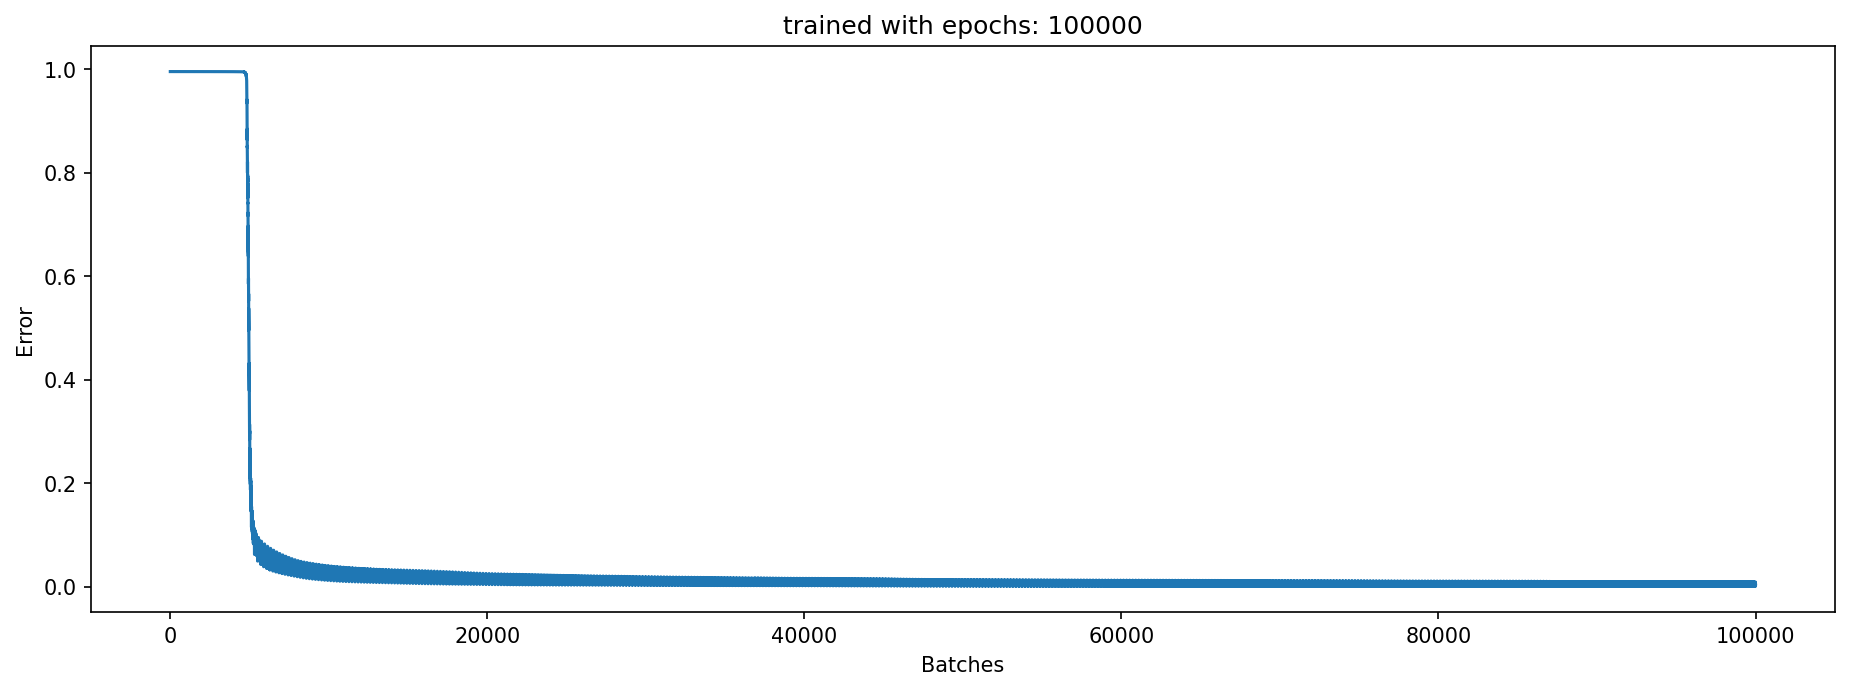

train 192000 batch_size 1000 correct 998.0 of 1000 Ratio 0.998 Error 0.004505856922932512
test 4000 batch_size 1000 correct 983.0 of 1000 Ratio 0.983 Error 0.028675179143743436
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6124554451210757
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.932                 0.326                0.514                 0.822
   1      2             0.903                 0.367                0.546                 0.807
   1      3             0.946                 0.325                0.564                 0.834
   1      4             0.951                 0.307                0.580                 0.834
   1      5             0.956                 0.292                0.588                 0.836
   1      6             0.956                 0.298                0.591                 0.836
 

   9      3             0.864                 0.788                0.873                 0.844
   9      4             0.885                 0.795                0.898                 0.859
   9      5             0.894                 0.791                0.906                 0.868
   9      6             0.882                 0.781                0.886                 0.859
   9      7             0.875                 0.770                0.865                 0.854
   9      8             0.875                 0.768                0.863                 0.854
   9      9             0.875                 0.768                0.863                 0.854
   9     10             0.875                 0.767                0.862                 0.854
  10      1             0.950                 0.645                0.913                 0.884
  10      2             0.926                 0.754                0.913                 0.886
  10      3             0.935                 0.73

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 1
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 2
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 2

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


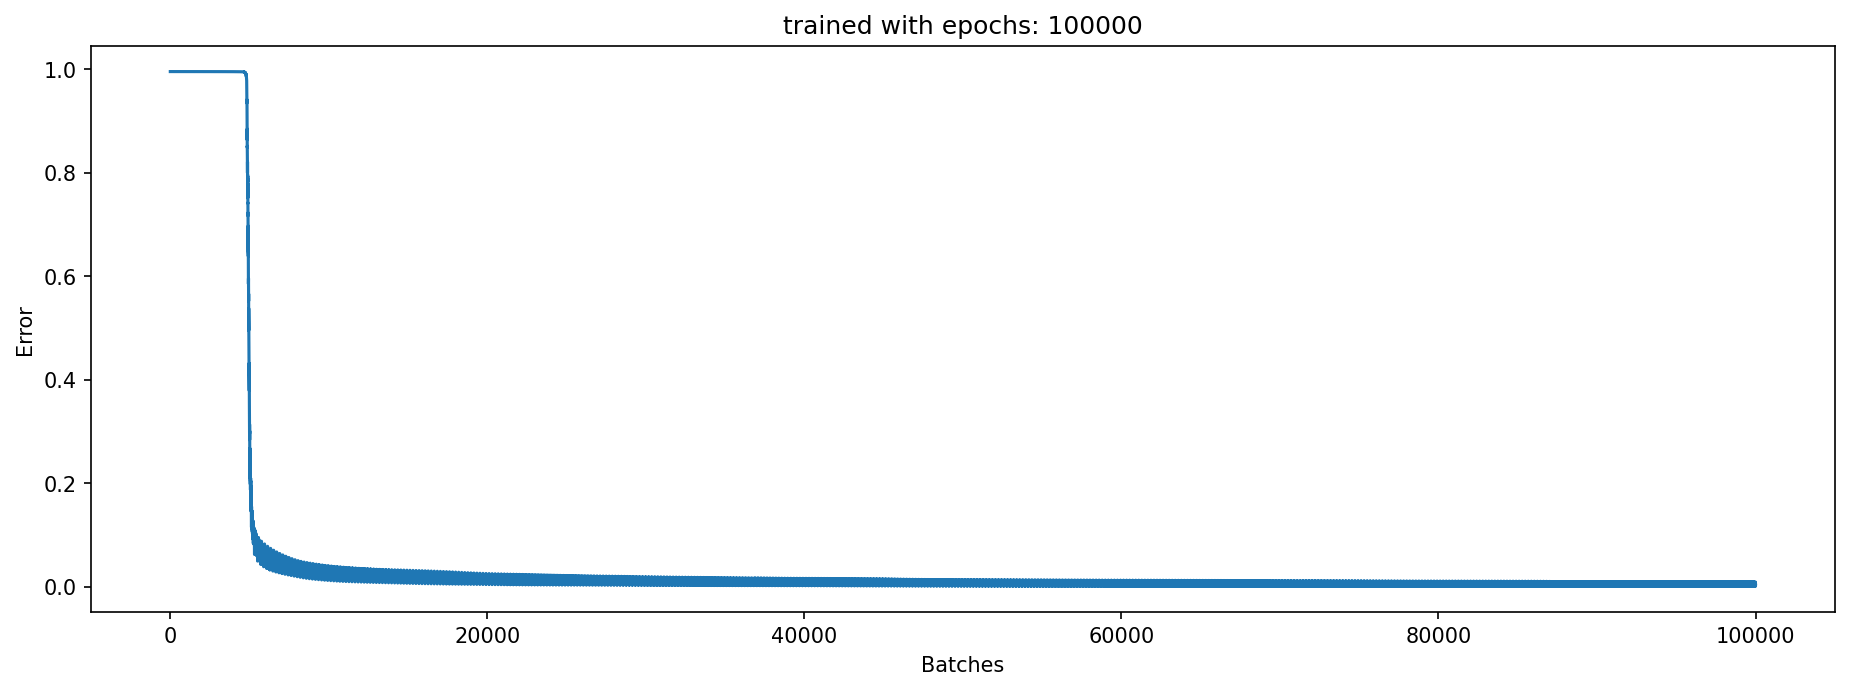

train 4000 batch_size 1000 correct 997.0 of 1000 Ratio 0.997 Error 0.005158933477048811
test 4000 batch_size 1000 correct 983.0 of 1000 Ratio 0.983 Error 0.028675179143743436
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6124554451210757
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.932                 0.326                0.514                 0.822
   2      1             0.951                 0.498                0.793                 0.870
   3      1             0.949                 0.489                0.790                 0.861
   4      1             0.924                 0.652                0.851                 0.874
   5      1             0.862                 0.663                0.810                 0.825
   6      1             0.892                 0.643                0.857                 0.839
   

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 1
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 2
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 2

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
loading pretrained NN2 failed: [Errno 2] No such file or directory: 'pickled_NN2_100000_64b_.pkl'


  0%|          | 0/100000 [00:00<?, ?it/s]

start 13:20:27


Err  0.011:   7%|▋         | 6703/100000 [05:18<1:13:46, 21.08it/s]

Interrupted by keyboard


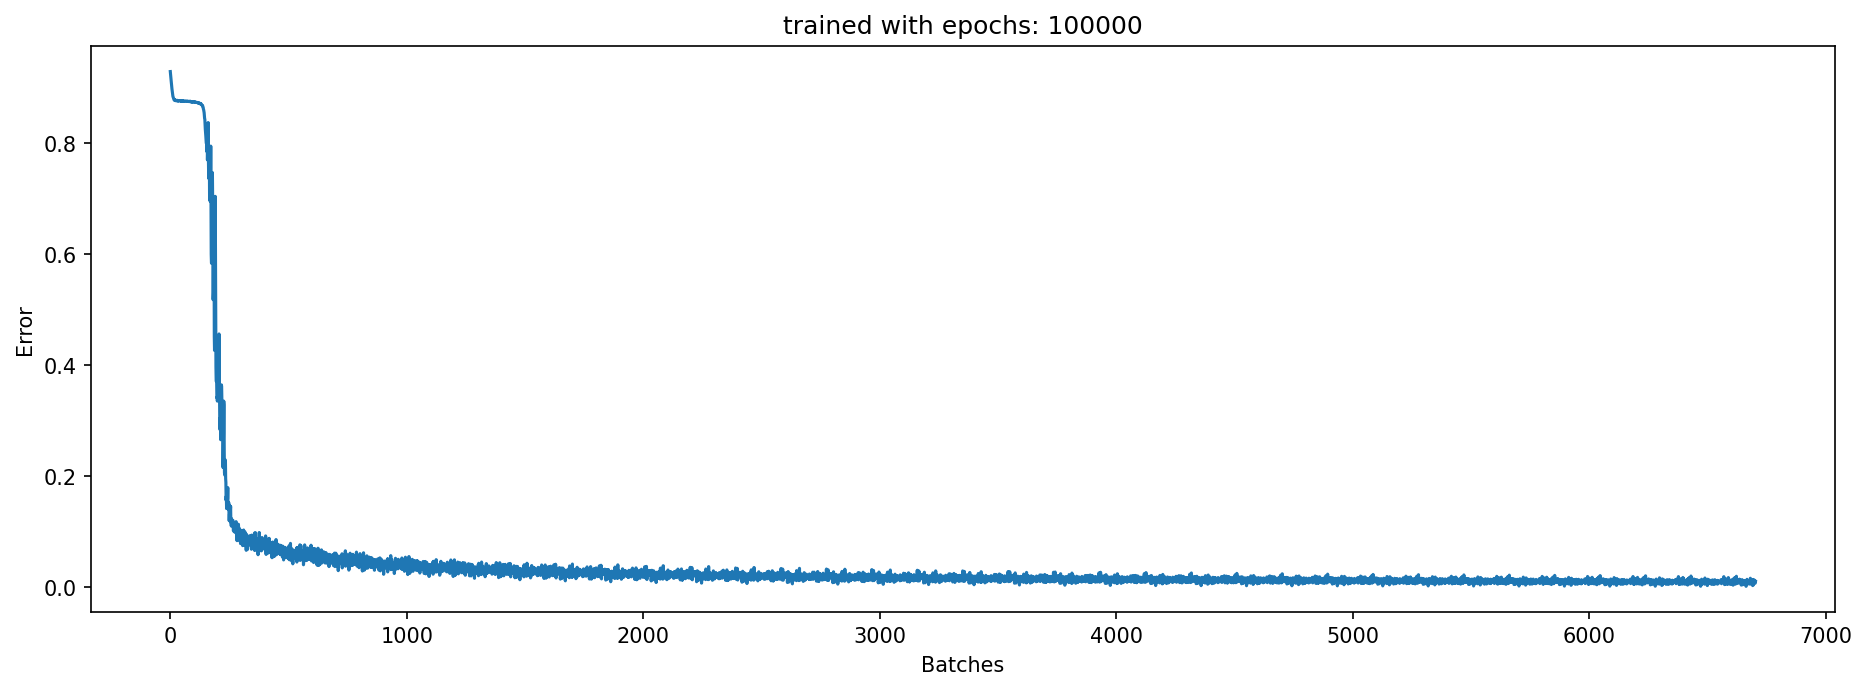

train 192000 batch_size 1000 correct 994.0 of 1000 Ratio 0.994 Error 0.011541553458482614
test 4000 batch_size 1000 correct 987.0 of 1000 Ratio 0.987 Error 0.022596860408348674
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.578455242822459
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
Interrupted


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 10 # (clipping to 1 was used for most tests)
clip_bias = 10
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
loading pretrained NN2 failed: [Errno 2] No such file or directory: 'pickled_NN2_100000_64b_.pkl'


  0%|          | 0/100000 [00:00<?, ?it/s]

start 13:27:07


Err  0.003: 100%|██████████| 100000/100000 [1:18:10<00:00, 21.32it/s]


end 14:45:18


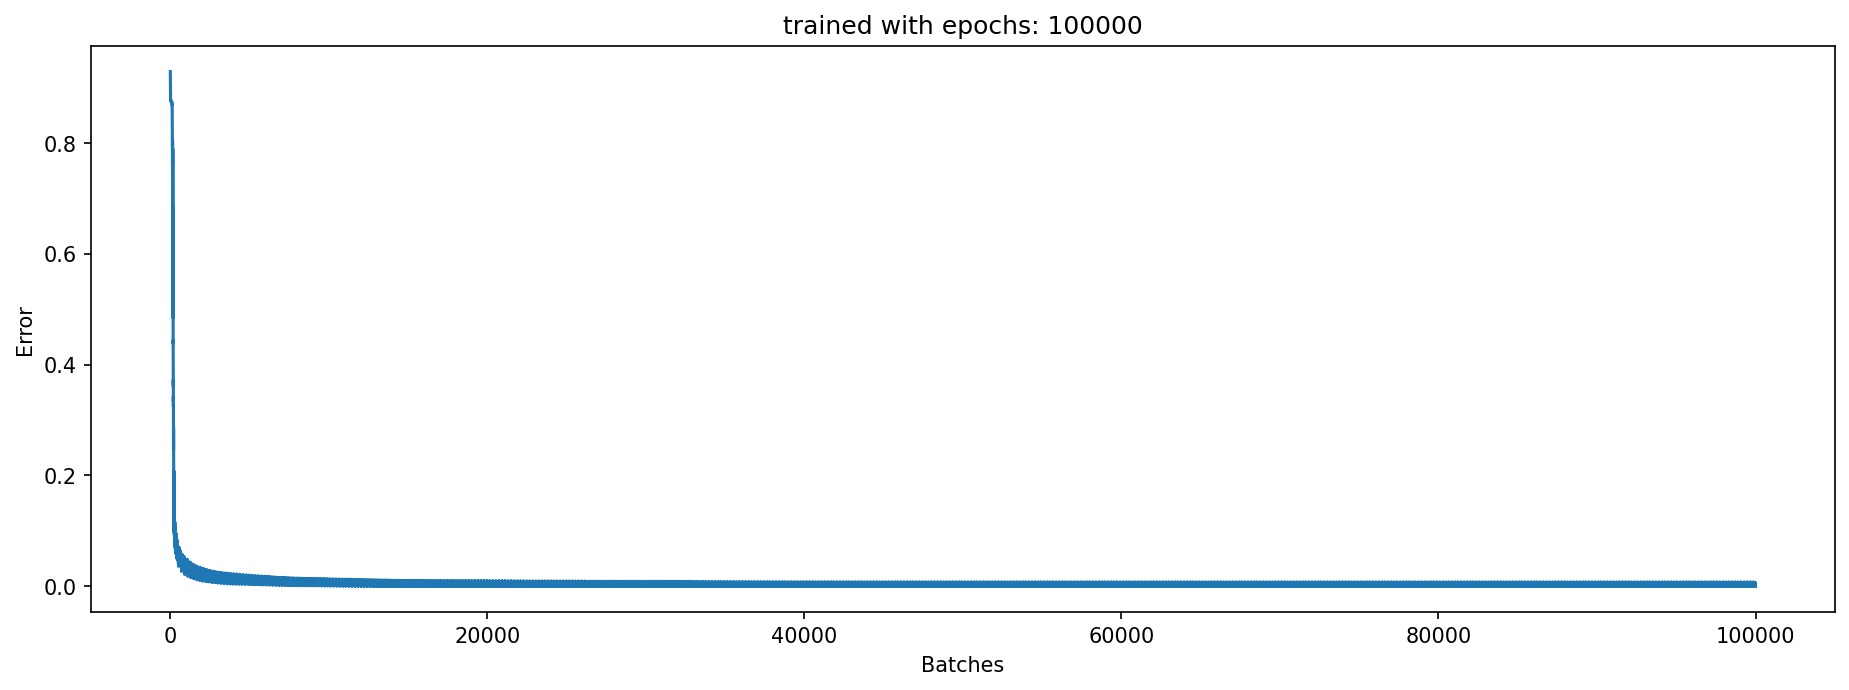

train 192000 batch_size 1000 correct 1000.0 of 1000 Ratio 1.0 Error 5.3834253509823675e-05
test 4000 batch_size 1000 correct 986.0 of 1000 Ratio 0.986 Error 0.023143092546207483
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.7219177566161679
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.788                 0.458                0.549                 0.724
   2      1             0.574                 0.650                0.698                 0.582
   3      1             0.846                 0.517                0.648                 0.782
   4      1             0.749                 0.625                0.812                 0.727
   5      1             0.627                 0.494                0.518                 0.598
   6      1             0.878                 0.501                0.580                 0.804


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 10 # (clipping to 1 was used for most tests)
clip_bias = 10
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  55050 dropped 0 real parameters 55050 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


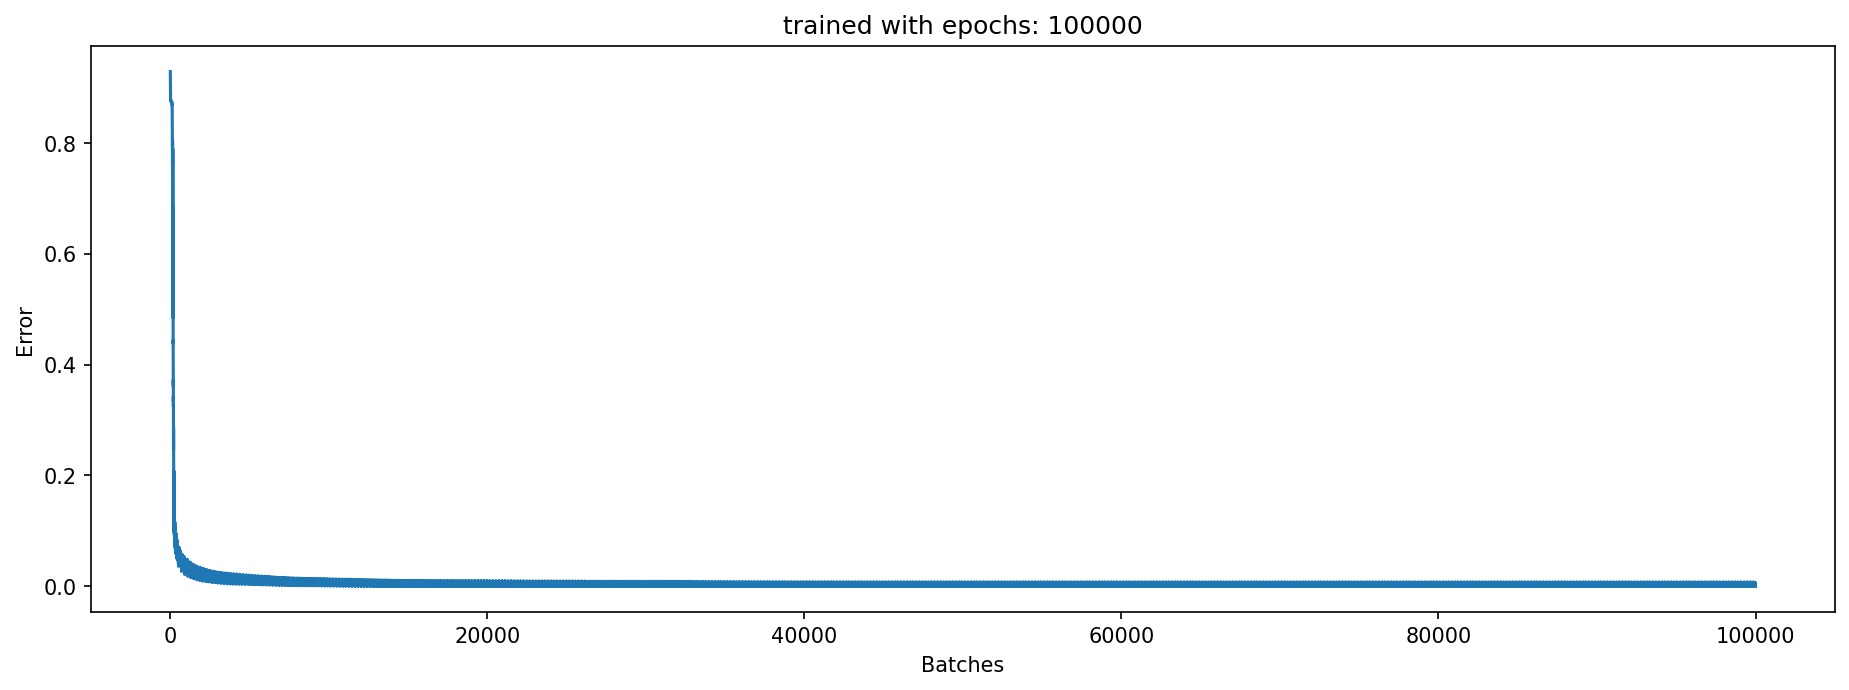

train 4000 batch_size 1000 correct 997.0 of 1000 Ratio 0.997 Error 0.005050777907905104
test 4000 batch_size 1000 correct 986.0 of 1000 Ratio 0.986 Error 0.023143092546207483
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.7219177566161679
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.788                 0.458                0.549                 0.724
   1      2             0.865                 0.394                0.615                 0.777
   1      3             0.883                 0.369                0.605                 0.784
   1      4             0.881                 0.365                0.602                 0.782
   1      5             0.881                 0.367                0.605                 0.782
   1      6             0.881                 0.363                0.601                 0.782
   

   9      3             0.730                 0.878                0.924                 0.748
   9      4             0.732                 0.879                0.925                 0.750
   9      5             0.732                 0.879                0.925                 0.751
   9      6             0.734                 0.879                0.925                 0.753
   9      7             0.735                 0.880                0.925                 0.753
   9      8             0.737                 0.880                0.924                 0.755
   9      9             0.737                 0.881                0.924                 0.756
   9     10             0.739                 0.881                0.924                 0.757
  10      1             0.835                 0.850                0.924                 0.828
  10      2             0.849                 0.862                0.926                 0.845
  10      3             0.850                 0.86

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 10 # (clipping to 1 was used for most tests)
clip_bias = 10
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
loading pretrained NN2 failed: [Errno 2] No such file or directory: 'pickled_NN2_100000_64b_pm.pkl'


  0%|          | 0/100000 [00:00<?, ?it/s]

start 15:35:13


Err  0.012: 100%|██████████| 100000/100000 [1:17:23<00:00, 21.54it/s]


end 16:52:36


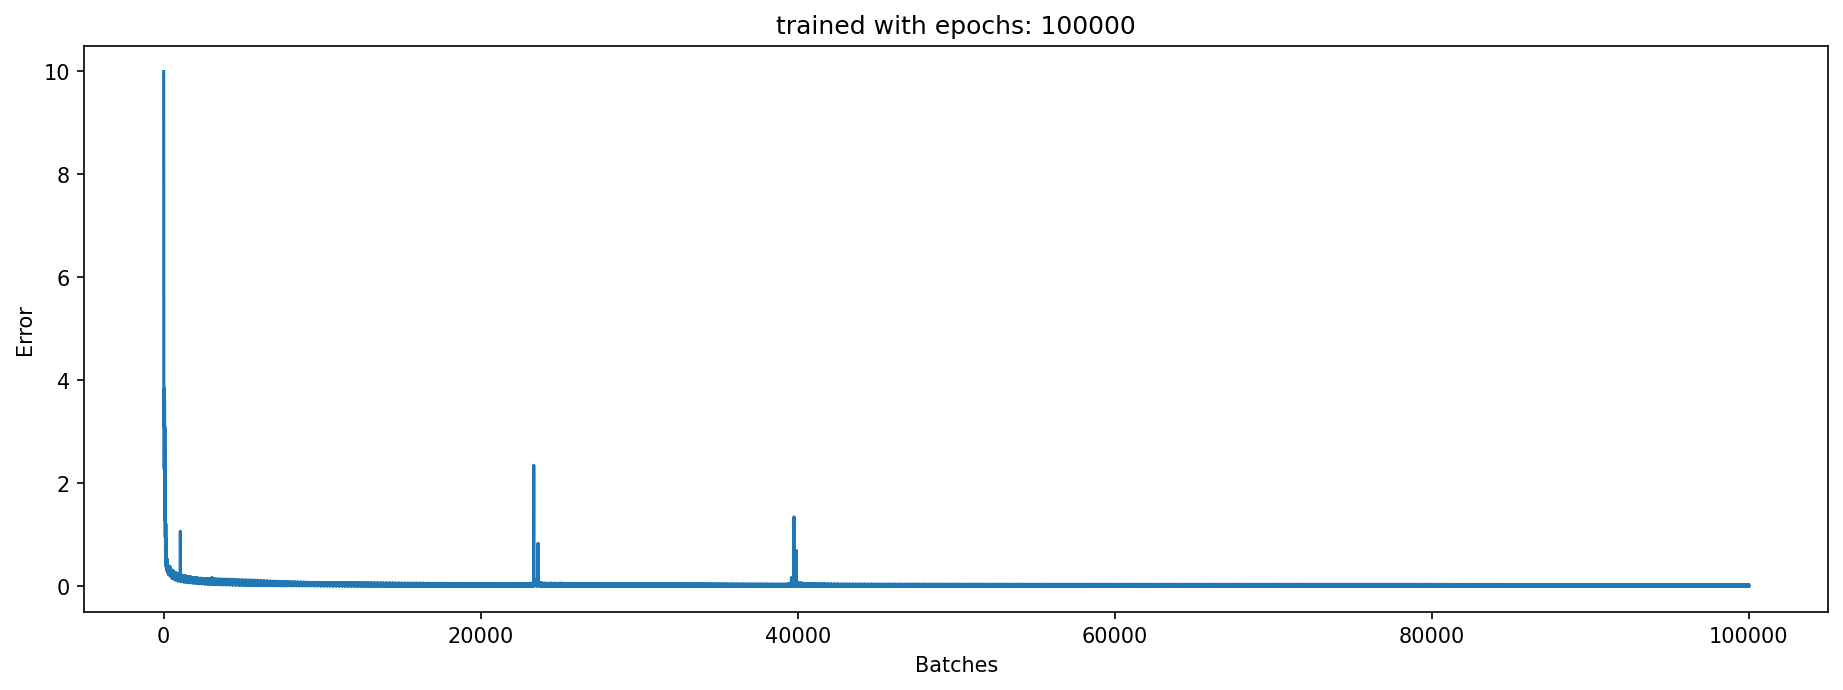

train 192000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.004273952863428304
test 4000 batch_size 1000 correct 988.0 of 1000 Ratio 0.988 Error 0.08812573206318067
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 1.0 of 1000 Ratio 0.001 Error 6.5497998286230885
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.314                 0.324                0.000                 0.327
Interrupted


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 0.2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 10 # (clipping to 1 was used for most tests)
clip_bias = 10
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = True

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 17:28:39


Err  0.002: 100%|██████████| 100000/100000 [1:19:02<00:00, 21.08it/s]


end 18:47:41


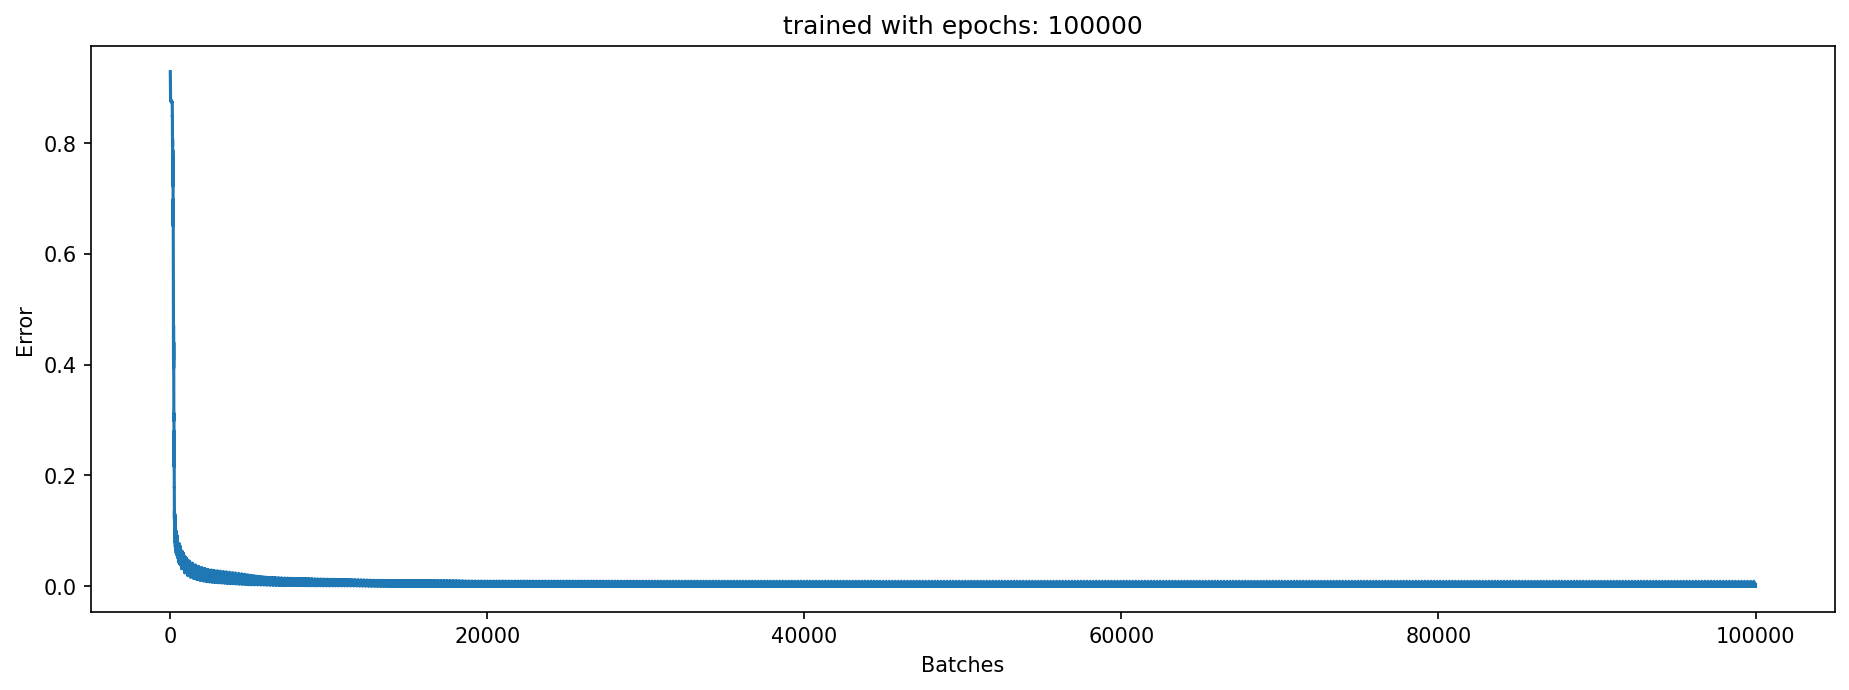

train 192000 batch_size 1000 correct 998.0 of 1000 Ratio 0.998 Error 0.0030402861734831633
test 4000 batch_size 1000 correct 992.0 of 1000 Ratio 0.992 Error 0.014377910939264927
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.7238174314247874
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.405                 0.334                0.610                 0.394
   2      1             0.343                 0.671                0.772                 0.397
   3      1             0.501                 0.427                0.571                 0.492
   4      1             0.315                 0.593                0.667                 0.363
   5      1             0.502                 0.624                0.758                 0.521
   6      1             0.385                 0.668                0.765                 0.431


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 10 # (clipping to 1 was used for most tests)
clip_bias = 10
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  55050 dropped 0 real parameters 55050 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


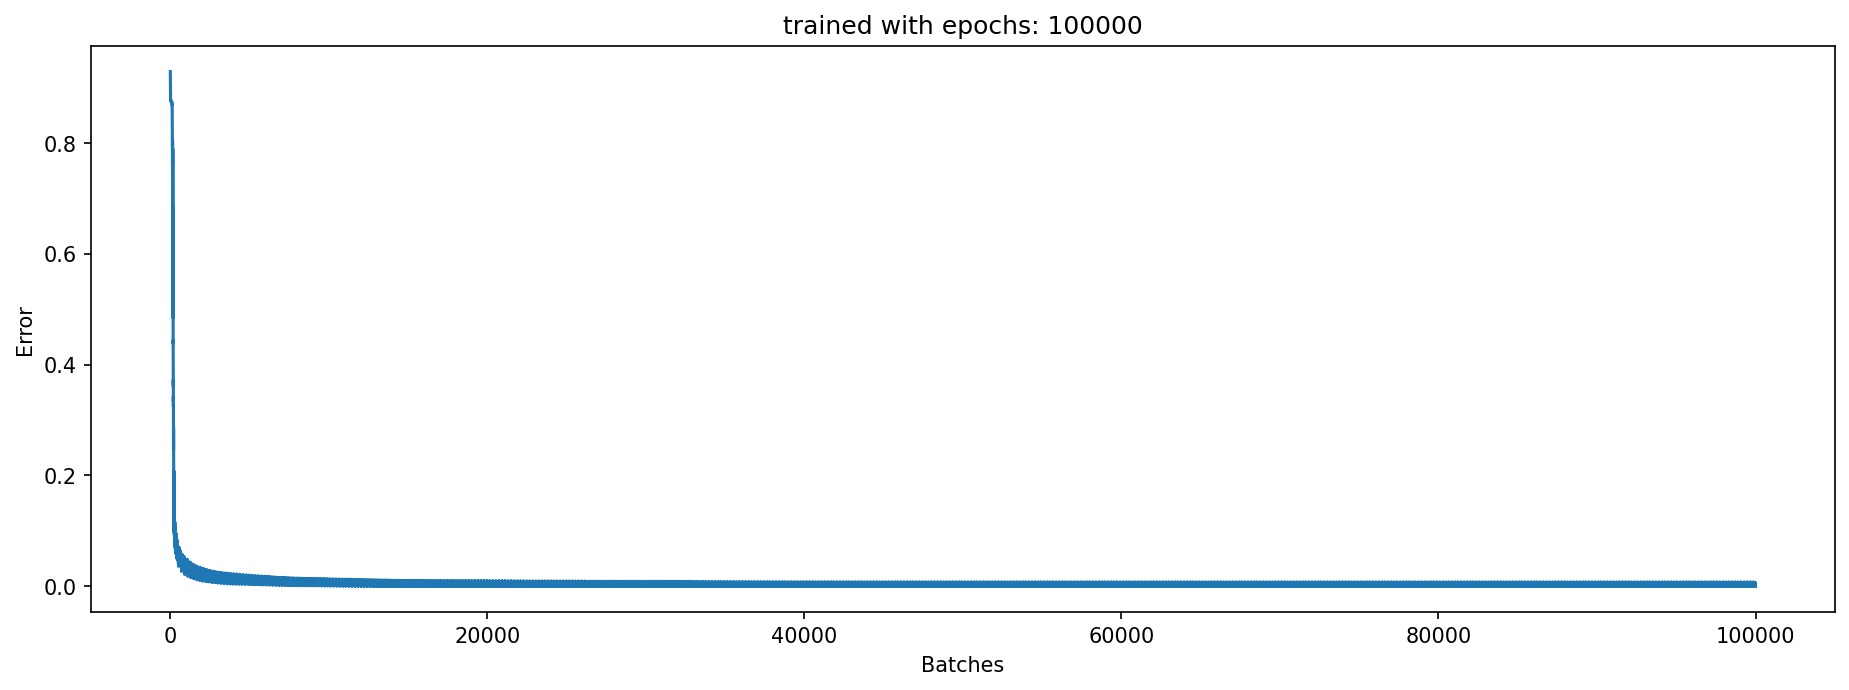

train 4000 batch_size 1000 correct 997.0 of 1000 Ratio 0.997 Error 0.005050777907905104
test 4000 batch_size 1000 correct 986.0 of 1000 Ratio 0.986 Error 0.023143092546207483
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.7219177566161679
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.881                 0.537                0.704                 0.825
   2      1             0.834                 0.530                0.612                 0.771
   3      1             0.929                 0.460                0.574                 0.841
   4      1             0.907                 0.599                0.741                 0.851
   5      1             0.756                 0.532                0.562                 0.714
   6      1             0.948                 0.612                0.782                 0.888
   

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 10 # (clipping to 1 was used for most tests)
clip_bias = 10
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 19:35:05


Err  0.002:  27%|██▋       | 26993/100000 [21:22<57:48, 21.05it/s]  


Interrupted by keyboard


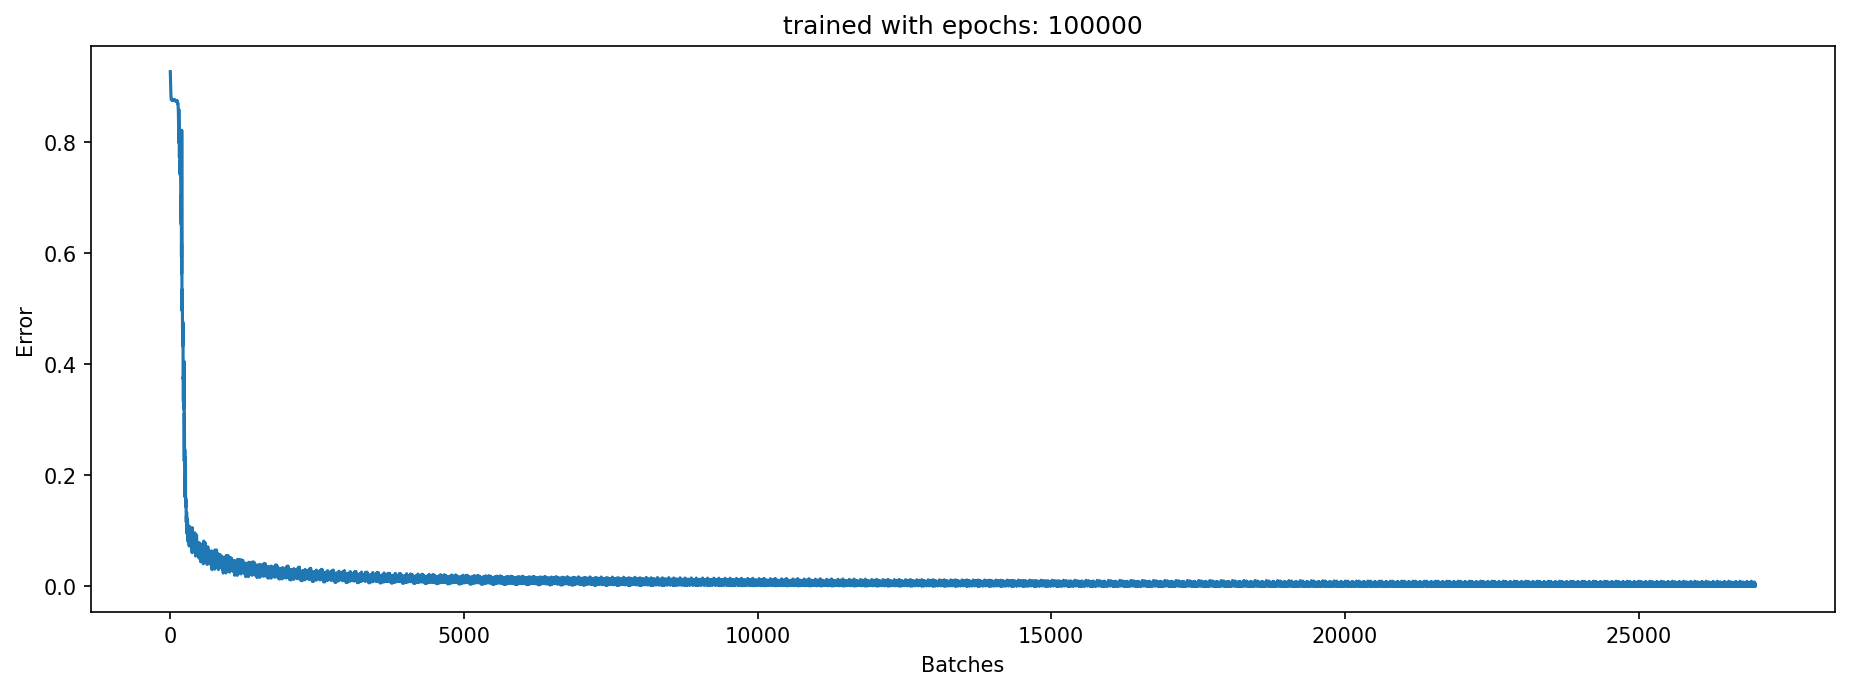

train 192000 batch_size 1000 correct 1000.0 of 1000 Ratio 1.0 Error 0.00025657740016597145
test 4000 batch_size 1000 correct 989.0 of 1000 Ratio 0.989 Error 0.02169706132703008
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.7014531830667634
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.867                 0.499                0.765                 0.809
   2      1             0.848                 0.658                0.794                 0.813
   3      1             0.874                 0.643                0.794                 0.829
   4      1             0.843                 0.641                0.760                 0.807
   5      1             0.826                 0.752                0.849                 0.806
   6      1             0.922                 0.688                0.830                 0.864
 

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 10 # (clipping to 1 was used for most tests)
clip_bias = 10
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  55050 dropped 0 real parameters 55050 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


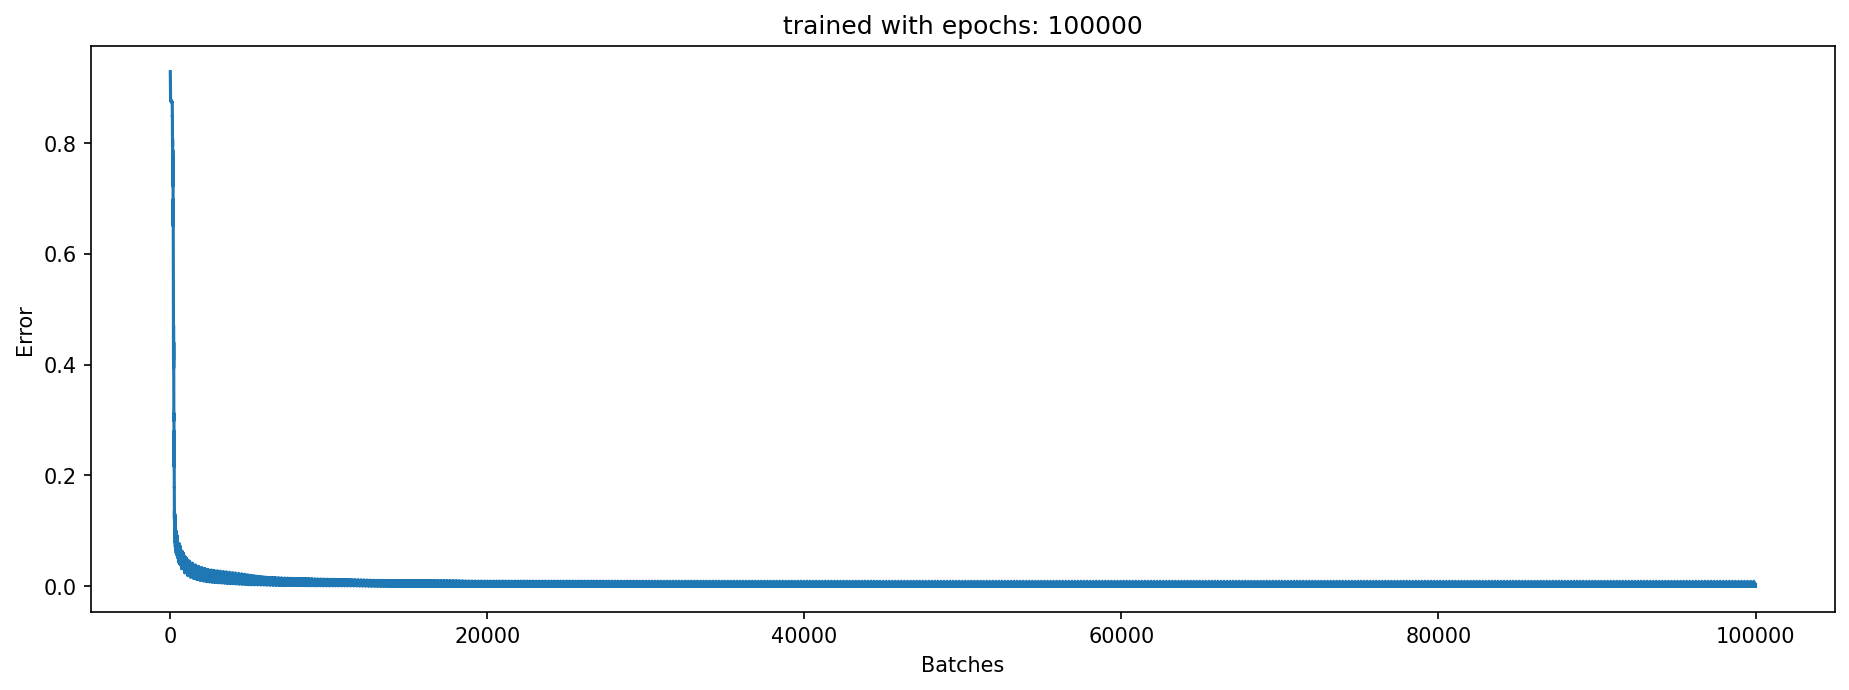

train 4000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.002029389004399947
test 4000 batch_size 1000 correct 992.0 of 1000 Ratio 0.992 Error 0.014377910939264927
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.7238174314247874
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.929                 0.399                0.555                 0.832
   2      1             0.929                 0.479                0.569                 0.841
   3      1             0.963                 0.384                0.602                 0.854
   4      1             0.958                 0.563                0.685                 0.877
   5      1             0.930                 0.716                0.832                 0.889
   6      1             0.939                 0.706                0.833                 0.898
   

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 10 # (clipping to 1 was used for most tests)
clip_bias = 10
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

We test standard sigmoid function with bias here. This would need less explanation in a paper, as it is the standard way it is done

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 13:55:03


Err  0.004: 100%|██████████| 100000/100000 [1:18:01<00:00, 21.36it/s]


end 15:13:04


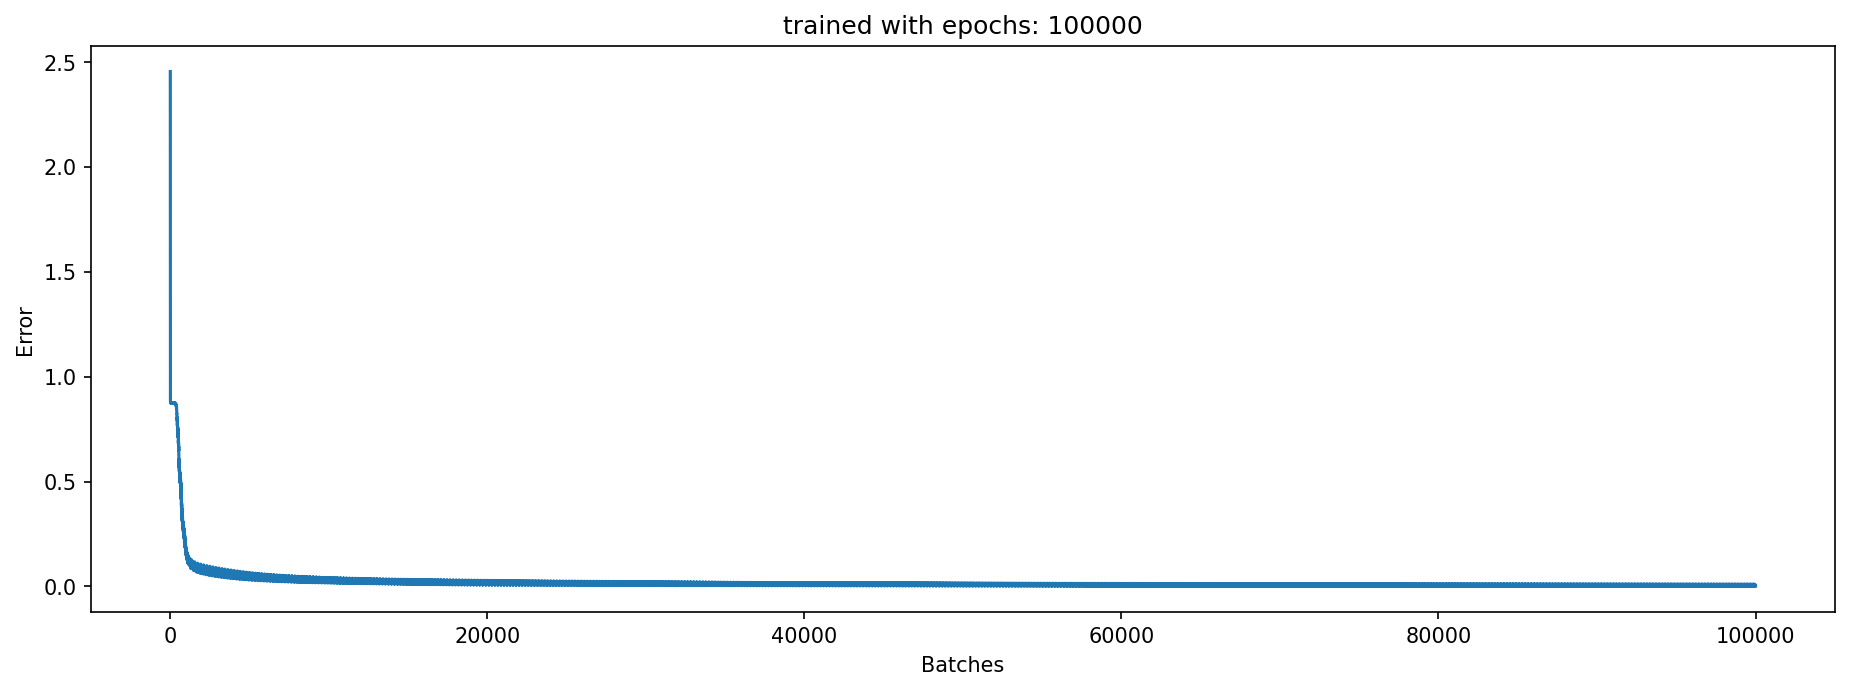

train 192000 batch_size 1000 correct 998.0 of 1000 Ratio 0.998 Error 0.0032380471569709995
test 4000 batch_size 1000 correct 983.0 of 1000 Ratio 0.983 Error 0.028179445633188756
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.636700503873349
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.938                 0.324                0.688                 0.839
   2      1             0.884                 0.453                0.597                 0.806
   3      1             0.930                 0.483                0.720                 0.853
   4      1             0.914                 0.518                0.700                 0.844
   5      1             0.926                 0.573                0.734                 0.868
   6      1             0.942                 0.603                0.750                 0.887
 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 10 # (clipping to 1 was used for most tests)
clip_bias = 10
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 1
shift_sigmoid = 0

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 15:27:35


Err  0.006: 100%|██████████| 100000/100000 [1:18:45<00:00, 21.16it/s]


end 16:46:21


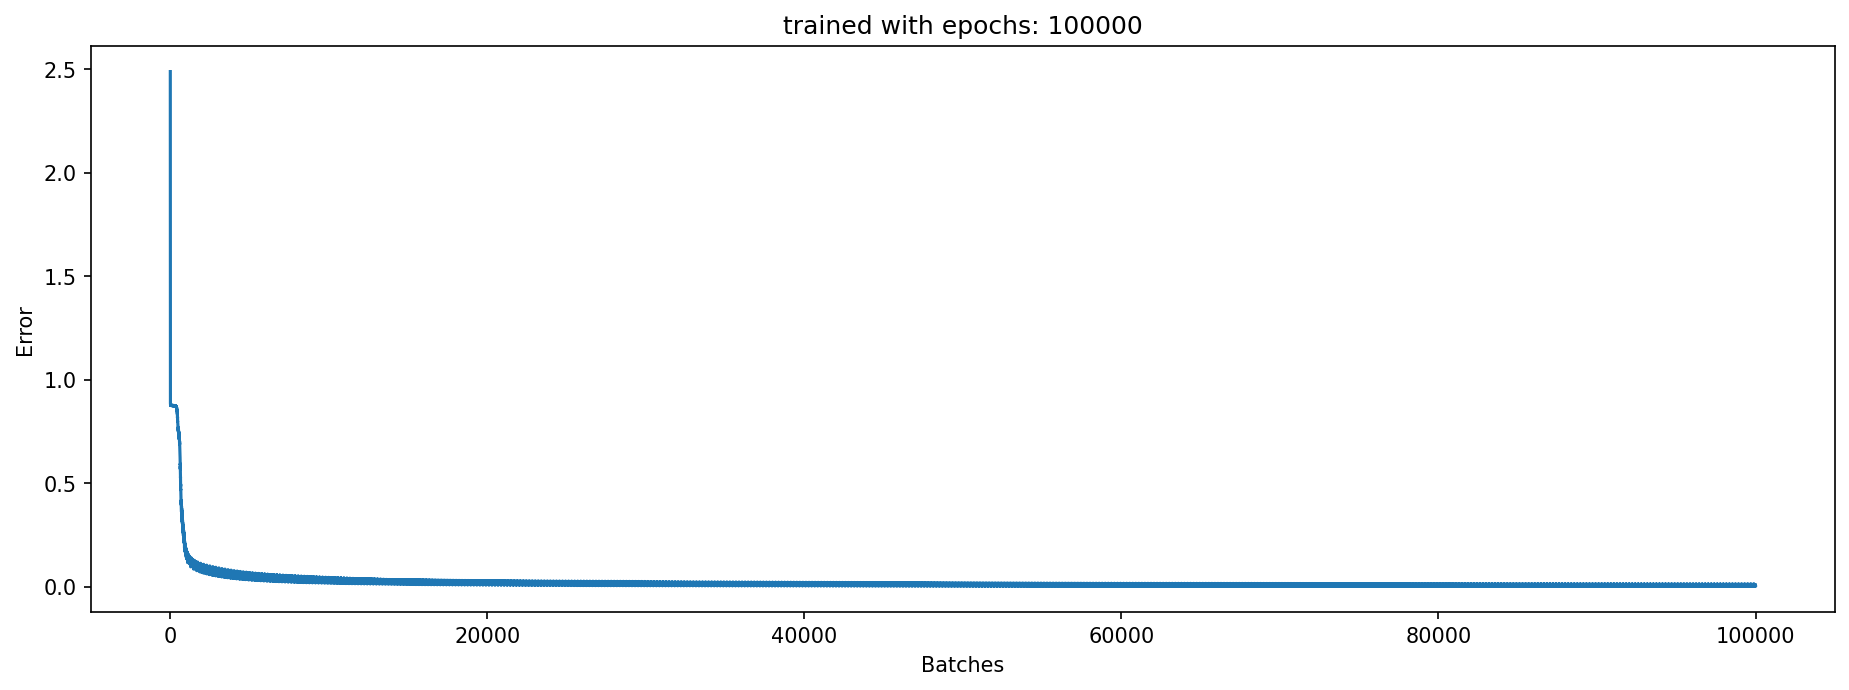

train 192000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.004099357403960843
test 4000 batch_size 1000 correct 989.0 of 1000 Ratio 0.989 Error 0.020970348770255352
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.572603006245687
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.921                 0.359                0.684                 0.819
   2      1             0.834                 0.501                0.624                 0.776
   3      1             0.896                 0.522                0.700                 0.826
   4      1             0.866                 0.550                0.710                 0.812
   5      1             0.897                 0.595                0.713                 0.848
   6      1             0.894                 0.624                0.759                 0.845
  

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 1
shift_sigmoid = 0

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 16:58:04


Err  0.002: 100%|██████████| 100000/100000 [1:18:44<00:00, 21.17it/s]


end 18:16:48


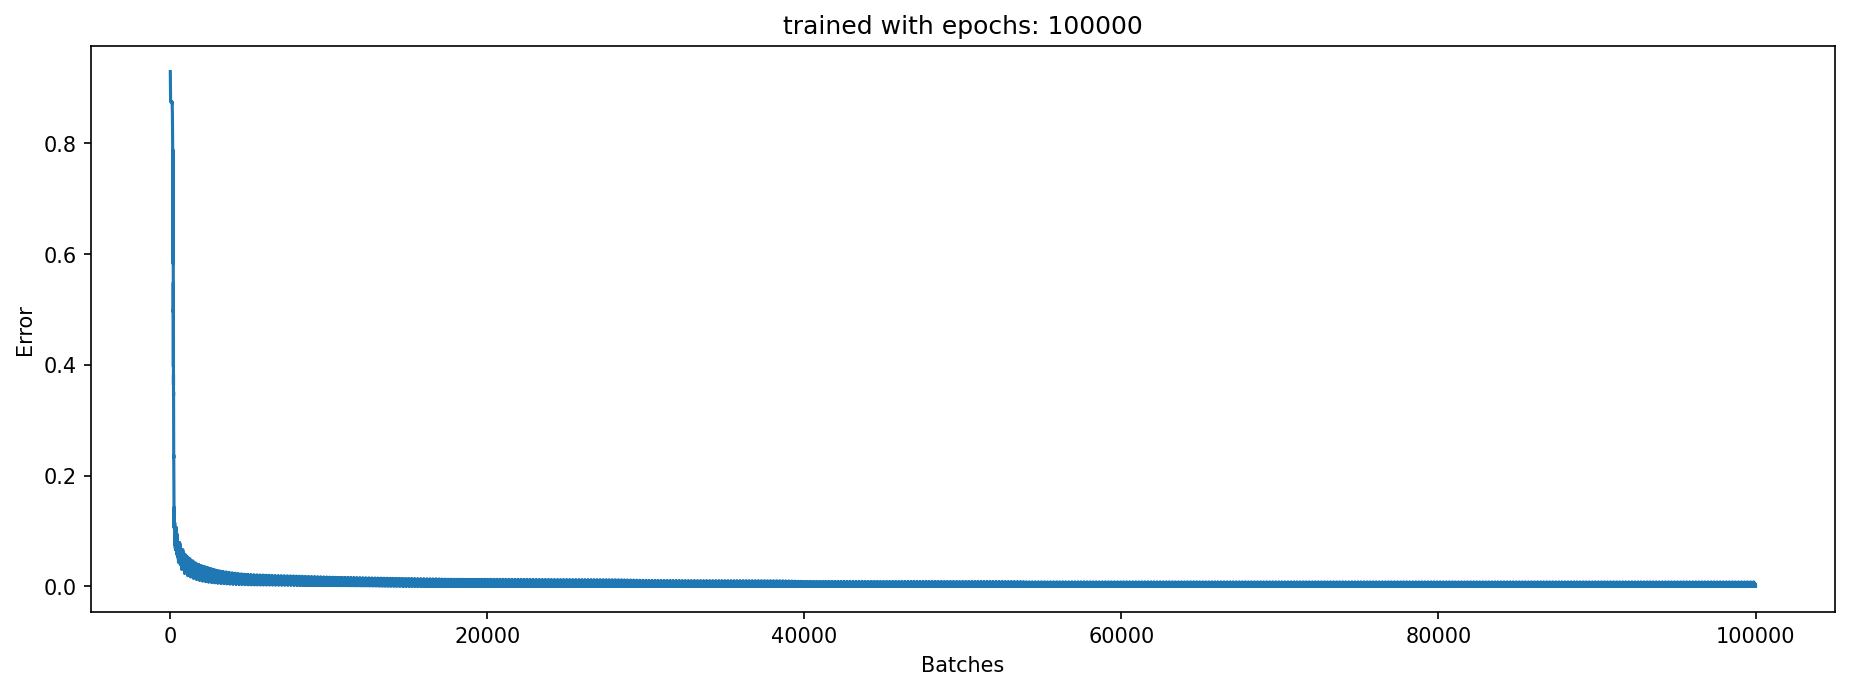

train 192000 batch_size 1000 correct 1000.0 of 1000 Ratio 1.0 Error 7.572789093288078e-05
test 4000 batch_size 1000 correct 990.0 of 1000 Ratio 0.99 Error 0.020012664793907318
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.7437644395071044
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.848                 0.498                0.738                 0.787
   2      1             0.733                 0.643                0.750                 0.730
   3      1             0.924                 0.354                0.546                 0.829
   4      1             0.888                 0.653                0.857                 0.855
   5      1             0.853                 0.790                0.880                 0.843
   6      1             0.936                 0.693                0.939                 0.888
  

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = True

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 18:24:16


Err  0.001: 100%|██████████| 100000/100000 [1:18:45<00:00, 21.16it/s]


end 19:43:01


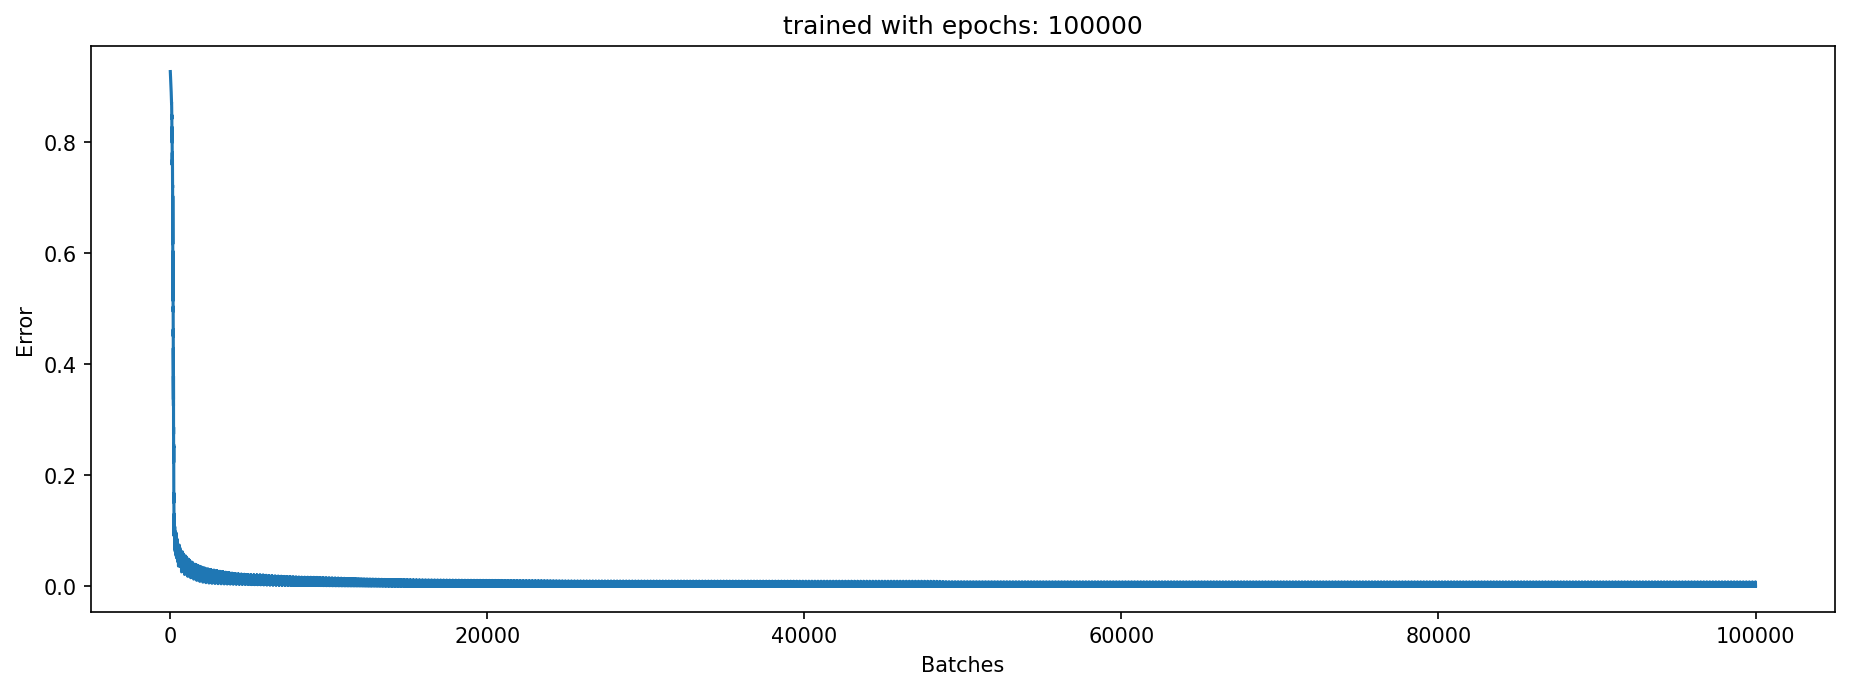

train 192000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.0010754819409125411
test 4000 batch_size 1000 correct 988.0 of 1000 Ratio 0.988 Error 0.021056918873598056
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6712685905211537
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.911                 0.618                0.814                 0.853
   2      1             0.857                 0.724                0.849                 0.825
   3      1             0.963                 0.434                0.638                 0.864
   4      1             0.936                 0.579                0.834                 0.864
   5      1             0.916                 0.691                0.771                 0.873
   6      1             0.953                 0.677                0.857                 0.898


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

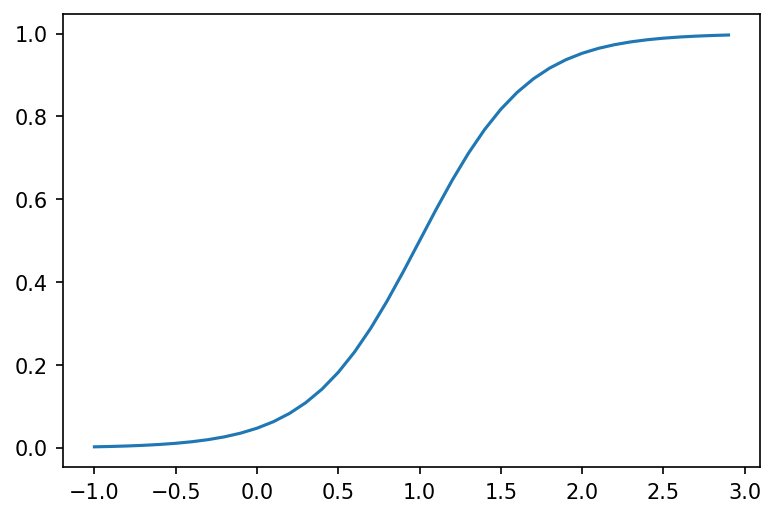

In [7]:
x = []
y = []
for xx in np.arange(-1,3,0.1):
    x.append(xx)
    y.append(sigmoid(xx))
pyplot.plot(x,y)
pyplot.show()

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


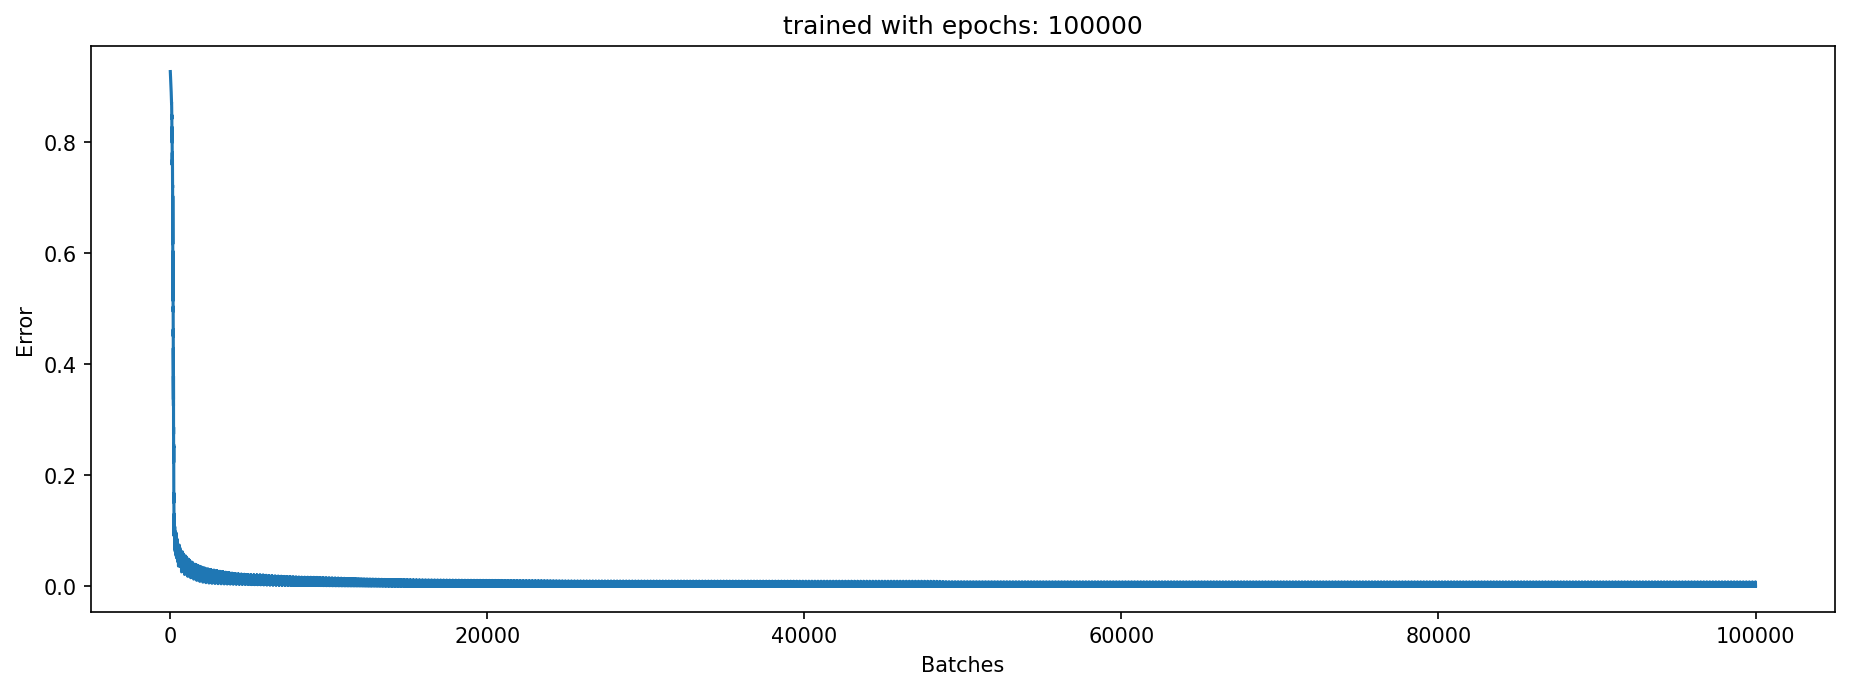

train 4000 batch_size 1000 correct 998.0 of 1000 Ratio 0.998 Error 0.004085598429564069
test 4000 batch_size 1000 correct 988.0 of 1000 Ratio 0.988 Error 0.021056918873598056
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6712685905211537
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.866                 0.601                0.737                 0.822
   2      1             0.846                 0.701                0.829                 0.816
   3      1             0.909                 0.503                0.734                 0.828
   4      1             0.872                 0.799                0.893                 0.854
   5      1             0.895                 0.766                0.882                 0.871
   6      1             0.904                 0.739                0.893                 0.868
   

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 3
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


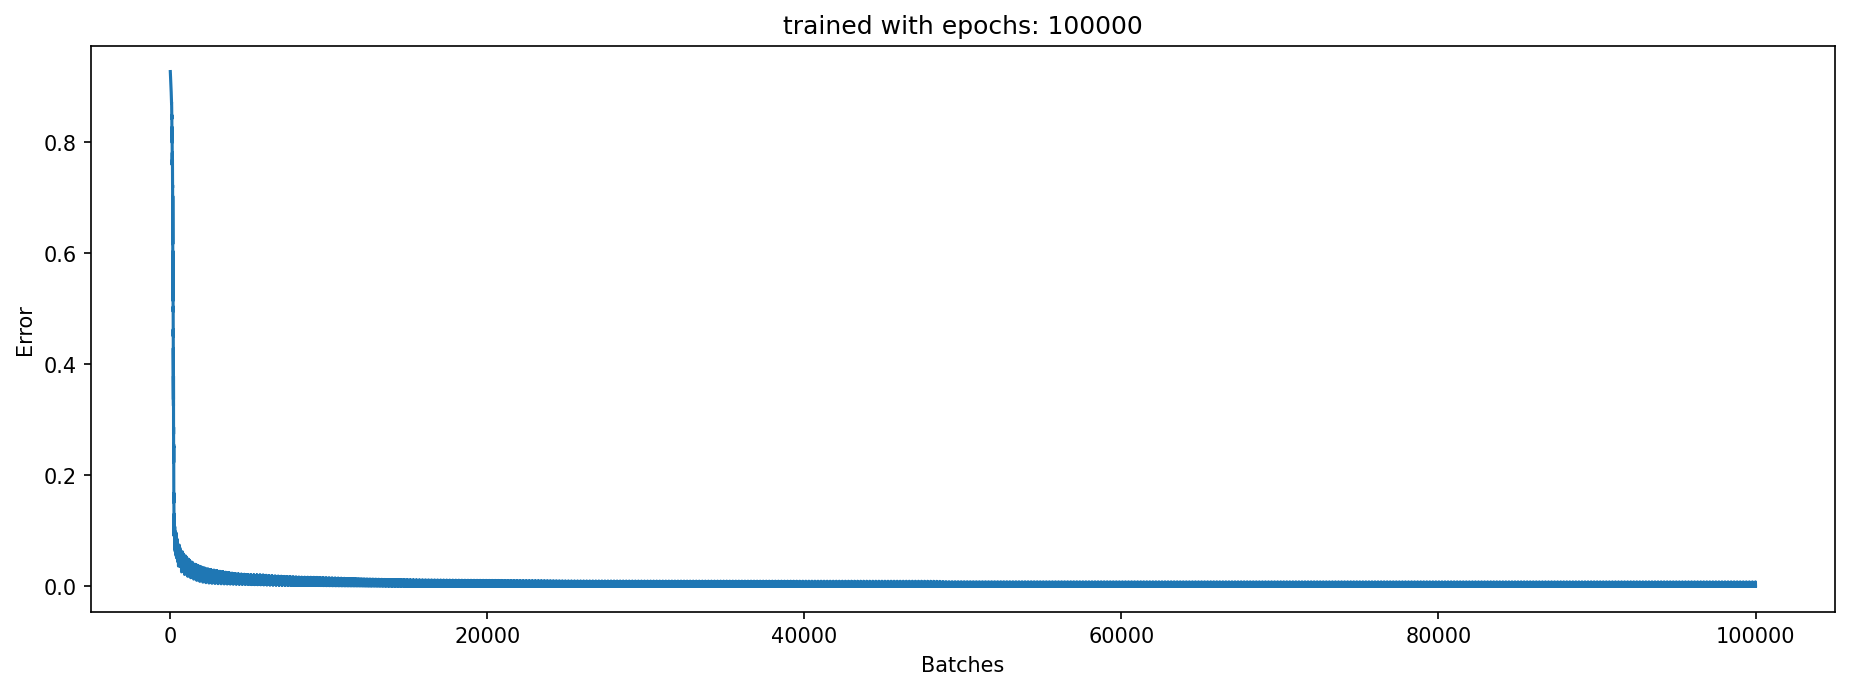

train 4000 batch_size 1000 correct 998.0 of 1000 Ratio 0.998 Error 0.004085598429564069
test 4000 batch_size 1000 correct 988.0 of 1000 Ratio 0.988 Error 0.021056918873598056
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6712685905211537
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.904                 0.650                0.749                 0.849
   2      1             0.931                 0.500                0.665                 0.848
   3      1             0.814                 0.716                0.862                 0.794
   4      1             0.953                 0.488                0.612                 0.869
   5      1             0.947                 0.783                0.907                 0.908
   6      1             0.944                 0.780                0.904                 0.904
   

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 2
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


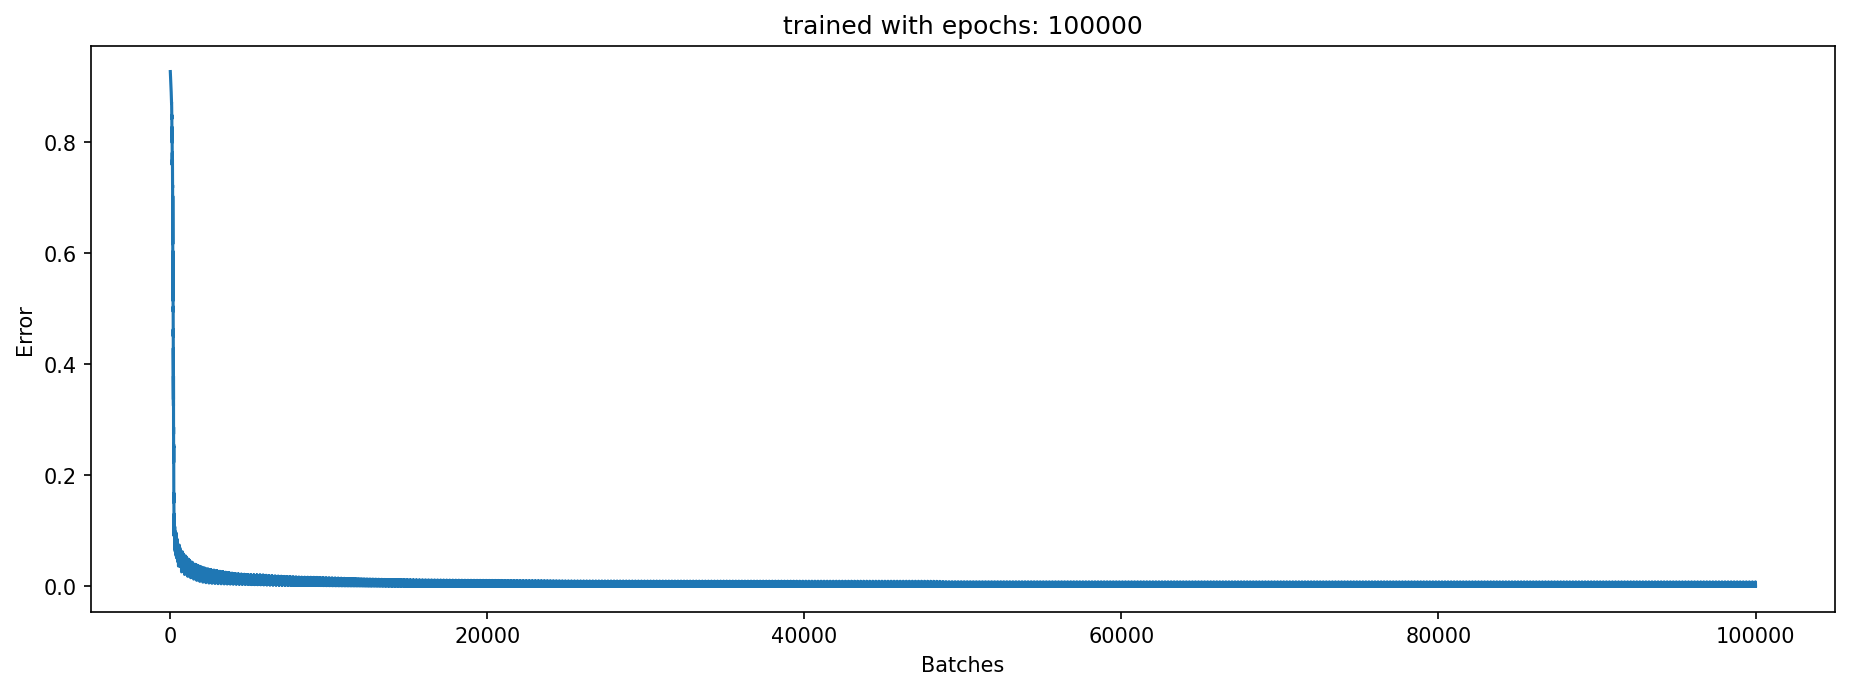

train 4000 batch_size 1000 correct 998.0 of 1000 Ratio 0.998 Error 0.004085598429564069
test 4000 batch_size 1000 correct 988.0 of 1000 Ratio 0.988 Error 0.021056918873598056
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6712685905211537
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.442                 0.503                0.517                 0.448
   2      1             0.443                 0.492                0.517                 0.449
   3      1             0.446                 0.507                0.528                 0.455
   4      1             0.455                 0.616                0.623                 0.491
   5      1             0.652                 0.784                0.830                 0.671
   6      1             0.793                 0.838                0.922                 0.797
   

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 1
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


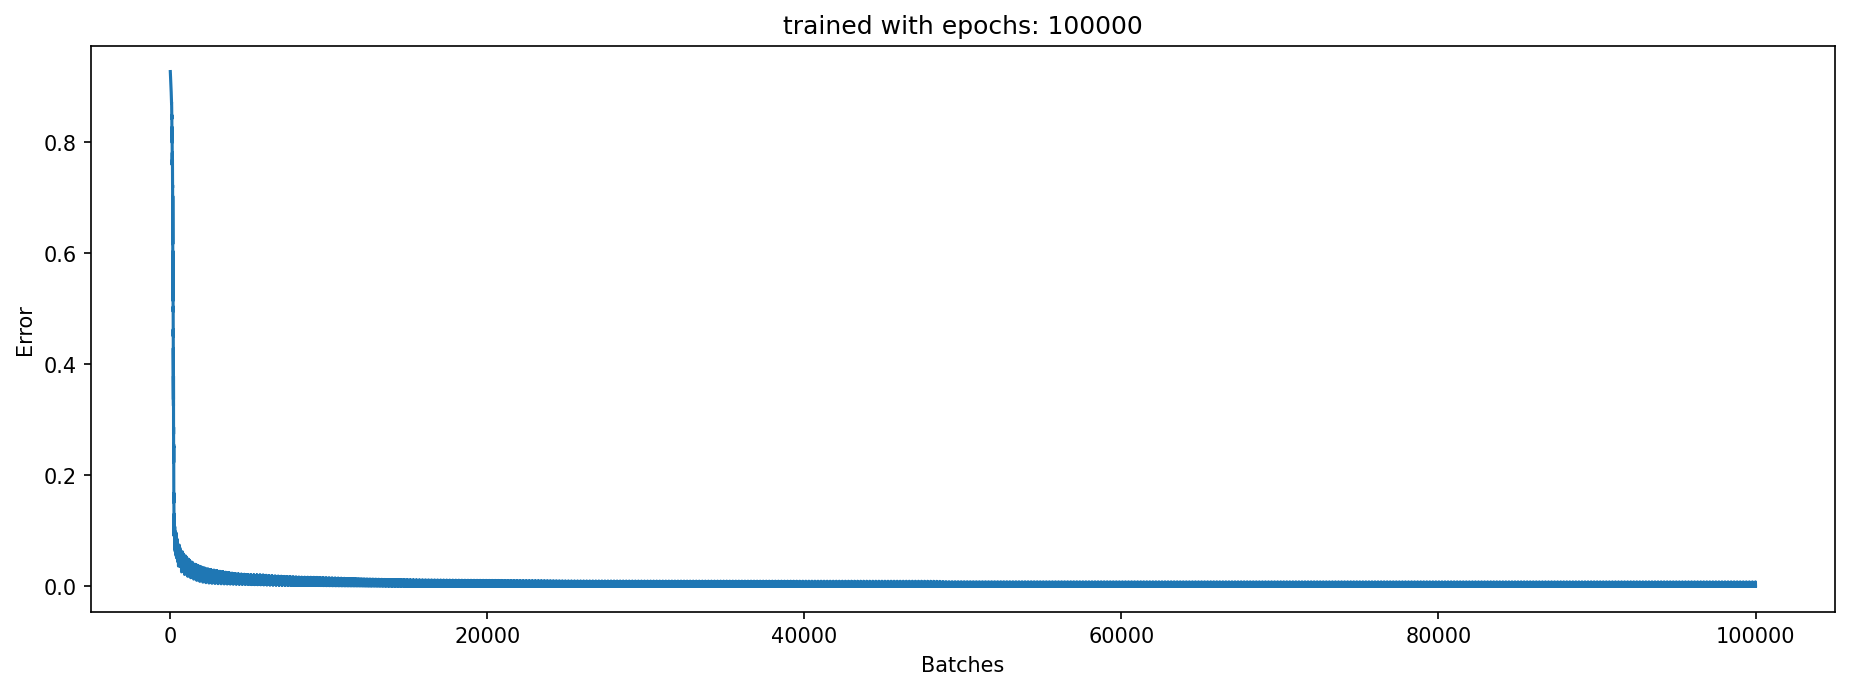

train 4000 batch_size 1000 correct 998.0 of 1000 Ratio 0.998 Error 0.004085598429564069
test 4000 batch_size 1000 correct 988.0 of 1000 Ratio 0.988 Error 0.021056918873598056
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6712685905211537
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
Interrupted


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 1
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

In [2]:
import numpy as np
x = []
y = []
for xx in np.arange(-1,3,0.1):
    x.append(xx)
    y.append(sigmoid(xx))
pyplot.plot(x,y)
pyplot.savefig('sigmoid_shifted.png')

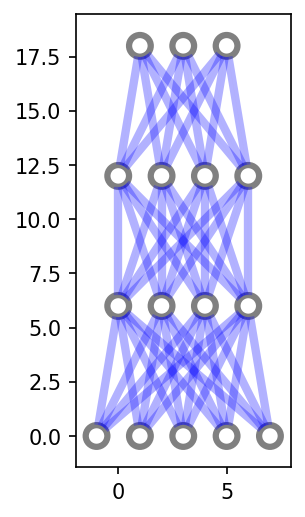

In [5]:
hidden_size = 4
inputs= np.array([[0,0,0,0,0]])
num_outputs = 3
outputs= np.array([[0,0,0]])
NN2 = setup_net()
NN2.set_input(inputs[0],outputs[0])
NN2.forward()
NN2.draw()

In [5]:
%%writefile _code_.py 
# uncomment line before to run in jupyter notebook with command after constant definition


NN2_file_identifier = '_' + str(do_batch_training) + '_' + str(hidden_size) # used for the pickle file to reload pretrained files with different parameters

if use_bias:
    NN2_file_identifier += 'b_'
if do_pm:
    NN2_file_identifier += 'pm'
    
if few_shot_more_at_once != 1:
    print('Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!')
if load_mnist:
    print('labels (last two are used for few_shot)', all_labels)
    
#np.seterr(under='ignore', over='ignore')

def sigmoid(x):
    if do_pm:
        return np.tanh(x)
    xx = scale_sigmoid * (x - shift_sigmoid)
    return 1 / (1 + np.exp(-xx)) #* 2 -1

def sigmoid_derivative(x):
    if do_pm:
        return 1-np.tanh(x)**2
    xx = scale_sigmoid * (x - shift_sigmoid)
    return scale_sigmoid * (np.exp(-xx) / (np.exp(-xx) + 1) ** 2)

def transform_01_mp(x):
    return 2*x - 1

def run_load_mnist(show_msg = True, use_test = False, limit_labels = None, only_load_num = None):
    #global inputs, outputs, bbs
    # simelar to https://www.python-course.eu/neural_network_mnist.php
    #image_size = 28 # width and length
    #no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
    #image_pixels = image_size * image_size
    if not load_mnist:
        print('This should not happen!!')
    data_path = "test_few_shot/data/mnist/" # makes it possible to use kernel from jupyter notebook
    
    # speedup loading
    fac = 0.99 / 255
    if not use_emnist:
        try:
            with open(data_path + "pickled_mnist.pkl", "br") as fh:
                (train_data, test_data) = pickle.load(fh)
        except:
            train_data = np.loadtxt(data_path + "mnist_train.csv", 
                                    delimiter=",")
            test_data = np.loadtxt(data_path + "mnist_test.csv", 
                               delimiter=",") 
            with open(data_path + "pickled_mnist.pkl", "bw") as fh:
                pickle.dump((train_data, test_data), fh)
                
        
        if use_test:
            used_imgs = np_array(test_data[:, 1:]) * fac + 0.01
            dataset_name = 'Test dataset'
            used_labels = np_array(test_data[:, :1])
        else:
            used_imgs = np_array(train_data[:, 1:]) * fac + 0.01
            dataset_name = 'Train dataset'
            used_labels = np_array(train_data[:, :1])
    else:
        if use_test:
            dataset_name = 'Test dataset'
            (used_imgs, used_labels) = extract_test_samples('digits')
        else:
            dataset_name = 'Train dataset'
            (used_imgs, used_labels) = extract_training_samples('digits')
        used_imgs = np_array(used_imgs.reshape(-1, 28*28)) * fac + 0.01
        used_labels = used_labels.reshape(-1,1)
        
    if limit_labels is not None:
        new_imgs = []
        new_labels = []
        for i in range(len(used_labels)):
            if int(used_labels[i][0]) in limit_labels:
                new_imgs.append(used_imgs[i].tolist())
                new_labels.append(used_labels[i].tolist())
                if only_load_num is not None and len(new_labels) >= only_load_num:
                    break
        used_imgs = np_array(new_imgs)
        used_labels = np_array(new_labels)
    
    
    if num_outputs == 1:
        used_labels = np.around(1 - np.sign(np.abs(used_labels - label_to_one)))
    elif num_outputs == 10:
        label_transform = np.zeros((10, 10), int)
        np.fill_diagonal(label_transform, 1)
        label_transform = label_transform.tolist()
        used_labels = [label_transform[int(np.around(x[0]))] for x in used_labels]
        used_labels = np_array(used_labels)
#        raise Exception('not yet implementd')
    else:
        raise Exception('not yet implementd')

    inputs = used_imgs[:first_n_to_use]     
    outputs = used_labels[:first_n_to_use]
    bbs = ''
    for l in np.around(outputs):
        bbs += str(int(l[0]))
    if show_msg:
        if num_outputs == 10:
            if verbose > 0:
                print('loaded mnist', dataset_name,' with 10 labels', limit_labels)
        else:
            print('loaded mnist', dataset_name,' with output labels ',label_to_one,' resulting in learning labels', bbs[:10], '....')
    if len(bbs) > 50:
        bbs = 'to long to plot'
    if do_pm:
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)
    return (inputs, outputs, bbs)


if load_mnist:
    (inputs, outputs, bbs) = run_load_mnist()
else:
    if do_pm: # prepare the fixed inputs, load_mnist does it in the function
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)




vertical_distance_between_layers = 6
horizontal_distance_between_neurons = 2
neuron_radius = 0.5
neuron_scale_line = 2.0
number_of_neurons_in_widest_layer = 4
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, v):
        if v > 0:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='green', linewidth = 3)
        else:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='gray', linewidth = 3)
        pyplot.gca().add_patch(circle)

class Layer():
    def __init__(self, network, number_of_neurons, weights, bias, values, slow_learning):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.weights = weights
        if weights is not None:
            self.stability = np.zeros(weights.shape)
        self.drop_weights = None
        self.bias = bias
        self.values = values
        self.slow_learning = slow_learning

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, linewidth, graylevel = None, usage = None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        if graylevel is None:
            nr = neuron_radius * neuron_scale_line
        else:
            nr = neuron_radius * 1.4
        x_adjustment = nr * sin(angle)
        y_adjustment = nr * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        if linewidth > 0:
            c = 'green'
        else:
            c = 'red'
        
        lw = linewidth * scale_linewidth
        if graylevel is not None:
            #graylevel = (graylevel +1)/2
            if graylevel < 0: graylevel = 0
            if graylevel > 1: graylevel = 1
            c = (0, 0, 1, graylevel)
            lw = linewidth
        if usage is not None:
            #graylevel = (graylevel +1)/2
            if usage < 0: usage = 0
            if usage > 1: usage = 1
            c = (1, 1- usage / 3, 1 - usage)
            lw = linewidth
            
        line = pyplot.Line2D(line_x_data, line_y_data, linewidth=np.abs(lw), color = c)
        pyplot.gca().add_line(line)

    def draw(self, usage):
        for this_layer_neuron_index in range(len(self.neurons)):
            neuron = self.neurons[this_layer_neuron_index]
            neuron.draw(np.around(self.values[this_layer_neuron_index]))
            if self.previous_layer:
                for previous_layer_neuron_index in range(len(self.previous_layer.neurons)):
                    previous_layer_neuron = self.previous_layer.neurons[previous_layer_neuron_index]
                    weight = self.previous_layer.weights[previous_layer_neuron_index, this_layer_neuron_index]
                    stability = self.previous_layer.stability[previous_layer_neuron_index, this_layer_neuron_index]
                    used = 0
                    if weight > 0:
                        used = self.previous_layer.values[previous_layer_neuron_index] * self.values[this_layer_neuron_index]
                    else:
                        used = self.previous_layer.values[previous_layer_neuron_index] * (1 - self.values[this_layer_neuron_index])
                                                              
                    #print("connection %2d %2d    %6.3f    %6.3f    %6.3f    %6.3f used: %6.3f" % (previous_layer_neuron_index, this_layer_neuron_index, self.previous_layer.values[previous_layer_neuron_index], self.values[this_layer_neuron_index], weight, stability, used))
                    if usage:
                        self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, usage = used)
                    else:
                        if use_stability:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, stability)
                        else:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, 0.3)
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weight)
                    
    def backward(self, post_error):
        
        error_between_sigmoid_and_full = post_error * sigmoid_derivative(self.between_full_sigmoid) # post layer may be wrong!!!!!!!!
        
        pre_error = np.dot(error_between_sigmoid_and_full, self.weights.T) 
        d_weights = np.dot(self.values.T, error_between_sigmoid_and_full) / len(post_error) # scale learning rate per input
        d_bias = np.sum(error_between_sigmoid_and_full, axis = 0) /len(post_error) 
        
        self.change_weights(d_weights, d_bias)
        return pre_error
    
    def forward(self, pre_layer, dostability):
        self.values = pre_layer
        if self.weights is None:
            return pre_layer
        self.between_full_sigmoid = np.dot(pre_layer, self.weights)
        if use_bias:
            self.between_full_sigmoid += self.bias
        post_layer = sigmoid(self.between_full_sigmoid)
        if dostability:
            post_l = np.expand_dims(post_layer,-2)
            pre_l_2d = np.expand_dims(pre_layer, -2)
            
            # this is necessary if 0 1 neurons are used, not if -1 1 ones
            post_l = transform_01_mp(post_l)
            pre_l = transform_01_mp(pre_l_2d)
            
            #print(np.transpose(post_l[2]), pre_l[2])
            stability = (np.tanh(scale_for_neuron_diff * np.matmul(pre_l.swapaxes(-1,-2), post_l)) * np.tanh(self.weights / weight_tanh_scale) + 1) / 2
            stability = pre_l_2d.swapaxes(-1,-2) * stability # only active inputs count for stability
            if len(stability.shape) == 2:
                stability = np.expand_dims(stability, 0) # handle single and multi inputs
            stability = np.sum(stability, axis = 0) / len(stability)
            #print(stability)
            #self.stability = stability_mean * pre_layer.T * stability + (1 - stability_mean * pre_layer.T) * self.stability
            self.stability = stability_mean * stability + (1 - stability_mean) * self.stability
        return post_layer
        
    def change_weights(self, d_weights, d_bias):
        if use_stability:
            direct = 1 - self.stability
        else:
            direct = np_array([1])
        #print('direct', direct)
        self.weights += d_weights * lr * direct * self.slow_learning
        self.bias +=  d_bias *lr * np.sum(direct, axis = 0) * self.slow_learning
        if clip_weights is not None:
            np.clip(self.weights, -clip_weights, clip_weights, self.weights)
        if clip_bias is not None:
            np.clip(self.bias, -clip_bias, clip_bias, self.bias)
        if self.drop_weights is not None:
            self.weights *= self.drop_weights
            
        
class DrawNet():
    def __init__(self):
        self.layers = []
        self.epoch_list = []
        self.error_history = []
        self.error = None

        # batch handling, as cuda might not have enough memory to hold all inputs
        self.all_input = None
        self.all_output = None
        self.batch_pos = None
        self.batch_size = None
        
    def add_layer(self, number_of_neurons, weights, bias, values, slow_learning = 1):
        layer = Layer(self, number_of_neurons, weights, bias, values, slow_learning)
        self.layers.append(layer)
    
    def forward(self, dostability = False):
        outp = self.layers[0].values
        for layer in self.layers:
            outp = layer.forward(outp, dostability)
        #self.layers[-1].values = outp
        self.error = self.y - self.layers[-1].values
        if check_for_nan:
            if np.any(np.isnan(self.error)):
                print('nan')
        return outp
    
    def backward(self):
        #self.error = pre_error = self.y - self.layers[-1].values # forward must be called first anyway
        pre_error = self.error
        for layer in reversed(self.layers[:-1]):
            #print('pre_error', pre_error.flatten())
            pre_error = layer.backward(pre_error)
        return pre_error
    
    def train(self, epochs=1000):
        self.epochs = epochs # just to know how it was trained for output
        self.error_history = []
        self.epoch_list = []
        ttt = tqdm(range(epochs), mininterval = 10, disable=disable_progressbar)
        for epoch in ttt:
            # flow forward and produce an output
            self.forward(True)
            # go back though the network to make corrections based on the output
            self.backward()
            self.next_batch()
            # keep track of the error history over each epoch
            err = np.sum(np.square(self.error))
            self.error_history.append(err)
            self.epoch_list.append(epoch)
            if self.batch_size is not None:
                ttt.set_description("Err %6.3f" % (err/self.batch_size), refresh=False)
            else:
                ttt.set_description("Err %6.3f" % (err), refresh=False)
        self.forward() # to update the output layer, if one needs to print infos...
    
    def plot_train_history(self):
        pyplot.figure(figsize=(15,5))
        pyplot.plot(self.epoch_list, self.error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.yscale('log')
        pyplot.show()
        pyplot.close()

    def set_input(self, new_input, new_output, batch_size = None):
        self.all_input = new_input
        self.all_output = new_output
        self.batch_size = batch_size
        if batch_size is not None:
            self.layers[0].values = new_input[:batch_size]
            self.y = new_output[:batch_size]
        else:
            self.layers[0].values = new_input
            self.y = new_output
        self.batch_pos = self.batch_size
        
    def next_batch(self):
        if self.batch_size is not None:
            self.layers[0].values = self.all_input[self.batch_pos : self.batch_pos+self.batch_size]
            self.y = self.all_output[self.batch_pos : self.batch_pos+self.batch_size]
            # if len(self.y) == 0:
            #     self.batch_pos = self.batch_size
            #     self.layers[0].values = self.all_input[:self.batch_pos]
            #     self.y = self.all_output[:self.batch_pos]
            if len(self.y) < self.batch_size:
                self.batch_pos = self.batch_size - len(self.y)
                self.layers[0].values = np.concatenate((self.layers[0].values, self.all_input[:self.batch_pos]))
                self.y = np.concatenate((self.y, self.all_output[:self.batch_pos]))
            else:
                self.batch_pos += self.batch_size
            
            
    def draw(self, result = None, usage = False, display_title = None):
        c = 0
        for layer in self.layers:
            c+=1
            #print('layer',c)
            layer.draw(usage)
        if result is not None:
            if result[0] > 0:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='green', linewidth = 3)
            else:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='gray', linewidth = 3)
            pyplot.gca().add_patch(circle)
        pyplot.axis('scaled')
        if display_title is not None:
            pyplot.title(display_title)
        pyplot.xticks([])
        pyplot.yticks([])
        pyplot.show()
        pyplot.close()
        
    def predict(self, new_input, oo = None, drawit=False, usage = False, display_title = None):
        self.set_input(new_input, oo)
        prediction = self.forward(False)
        if oo is not None:
            self.error = oo - prediction
        if drawit:
            self.draw(oo, usage, display_title)
        return prediction
    
    def count_parameters(self):
        count = 0
        drops = 0
        for l in self.layers:
            if l.weights is not None:
                count += l.weights.size
                if use_bias:
                    count += l.bias.size
                if l.drop_weights is not None:
                    drops += l.drop_weights.size - np.sum(l.drop_weights)
        return count, drops

def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    if two_hidden_layers:
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    if verbose > 0:
        print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

def bbs_to_output(x):
    res = []
    for c in x:
        res.append([int(c)])
    return np_array(res)

def creat_output_from_int(bb, length=8):
    bbs = ('{0:0'+str(length)+'b}').format(bb)
    output = bbs_to_output(bbs)
    if do_pm:
        output = transform_01_mp(output)
    return output, bbs

if do_check_all > 0:
    # checks all possible input output combinations to check, if the neural net is capable of learning in
    notok = 0
    sum_error_history = None
    for bb in range(0, check_output_limit):
        # bbs = '{0:08b}'.format(bb)
        # for l in range(len(bbs)): 
        #     if bbs[l] =='1':
        #         outputs[l] = 1
        #     else:
        #         outputs[l] = 0
        (outputs, bbs) = creat_output_from_int(bb)
        NN2 = setup_net()
        NN2.train(do_check_all)
        err = np.sum(NN2.error**2)
        ok = '*'
        if err < 0.2: 
            ok = ' '
        else:
            notok += 1
        if sum_error_history is None:
            sum_error_history = np_array(NN2.error_history)
        else:
            sum_error_history += np_array(NN2.error_history)
        if verbose > 1:
            #print(bbs, '{0:5.3f}'.format(float(err)),ok,notok)
            pyplot.figure(figsize=(15,5))
            pyplot.plot(NN2.epoch_list, NN2.error_history)
            pyplot.xlabel('Epoch')
            pyplot.ylabel('Error')
            pyplot.title(bbs)
            pyplot.show()
            pyplot.close()
        print("Label %8s error %6.3f" % (bbs, err), ok, "total fails yet:", notok)
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (sum_error_history / check_output_limit).tolist())
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Error')
    pyplot.title('sum error history')
    pyplot.show()
    pyplot.close()


        

# train neural network
#NN2.train()

#testing single inputs for few shot learning
askuser = True
stopit = False
few_shot = (multi_test > 0)


#NN2 = setup_net()
sum_error_history = None
if do_batch_training >= 0:
    loaded_pretrained = False
    if try_load_pretrained:
        try:
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "br") as fh:
                NN2 = pickle.load(fh)
            num_params, count_drops = NN2.count_parameters()
            print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
            loaded_pretrained = True
            print('loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        except Exception as e:
            print('loading pretrained NN2 failed:', e)
            NN2 = setup_net()
    else:
        NN2 = setup_net()    
    if try_mnist_few_shot > 0:
        if loaded_pretrained:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2], only_load_num=few_shot_fast_load_num)
        else:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2])
    NN2.set_input(inputs, outputs, batch_size=1000)
    if not loaded_pretrained:
        try:
            print('start', datetime.now().strftime("%H:%M:%S"))
            NN2.train(do_batch_training)
            print('end', datetime.now().strftime("%H:%M:%S"))
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "bw") as fh:
                pickle.dump(NN2, fh)
        except KeyboardInterrupt:
            print('Interrupted by keyboard')
    NN2.forward() # most of the time, this should result in an OK net, but not safe, as train could be interrupted at any position
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (np_array(NN2.error_history) / len(NN2.error)).tolist())
    pyplot.xlabel('Batches')
    pyplot.ylabel('Error')
    pyplot.yscale('log')
    pyplot.title('trained with epochs: ' + str(NN2.epochs))
    pyplot.show()
    pyplot.close()
    
    if num_outputs == 1:
        print('train', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('train', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('test ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('test', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    print('Testing if new lables were not learned !!!!!!!!!')
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    # now try a few shot learning for some steps
    # load with labels [8,9] and train every to a measure
    #
    # criteria label correct: (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0] true
    # distance to second largest label
    # biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
    # ratio = biggest_two[-1] / [-2] > threshold
    
    # max_iter is the maximal number of try's to optimize one data point in few_shot
    pos_1 = 0
    pos_2 = 0
    try:
        print('few shot accuracy results')
        print('shot     try       old labels            new labels  new labels (forced)              over all')
        for i_shot in range(try_mnist_few_shot): # some shots
            if change_first_layers_slow_learning is not None:
                for l in range(len(change_first_layers_slow_learning)):
                    before = NN2.layers[l].slow_learning
                    NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
                    if verbose > 0:
                        print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
            before = lr
            lr = lr_few_shot
            if verbose > 0:
                print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
            (inputs, outputs, bbs) = run_load_mnist(use_test = False)
            few1 = all_labels[-2]
            few2 = all_labels[-1]
            ok1 = False
            while not ok1:
                while outputs[pos_1].argmax() != few1:
                    pos_1 += 1
                inp_1 = inputs[pos_1:pos_1+few_shot_more_at_once]
                outp_1 = outputs[pos_1:pos_1+few_shot_more_at_once]
                pos_1 += few_shot_more_at_once # prepare the next shot
                ok1 = True
                if check_wrong:
                    for ii in range(1, few_shot_more_at_once):
                        if outp_1[ii].argmax() == few2:
                            ok1 = False
            ok2 = False
            while not ok2:
                while outputs[pos_2].argmax() != few2:
                    pos_2 += 1
                inp_2 = inputs[pos_2:pos_2+few_shot_more_at_once]
                outp_2 = outputs[pos_2:pos_2+few_shot_more_at_once]
                pos_2 += few_shot_more_at_once
                ok2 = True
                if check_wrong:
                    for ii in range(1, few_shot_more_at_once):
                        if outp_2[ii].argmax() == few1:
                            ok1 = False
            for m in range(use_every_shot_n_times):
                for (inp,outp) in [(inp_1,outp_1), (inp_2,outp_2)]:
                    if verbose > 0:
                        print('start training', outp)
                    epoch = 0
                    NN2.set_input(inp, outp)
                    while epoch < few_shot_max_try:
                        NN2.forward()
                        NN2.backward()
                        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
                        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0]:
                            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
                            if do_pm:
                                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
                            else:
                                ratio = biggest_two[-1] / biggest_two[-2]
                            if verbose > 0:
                                print(biggest_two, ratio)
                            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                                break
                if verbose > 0:
                    print('Results after few shot', i_shot + 1, 'used the ', m + 1, '. time')
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_old_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_new_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                # here only the few_shot trained lables are considdered
                res_values = NN2.layers[-1].values
                mask = [0] * len(all_labels)
                for l in all_labels[-2:]:
                    mask[l] = 1
                mask = np_array([mask])
                res_values = res_values * mask
                # deb = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum())
                acc_only_new_labels_forced = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('using only the few shot trained labels for possible output of neural net')
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(res_values.argmax(axis = 1) == few1), 'few2:', np.sum(res_values.argmax(axis = 1) == few2), 'correct', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                
                
                (inputs, outputs, bbs) = run_load_mnist(use_test = True, only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_overall_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                print("%4d    %3d           %7.3f               %7.3f              %7.3f               %7.3f" % (i_shot + 1, m + 1, acc_only_old_labels, acc_only_new_labels, acc_only_new_labels_forced, acc_only_overall_labels))
    except KeyboardInterrupt:
        print('Interrupted')
else:
    NN2 = setup_net()

multi = 0
while multi <= multi_test:
    # tries to do a few shot learning multiple times and checks, how fast it is learned
    # initializes the last layer weights when the label is changed
    pos_under_few_shot = 0
    if test_from_random_input:
        inp = []
        while len(inp) < 8:
            r = random.randrange(0,2**i_bits-1)
            if r not in inp:
                inp.append(r)
        inputs = []
        for bb in inp:
            v= [0]*i_bits
            bbs = ('{0:0'+str(i_bits)+'b}').format(bb)
            for l in range(len(bbs)): 
                if bbs[l] =='1':
                    v[l] = 1
                else:
                    v[l] = 0
            inputs.append(v)
        inputs = np_array(inputs)
    if not load_mnist:
        (outputs, bbs) = creat_output_from_int(random.randrange(0,check_output_limit - 1)) # first output always 0, as sigmoid network is not capable of outputting 1 here
        disp_label = bbs
    else:
        label_to_one = random.randrange(0, 9) # change the label used
        run_load_mnist(False)
        disp_label = label_to_one
        
    # reset weights in the last layer
    NN2.layers[-2].weights = init_rand_ampl * np_array(np.random.rand(hidden_size, 1)- 0.5)
    NN2.layers[-2].bias = init_rand_ampl * np_array(np.random.rand(1)- 0.5)

    NN2.set_input(inputs, outputs)
    # used to reset whole NN every time
    #NN2 = setup_net()

    error_history = []
    epoch_list = []
    epoch = 0
    while epoch < max_iter:
        for i in range(len(inputs)):
            same = True
            first = True
            fl = 0
            while same:
                if not few_shot:
                    same = False
                if askuser and multi_test == 0:
                    same = True
                    NN2.predict(inputs[i], outputs[i], True, usage = False)
                    # t = '3' 
                    doask = True
                    while doask:
                        doask = False
                        t = input(str(i)+' '+str(NN2.error)+' (1: same, 2:next, 3:stop asking, 4:exit, 5:few_shot, 6: change max epoch num)?')
                        if t.isdigit():
                            t = int(t)
                            if t == 2:
                                same = False
                                break
                            if t == 3:
                                askuser = False
                                same = False
                            if t == 4:
                                stopit = True
                                break
                            if t == 5:
                                few_shot = True
                                askuser = False
                            if t == 6:
                                max_iter = int(input('change max epoch num ' + str(max_iter) + ' '))
                                doask = True
                NN2.set_input(inputs[i:i+1], outputs[i:i+1])
                NN2.forward(dostability = first)
                NN2.backward()
                first = False
                this_error = sum(np.square(NN2.error))
                if this_error[0] > few_shot_end:
                    pos_under_few_shot = epoch + 1
                if len(epoch_list) == 0 or (len(epoch_list) > 0 and epoch_list[-1] != epoch + i / len(inputs)):
                    epoch_list.append(epoch + i / len(inputs))
                    error_history.append(this_error)
                fl += 1
                if fl > few_shot_max_try:
                    break
                if few_shot:
                    if abs(NN2.error[0]) < few_shot_end:
                        break
            if stopit:
                break
        if stopit:
            break
        NN2.set_input(inputs, outputs)
        NN2.forward()
        err = outputs - NN2.layers[-1].values
        NN2.predict(inputs[0], outputs[0], multi_test == 0, display_title = str(epoch)+': '+'{0:6.3f}'.format(float(np.sum(err**2))))
        epoch += 1
    

    if multi_test == 0:
        for i in range(len(inputs)):
            print(NN2.predict(inputs[i], outputs[i], drawit= (multi_test > 0), usage = True), 'correct', outputs[i])
    
    # plot the error over the entire training duration
    if sum_error_history is None:
        sum_error_history = np_array(error_history)
    else:
        sum_error_history += np_array(error_history)
    if verbose > 0:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title(str(multi)+ ' ' + bbs)
        pyplot.show()
        pyplot.close()
    
    print("%3d Label %3s Error %6.3f     Ready %3d" % (multi, str(disp_label), np.sum(np_array(error_history[-8:])), pos_under_few_shot))
    multi += 1
if sum_error_history is not None:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, (sum_error_history / multi_test).tolist())
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title('sum error history')
        pyplot.show()
        pyplot.close()


Overwriting _code_.py


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


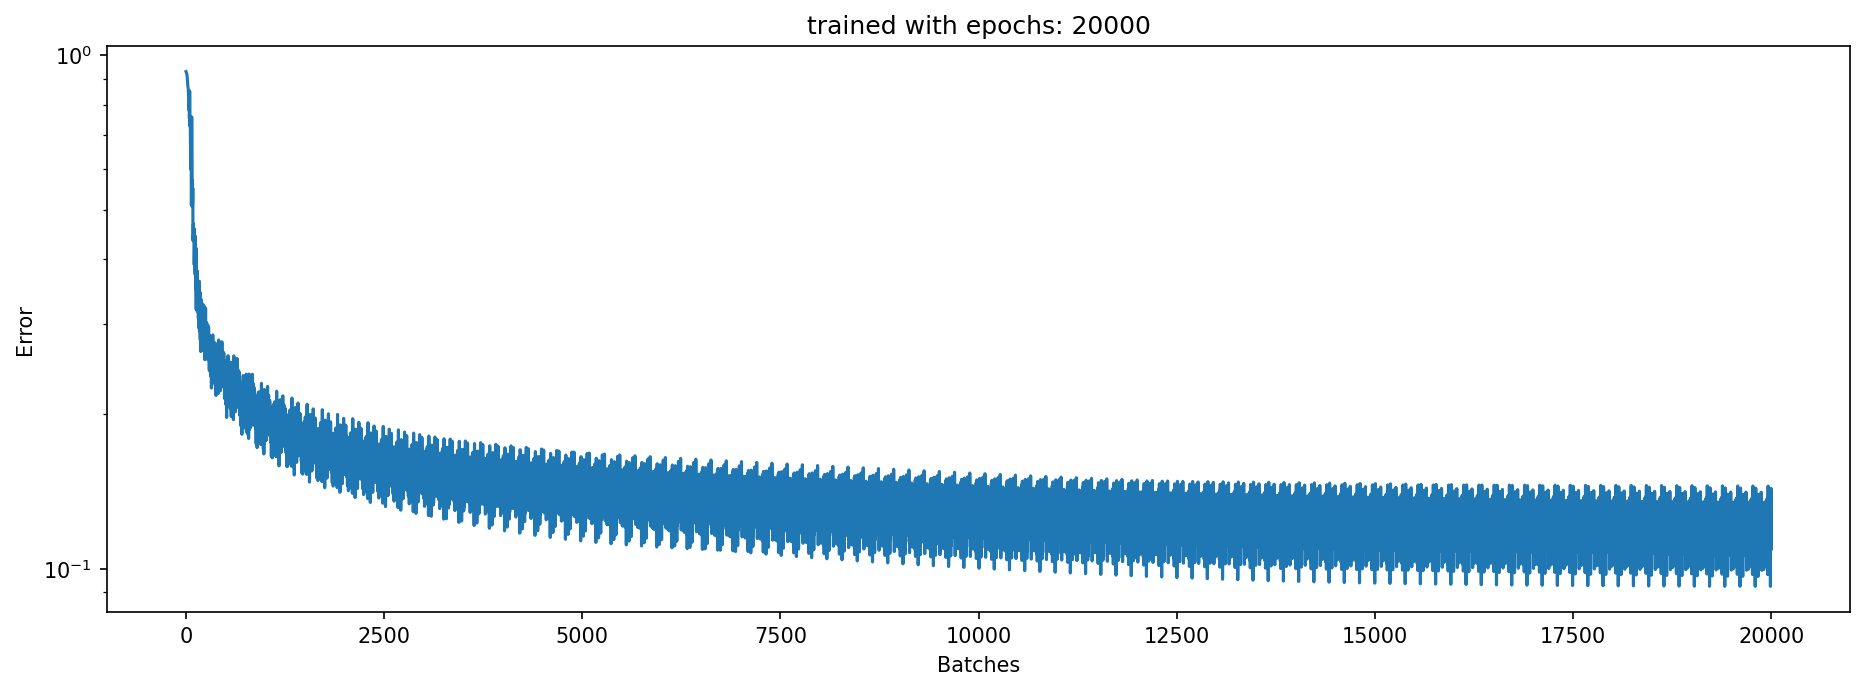

train 4000 batch_size 1000 correct 930.0 of 1000 Ratio 0.93 Error 0.11318064615059766
test 4000 batch_size 1000 correct 910.0 of 1000 Ratio 0.91 Error 0.1499365924318452
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.4379399581461447
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.791                 0.182                0.712                 0.682
   2      1             0.716                 0.404                0.678                 0.666
   3      1             0.754                 0.416                0.674                 0.692
   4      1             0.725                 0.216                0.731                 0.624
   5      1             0.631                 0.543                0.683                 0.615
   6      1             0.713                 0.564                0.751                 0.683
   7    

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 20000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


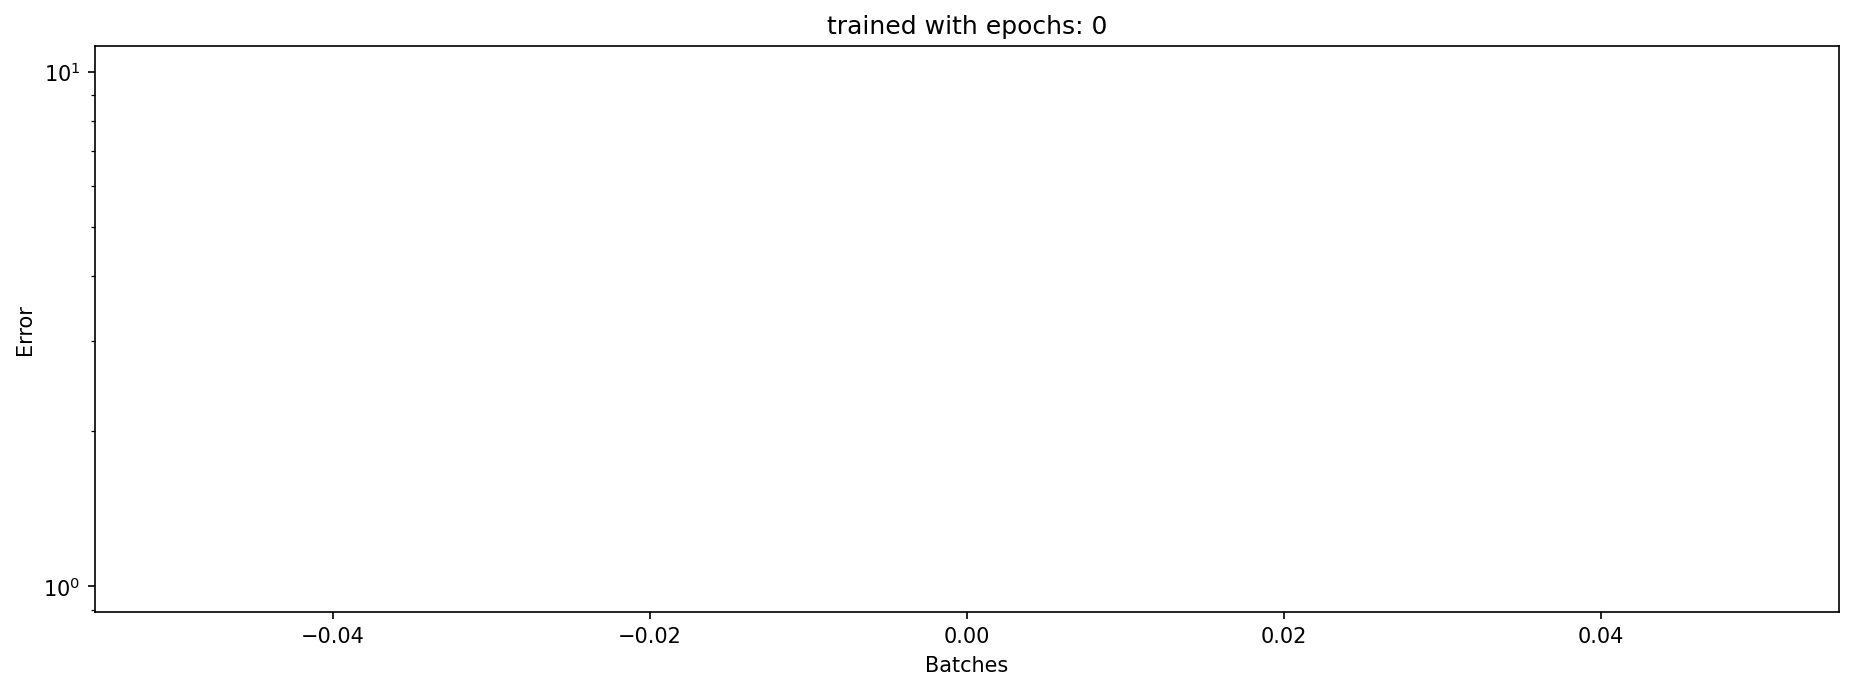

train 4000 batch_size 1000 correct 140.0 of 1000 Ratio 0.14 Error 0.9269993157628365
test 4000 batch_size 1000 correct 125.0 of 1000 Ratio 0.125 Error 0.9269704078853324
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 9.0 of 1000 Ratio 0.009 Error 0.9271750996930854
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.060                 0.475                0.546                 0.126
   2      1             0.019                 0.502                0.515                 0.104
   3      1             0.170                 0.291                0.513                 0.188
   4      1             0.017                 0.620                0.630                 0.117
   5      1             0.000                 0.516                0.516                 0.095
   6      1             0.004                 0.561                0.562                 0.095
   7  

  83      1             0.412                 0.514                0.576                 0.433
  84      1             0.545                 0.557                0.749                 0.538
  85      1             0.474                 0.749                0.835                 0.515
  86      1             0.518                 0.565                0.863                 0.524
  87      1             0.543                 0.611                0.858                 0.554
  88      1             0.369                 0.795                0.851                 0.453
  89      1             0.460                 0.530                0.654                 0.472
  90      1             0.529                 0.681                0.860                 0.562
  91      1             0.376                 0.799                0.826                 0.451
  92      1             0.517                 0.383                0.612                 0.488
  93      1             0.434                 0.45

 170      1             0.504                 0.595                0.814                 0.503
 171      1             0.581                 0.594                0.798                 0.574
 172      1             0.525                 0.643                0.799                 0.548
 173      1             0.643                 0.594                0.855                 0.622
 174      1             0.555                 0.632                0.832                 0.563
 175      1             0.604                 0.639                0.833                 0.603
 176      1             0.607                 0.568                0.849                 0.587
 177      1             0.566                 0.683                0.855                 0.582
 178      1             0.522                 0.785                0.871                 0.563
 179      1             0.598                 0.560                0.799                 0.582
 180      1             0.571                 0.60

 257      1             0.637                 0.707                0.840                 0.658
 258      1             0.504                 0.788                0.856                 0.552
 259      1             0.535                 0.764                0.860                 0.573
 260      1             0.528                 0.750                0.860                 0.567
 261      1             0.585                 0.704                0.855                 0.594
 262      1             0.513                 0.754                0.842                 0.544
 263      1             0.538                 0.704                0.855                 0.557
 264      1             0.542                 0.628                0.793                 0.549
 265      1             0.596                 0.628                0.794                 0.592
 266      1             0.559                 0.796                0.880                 0.595
 267      1             0.618                 0.72

 344      1             0.669                 0.648                0.875                 0.670
 345      1             0.687                 0.587                0.872                 0.662
 346      1             0.656                 0.660                0.861                 0.649
 347      1             0.591                 0.707                0.852                 0.610
 348      1             0.662                 0.744                0.857                 0.673
 349      1             0.579                 0.691                0.750                 0.602
 350      1             0.569                 0.778                0.830                 0.610
 351      1             0.638                 0.699                0.852                 0.646
 352      1             0.629                 0.640                0.844                 0.630
 353      1             0.551                 0.729                0.887                 0.575
 354      1             0.568                 0.75

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 0
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 1000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


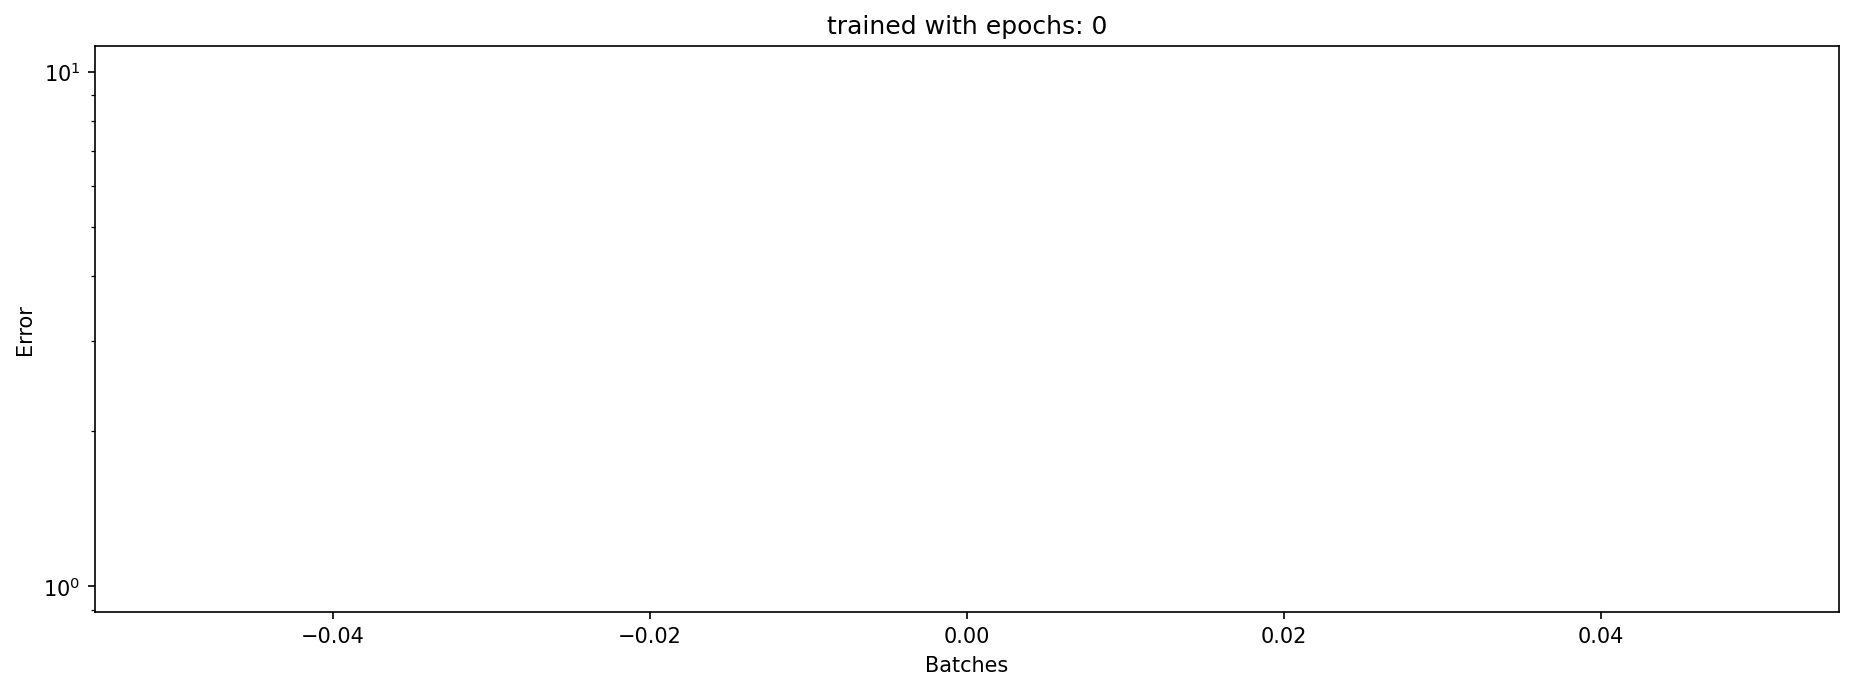

train 4000 batch_size 1000 correct 140.0 of 1000 Ratio 0.14 Error 0.9269993157628365
test 4000 batch_size 1000 correct 125.0 of 1000 Ratio 0.125 Error 0.9269704078853324
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 9.0 of 1000 Ratio 0.009 Error 0.9271750996930854
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.061                 0.476                0.548                 0.127
   2      1             0.018                 0.501                0.515                 0.102
   3      1             0.171                 0.290                0.514                 0.189
   4      1             0.017                 0.616                0.626                 0.115
   5      1             0.000                 0.516                0.516                 0.095
   6      1             0.004                 0.561                0.562                 0.095
   7  

  83      1             0.335                 0.624                0.653                 0.393
  84      1             0.528                 0.570                0.723                 0.527
  85      1             0.430                 0.782                0.844                 0.485
  86      1             0.508                 0.506                0.824                 0.500
  87      1             0.563                 0.655                0.870                 0.577
  88      1             0.365                 0.803                0.847                 0.454
  89      1             0.483                 0.533                0.663                 0.490
  90      1             0.520                 0.703                0.862                 0.559
  91      1             0.394                 0.769                0.798                 0.458
  92      1             0.519                 0.400                0.644                 0.497
  93      1             0.467                 0.46

 170      1             0.559                 0.659                0.859                 0.563
 171      1             0.553                 0.619                0.816                 0.553
 172      1             0.510                 0.660                0.800                 0.529
 173      1             0.630                 0.643                0.857                 0.621
 174      1             0.523                 0.602                0.797                 0.533
 175      1             0.579                 0.767                0.857                 0.600
 176      1             0.582                 0.639                0.867                 0.593
 177      1             0.584                 0.693                0.861                 0.596
 178      1             0.499                 0.803                0.881                 0.547
 179      1             0.571                 0.664                0.826                 0.584
 180      1             0.545                 0.69

 257      1             0.620                 0.664                0.854                 0.618
 258      1             0.467                 0.803                0.878                 0.529
 259      1             0.504                 0.788                0.866                 0.553
 260      1             0.445                 0.825                0.870                 0.516
 261      1             0.570                 0.687                0.881                 0.581
 262      1             0.511                 0.623                0.842                 0.515
 263      1             0.592                 0.768                0.891                 0.615
 264      1             0.585                 0.721                0.844                 0.604
 265      1             0.640                 0.604                0.741                 0.630
 266      1             0.553                 0.799                0.881                 0.592
 267      1             0.601                 0.76

 344      1             0.708                 0.618                0.880                 0.685
 345      1             0.696                 0.590                0.872                 0.672
 346      1             0.689                 0.624                0.845                 0.676
 347      1             0.632                 0.735                0.872                 0.647
 348      1             0.637                 0.771                0.877                 0.660
 349      1             0.600                 0.697                0.780                 0.609
 350      1             0.575                 0.786                0.843                 0.610
 351      1             0.653                 0.743                0.882                 0.662
 352      1             0.666                 0.697                0.871                 0.670
 353      1             0.547                 0.779                0.877                 0.585
 354      1             0.543                 0.81

 431      1             0.642                 0.727                0.868                 0.659
 432      1             0.563                 0.774                0.867                 0.605
 433      1             0.659                 0.636                0.877                 0.648
 434      1             0.658                 0.706                0.877                 0.666
 435      1             0.667                 0.634                0.875                 0.650
 436      1             0.622                 0.582                0.858                 0.606
 437      1             0.621                 0.738                0.823                 0.642
 438      1             0.676                 0.590                0.780                 0.658
 439      1             0.583                 0.778                0.838                 0.619
 440      1             0.629                 0.717                0.861                 0.646
 441      1             0.650                 0.73

 518      1             0.590                 0.750                0.809                 0.624
 519      1             0.624                 0.731                0.889                 0.640
 520      1             0.606                 0.623                0.719                 0.612
 521      1             0.644                 0.725                0.900                 0.649
 522      1             0.644                 0.689                0.809                 0.645
 523      1             0.628                 0.781                0.894                 0.652
 524      1             0.631                 0.763                0.898                 0.649
 525      1             0.586                 0.768                0.860                 0.617
 526      1             0.668                 0.752                0.905                 0.679
 527      1             0.658                 0.681                0.846                 0.653
 528      1             0.557                 0.68

 605      1             0.578                 0.773                0.855                 0.608
 606      1             0.629                 0.789                0.882                 0.653
 607      1             0.641                 0.713                0.838                 0.646
 608      1             0.629                 0.682                0.862                 0.629
 609      1             0.649                 0.682                0.889                 0.656
 610      1             0.713                 0.628                0.881                 0.693
 611      1             0.701                 0.716                0.897                 0.695
 612      1             0.632                 0.658                0.765                 0.626
 613      1             0.683                 0.733                0.862                 0.685
 614      1             0.668                 0.806                0.902                 0.682
 615      1             0.642                 0.70

 692      1             0.666                 0.791                0.917                 0.683
 693      1             0.694                 0.766                0.905                 0.699
 694      1             0.648                 0.745                0.867                 0.655
 695      1             0.641                 0.648                0.809                 0.639
 696      1             0.673                 0.746                0.883                 0.675
 697      1             0.629                 0.805                0.885                 0.664
 698      1             0.630                 0.775                0.891                 0.663
 699      1             0.658                 0.750                0.892                 0.682
 700      1             0.656                 0.785                0.901                 0.671
 701      1             0.672                 0.746                0.883                 0.674
 702      1             0.625                 0.82

 779      1             0.693                 0.760                0.902                 0.697
 780      1             0.690                 0.689                0.890                 0.678
 781      1             0.703                 0.723                0.890                 0.700
 782      1             0.669                 0.720                0.846                 0.669
 783      1             0.658                 0.734                0.878                 0.661
 784      1             0.647                 0.722                0.832                 0.641
 785      1             0.601                 0.791                0.844                 0.625
 786      1             0.709                 0.697                0.901                 0.695
 787      1             0.689                 0.613                0.866                 0.665
 788      1             0.670                 0.764                0.896                 0.674
 789      1             0.686                 0.71

 866      1             0.699                 0.647                0.892                 0.686
 867      1             0.681                 0.712                0.901                 0.685
 868      1             0.728                 0.643                0.886                 0.716
 869      1             0.734                 0.684                0.874                 0.721
 870      1             0.723                 0.697                0.879                 0.718
 871      1             0.708                 0.733                0.879                 0.706
 872      1             0.709                 0.769                0.907                 0.714
 873      1             0.687                 0.748                0.913                 0.694
 874      1             0.690                 0.766                0.919                 0.698
 875      1             0.672                 0.825                0.913                 0.690
 876      1             0.665                 0.84

 953      1             0.698                 0.756                0.900                 0.693
 954      1             0.714                 0.766                0.918                 0.714
 955      1             0.688                 0.820                0.931                 0.703
 956      1             0.674                 0.764                0.884                 0.679
 957      1             0.672                 0.815                0.905                 0.692
 958      1             0.652                 0.805                0.884                 0.675
 959      1             0.683                 0.837                0.916                 0.710
 960      1             0.677                 0.821                0.914                 0.700
 961      1             0.692                 0.806                0.922                 0.709
 962      1             0.687                 0.824                0.924                 0.707
 963      1             0.690                 0.82

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 0
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 1000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [03:42<00:00, 44.91it/s]


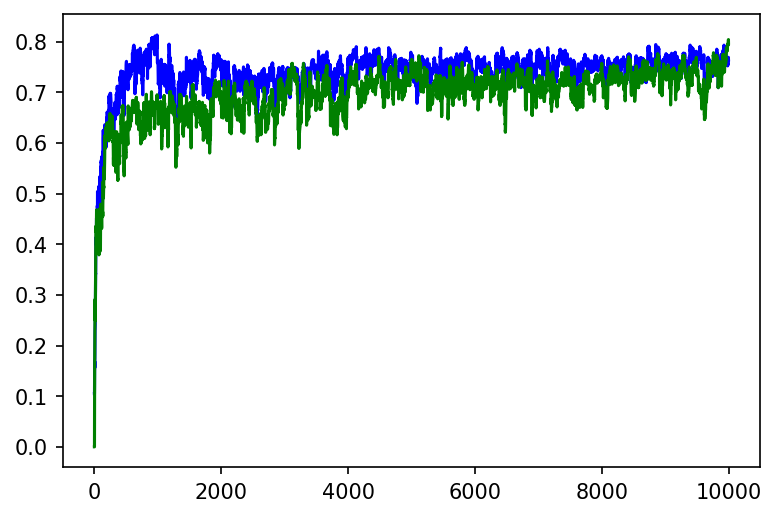

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.2

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 20
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [06:54<00:00, 24.14it/s]


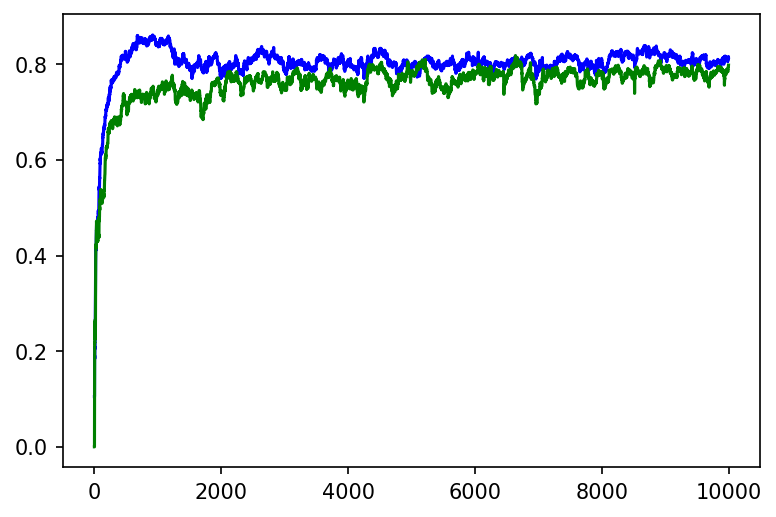

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.2

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 100
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [07:33<00:00, 22.05it/s]


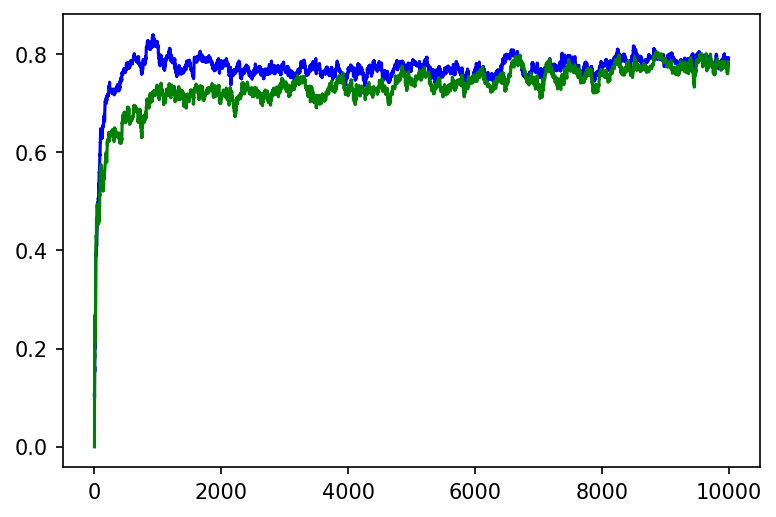

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.2

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 100
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [06:56<00:00, 24.00it/s]


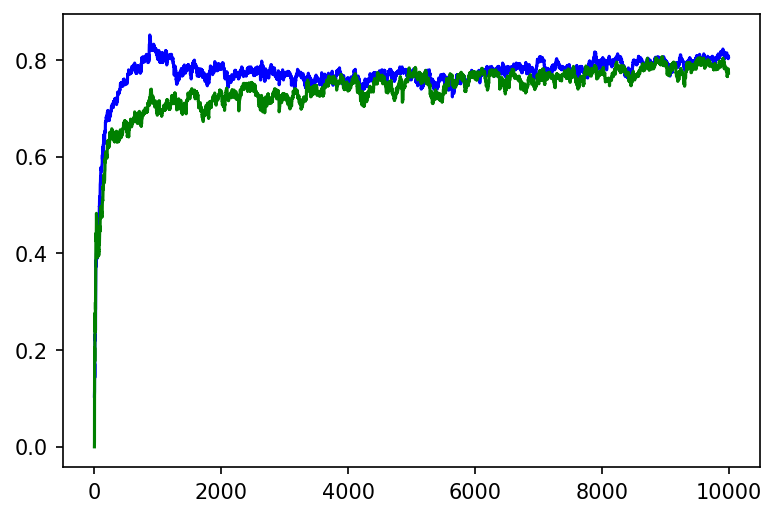

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 100
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [03:17<00:00, 50.52it/s]


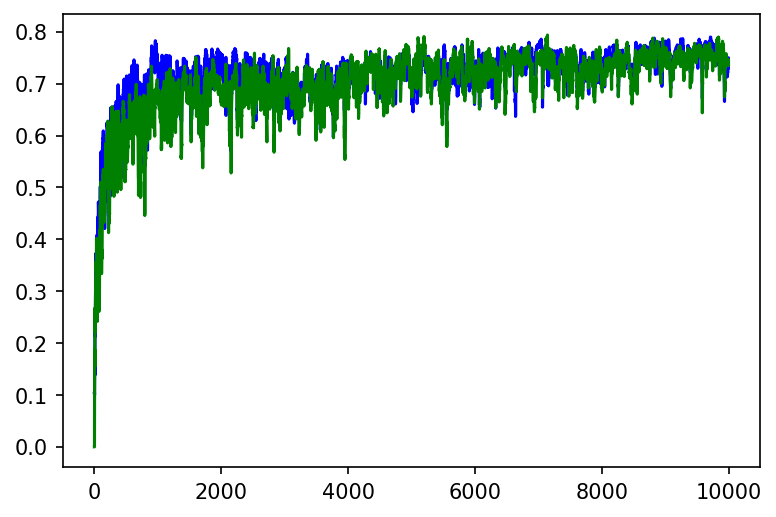

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [03:55<00:00, 42.40it/s]


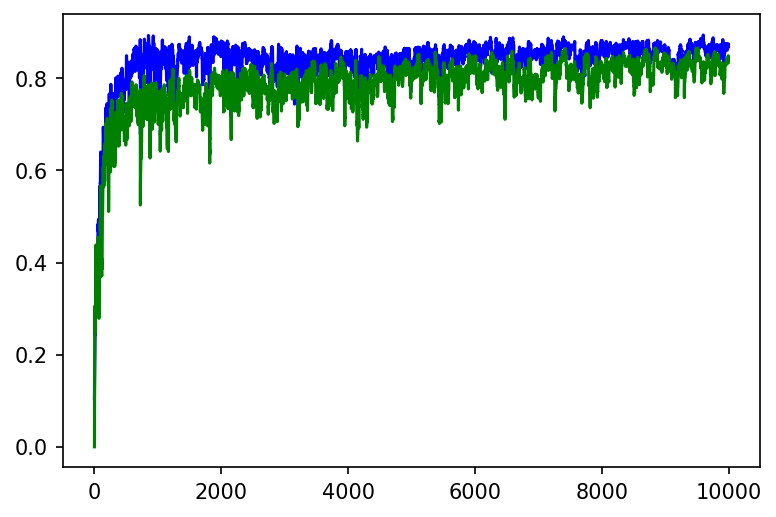

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 128
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [07:05<00:00, 23.48it/s]


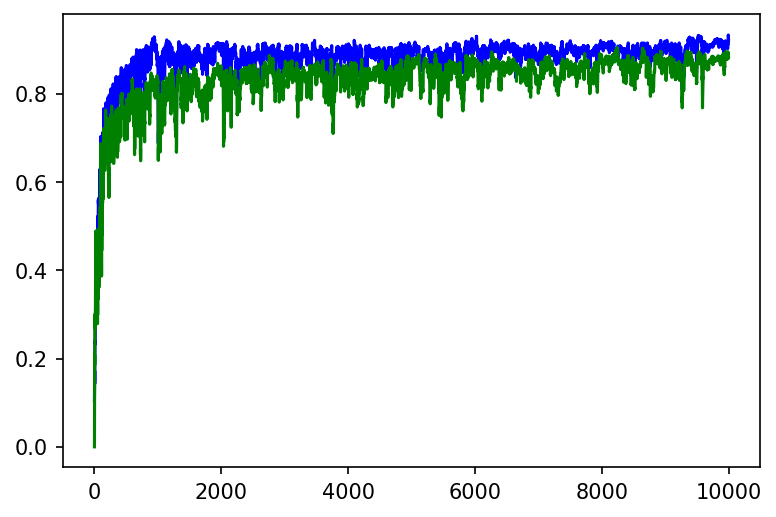

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 256
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [13:16<00:00, 12.55it/s]


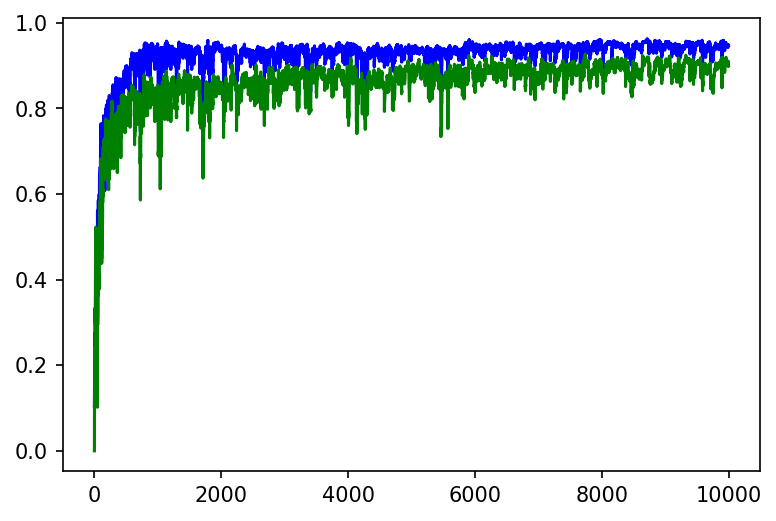

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 512
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [03:39<00:00, 45.61it/s]


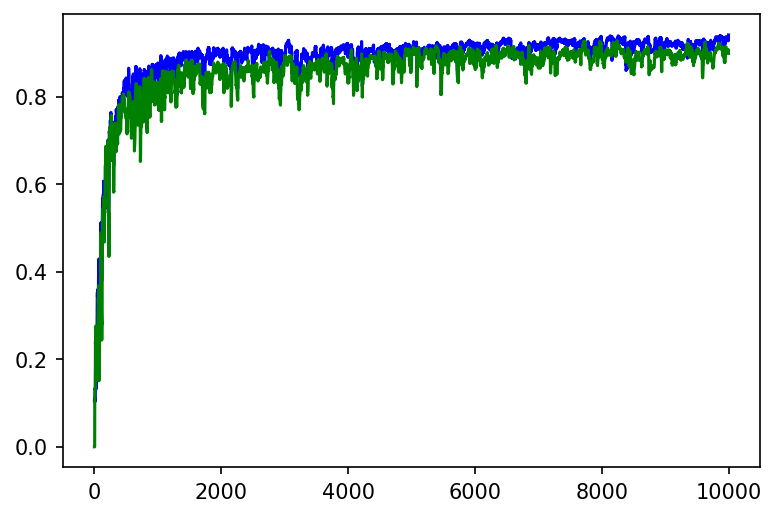

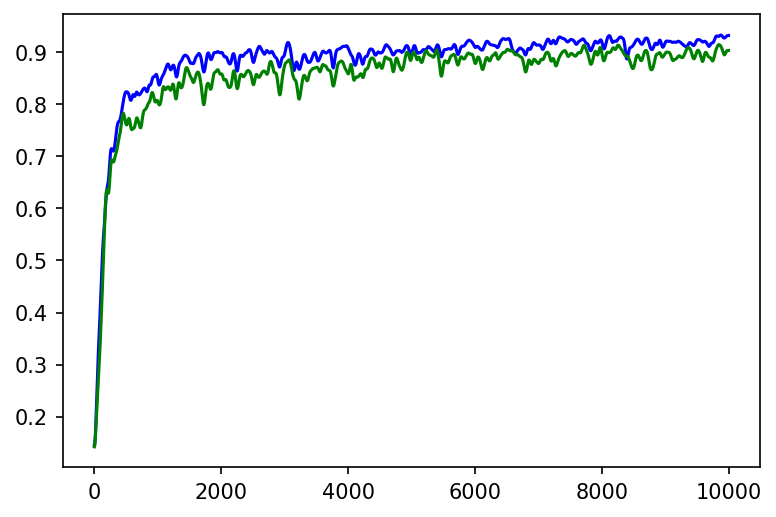

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 128
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [15:29<00:00, 10.76it/s]


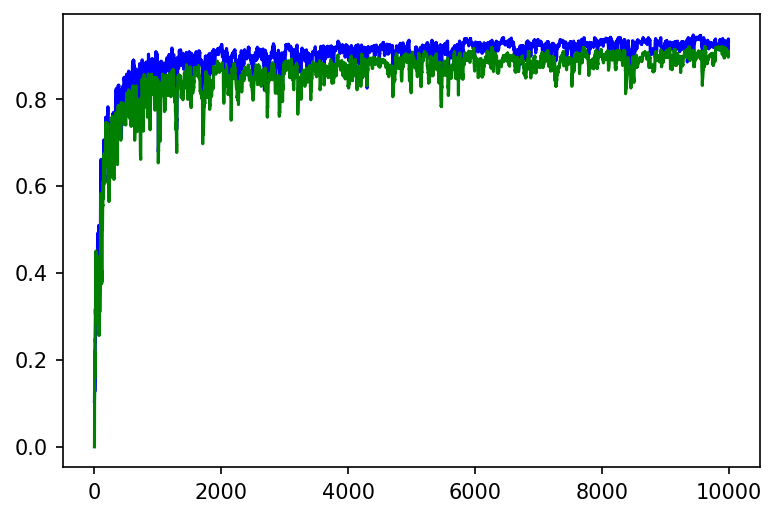

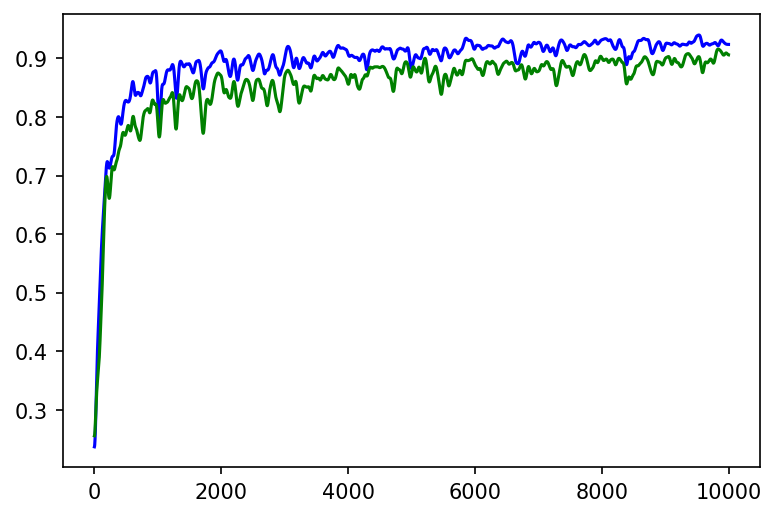

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 512
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [03:14<00:00, 51.33it/s]


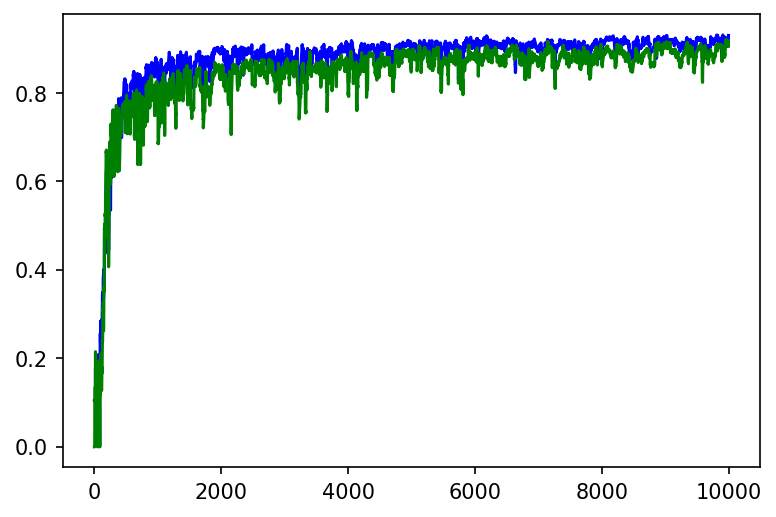

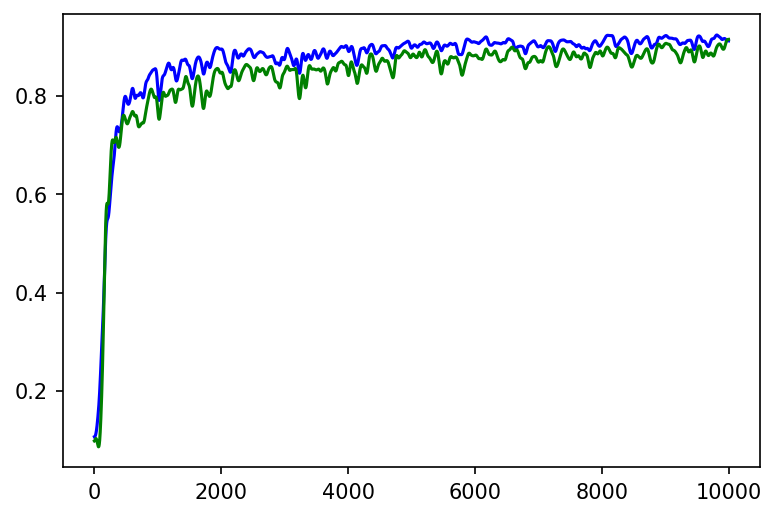

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [04:25<00:00, 37.73it/s]


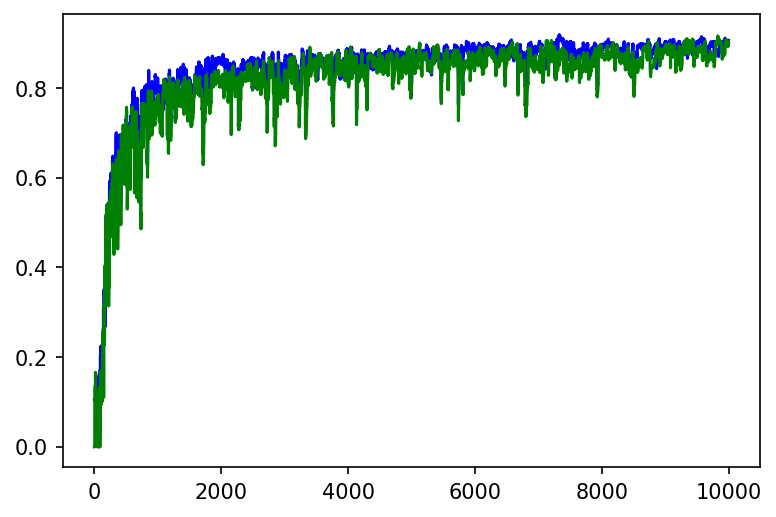

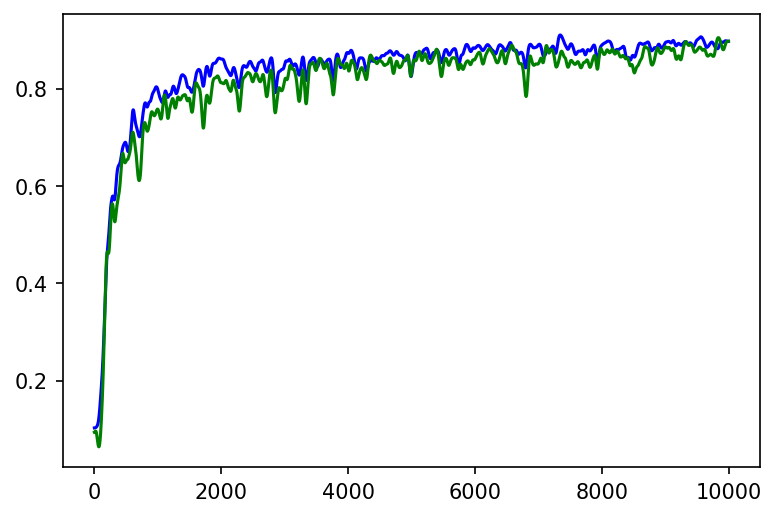

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.001, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [03:32<00:00, 47.14it/s]


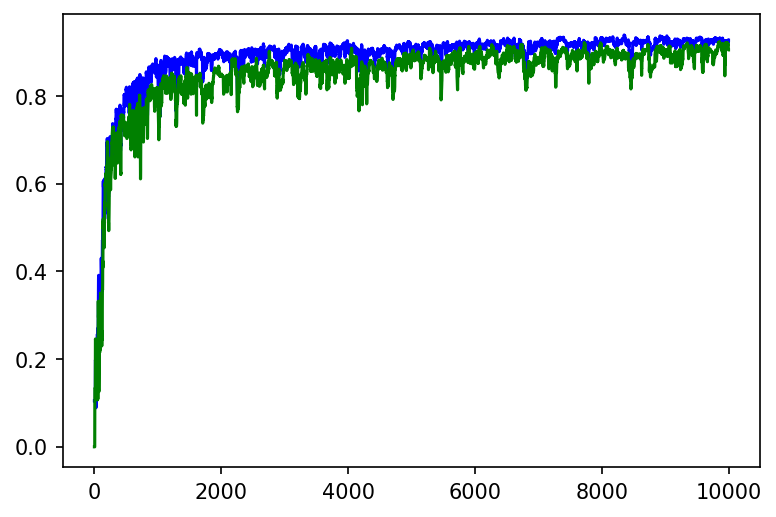

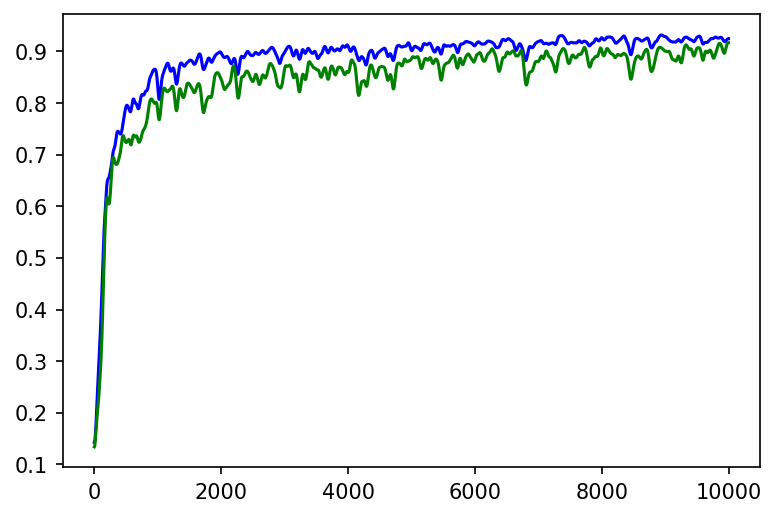

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.05, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [01:56<00:00, 85.62it/s]


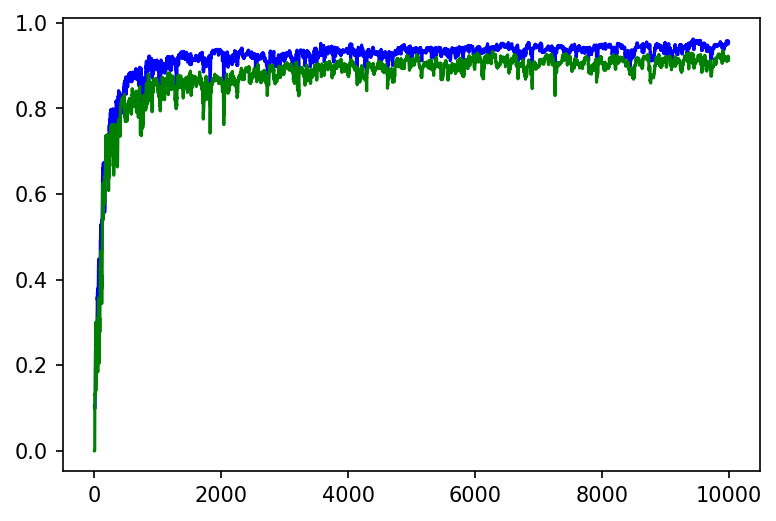

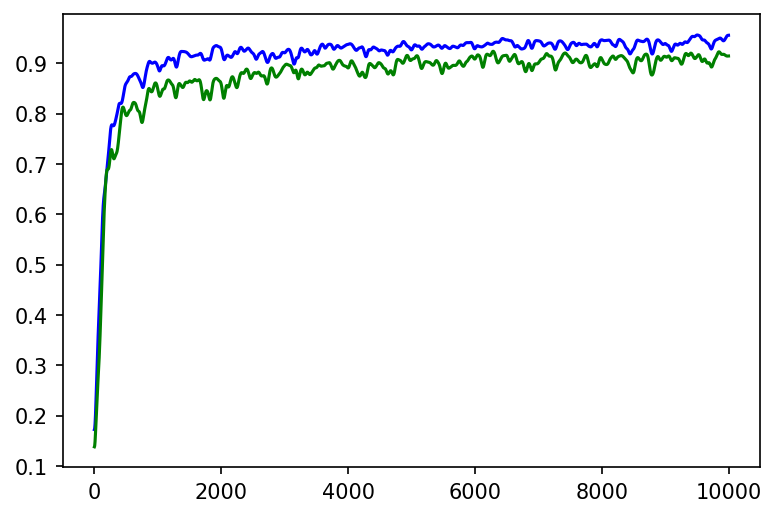

In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


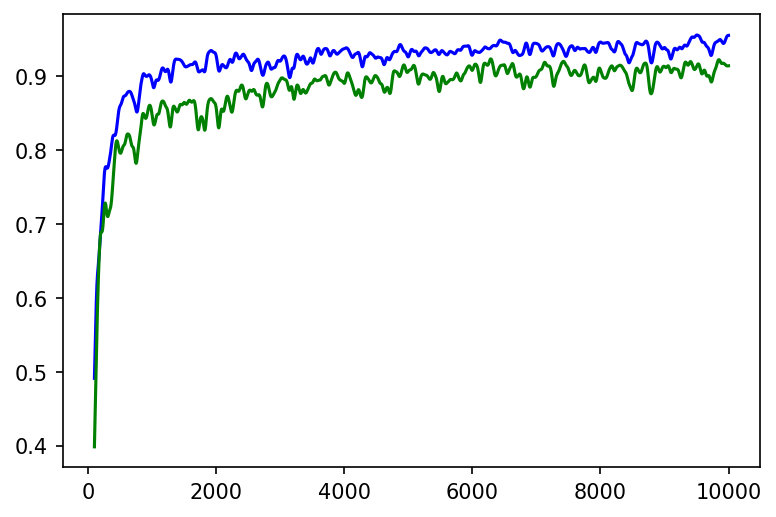

In [27]:
pyplot.plot(shot[100:],y1s[100:],'b')
pyplot.plot(shot[100:],y2s[100:],'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


100%|██████████| 10000/10000 [04:51<00:00, 34.29it/s]


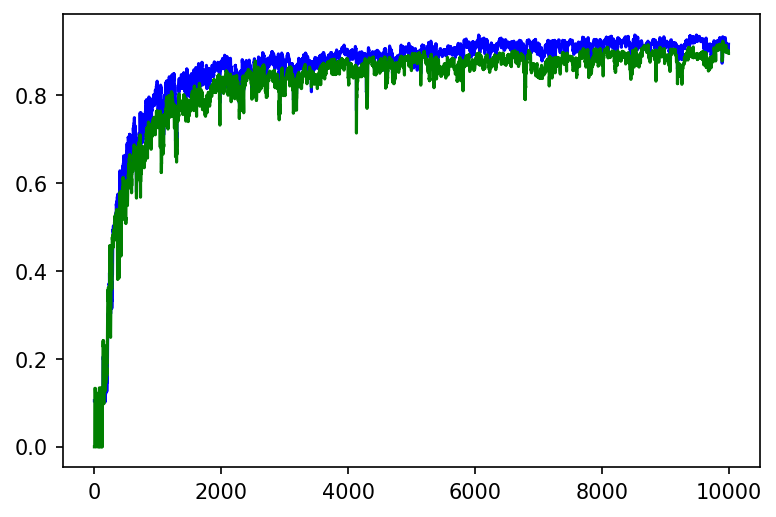

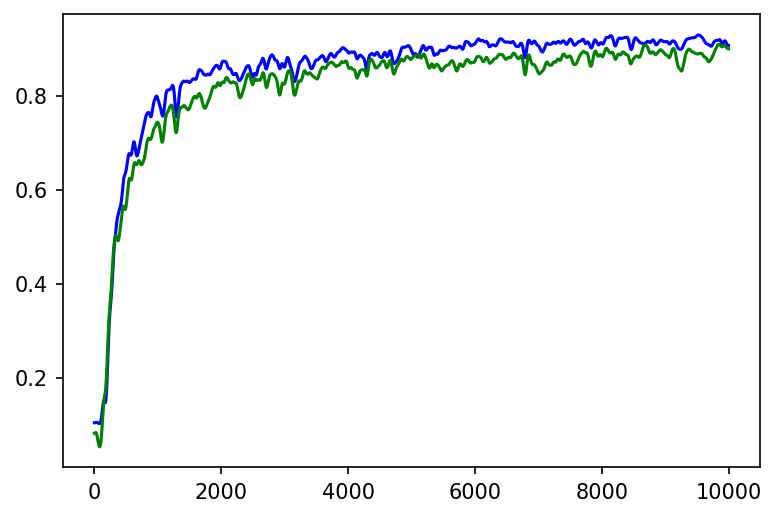

In [37]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = 2 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    if verbose > 0:
        print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


[<__main__.Layer object at 0x7f7e6c543fd0>, <__main__.Layer object at 0x7f7e6c543350>, <__main__.Layer object at 0x7f7e6c5b30d0>, <__main__.Layer object at 0x7f7e6c59d210>, <__main__.Layer object at 0x7f7e6c5a4350>]


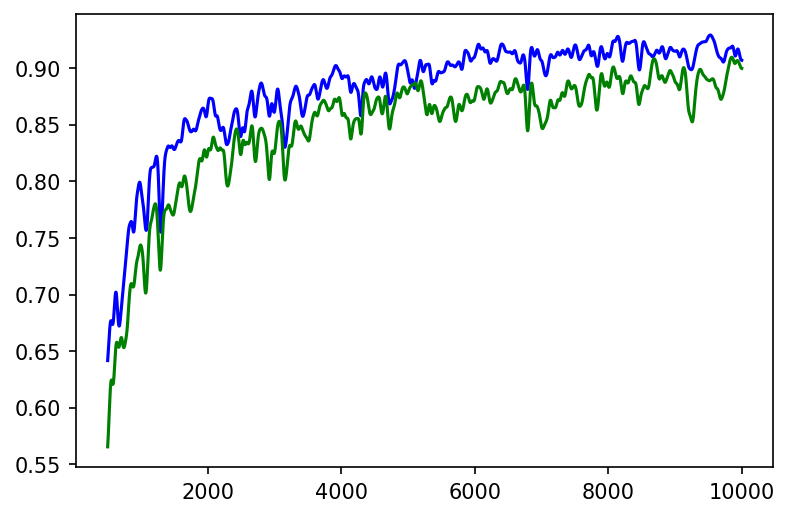

In [39]:
print(NN2.layers)
pyplot.plot(shot[500:],y1s[500:],'b')
pyplot.plot(shot[500:],y2s[500:],'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  63104 dropped 0 real parameters 63104 drop definition []


100%|██████████| 10000/10000 [18:27<00:00,  9.03it/s]


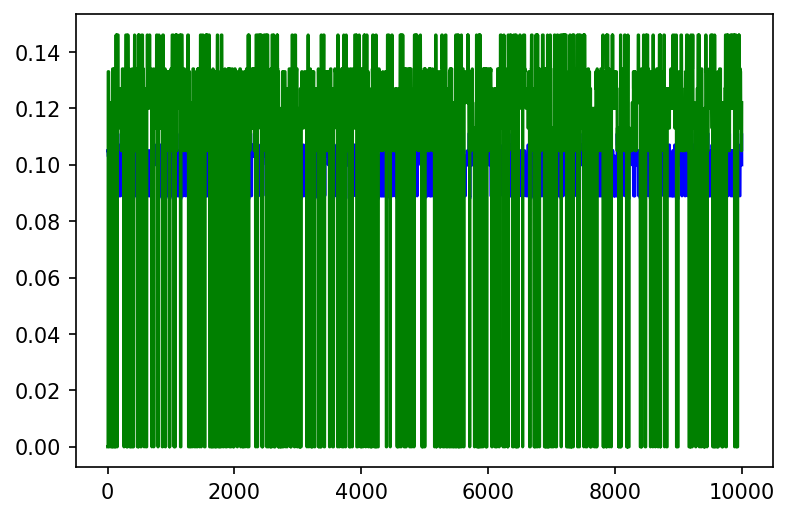

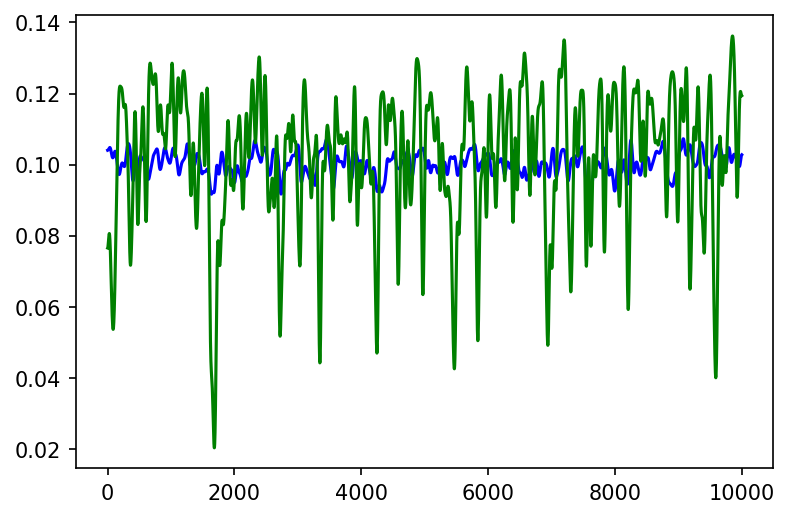

In [42]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
from IPython import displayimport numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = 3 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.1
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.02 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
for i_shot in tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar): # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


# It seems to be necessary to increase the random initialization, if more than 3 hidden layers are used?

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  63104 dropped 0 real parameters 63104 drop definition []


Err  0.604: 100%|██████████| 10000/10000 [04:24<00:00, 37.81it/s]


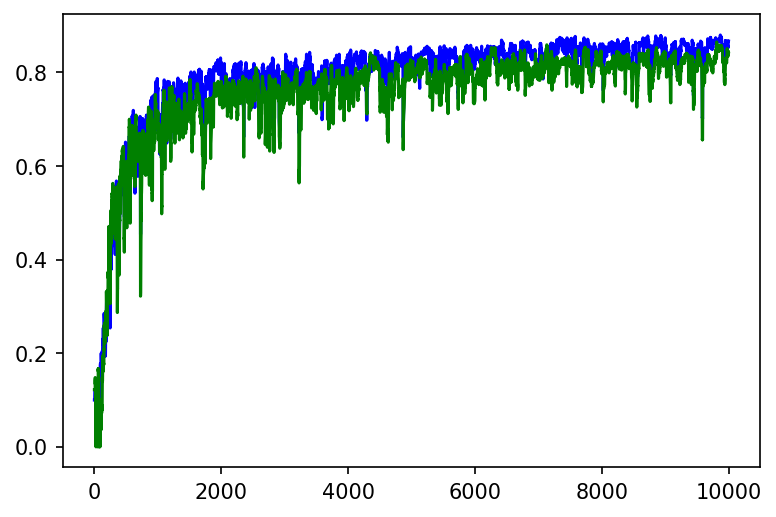

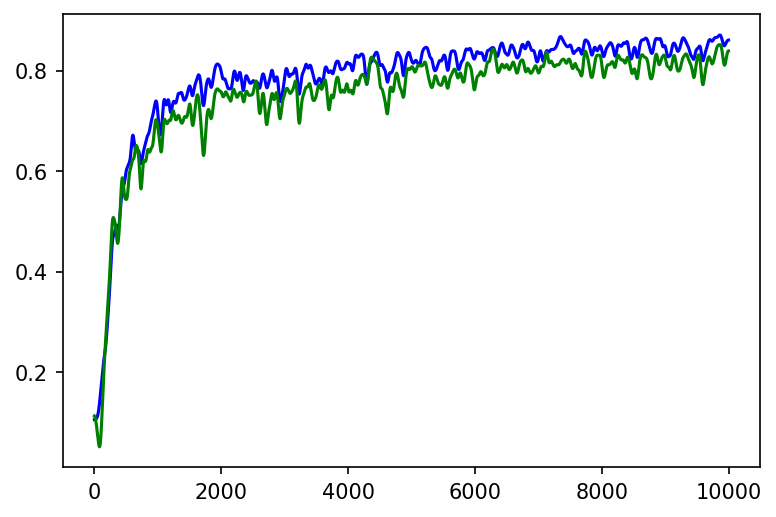

In [59]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = 3 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.03
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.03 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 0.1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        err = np.sum(np.square(NN2.error))
        ttt.set_description("Err %6.3f" % (err), refresh=False)
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  63104 dropped 0 real parameters 63104 drop definition []


Err  0.647: 100%|██████████| 10000/10000 [03:54<00:00, 42.58it/s]


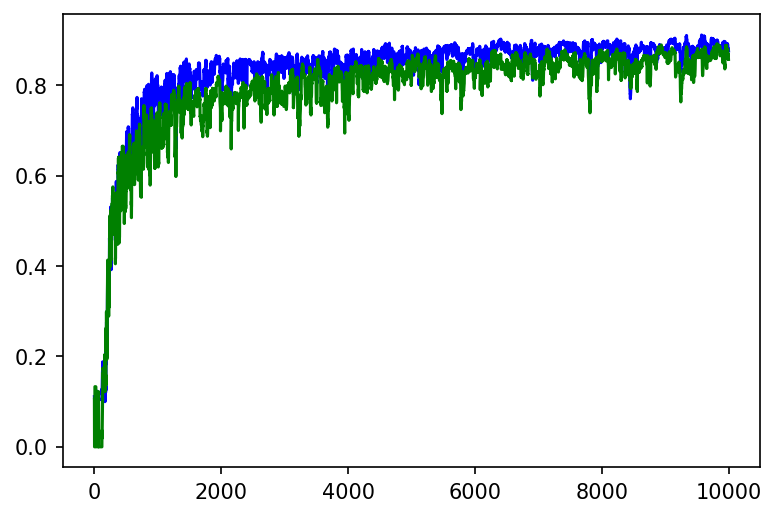

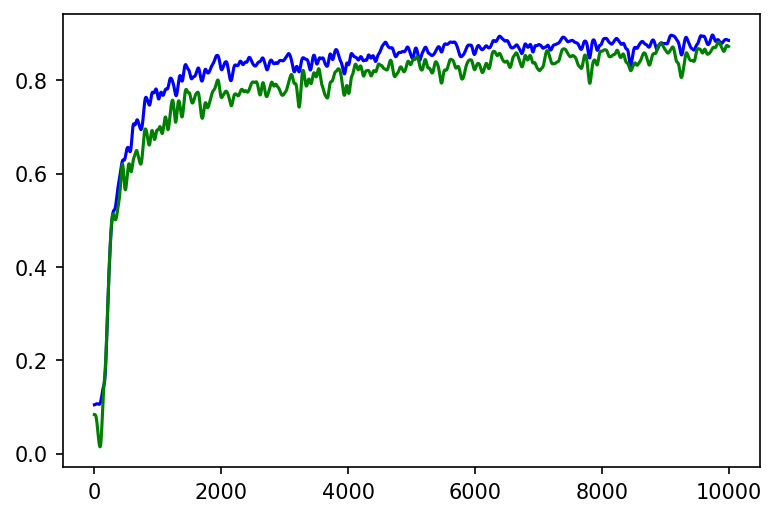

In [61]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = 3 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.03
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.01 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        err = np.sum(np.square(NN2.error))
        ttt.set_description("Err %6.3f" % (err), refresh=False)
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  399872 dropped 0 real parameters 399872 drop definition []


Err  0.247: 100%|██████████| 10000/10000 [05:20<00:00, 31.18it/s]


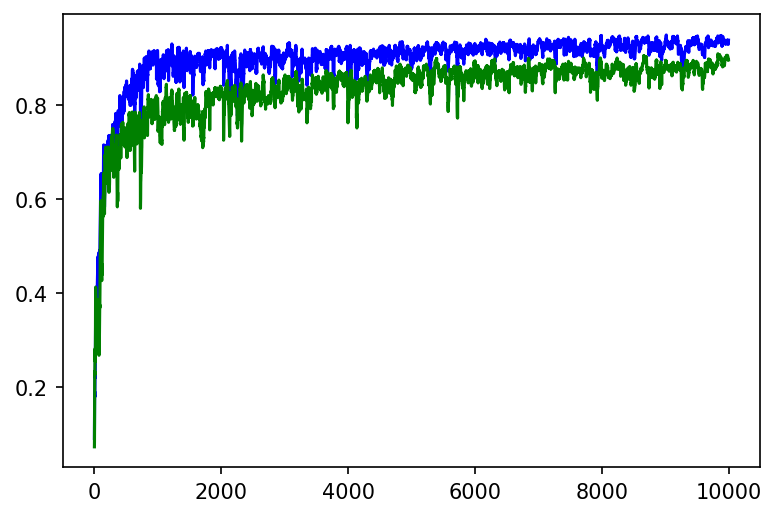

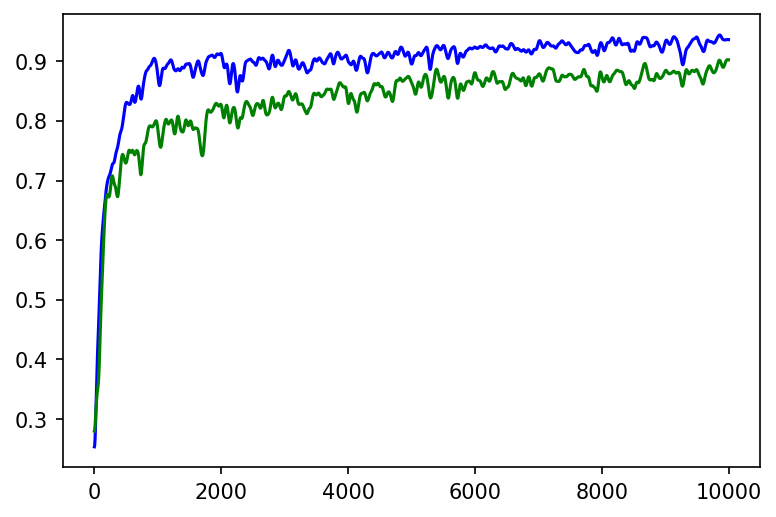

In [62]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 256
two_hidden_layers = 3 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.03
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.01 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        err = np.sum(np.square(NN2.error))
        ttt.set_description("Err %6.3f" % (err), refresh=False)
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  399872 dropped 0 real parameters 399872 drop definition []


Err  0.467: 100%|██████████| 100000/100000 [40:14<00:00, 41.42it/s]


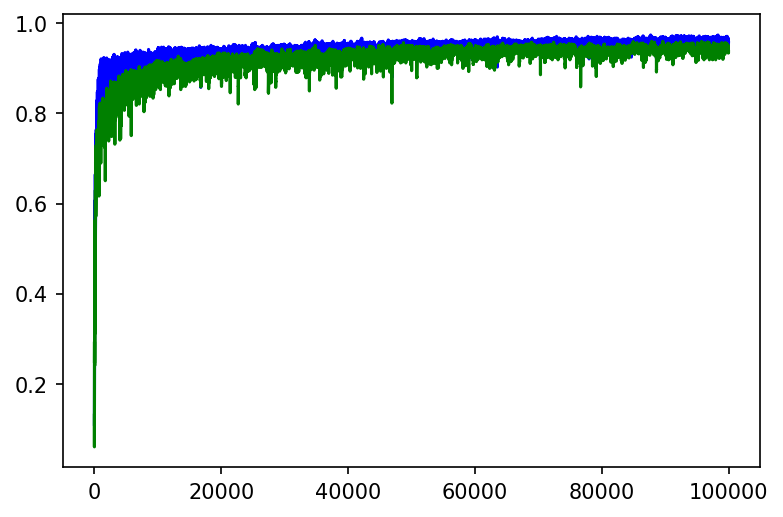

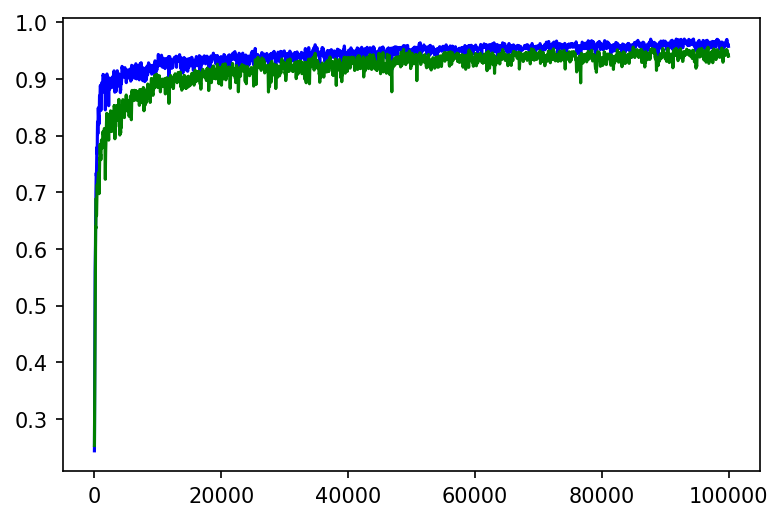

In [63]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 256
two_hidden_layers = 3 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.03
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.01 # for mnist
few_shot_threshold = 0.1

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 100000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 0:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 0:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 0:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        err = np.sum(np.square(NN2.error))
        ttt.set_description("Err %6.3f" % (err), refresh=False)
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 0:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 0:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d              %7.3f               %7.3f" % (i_shot + 1, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


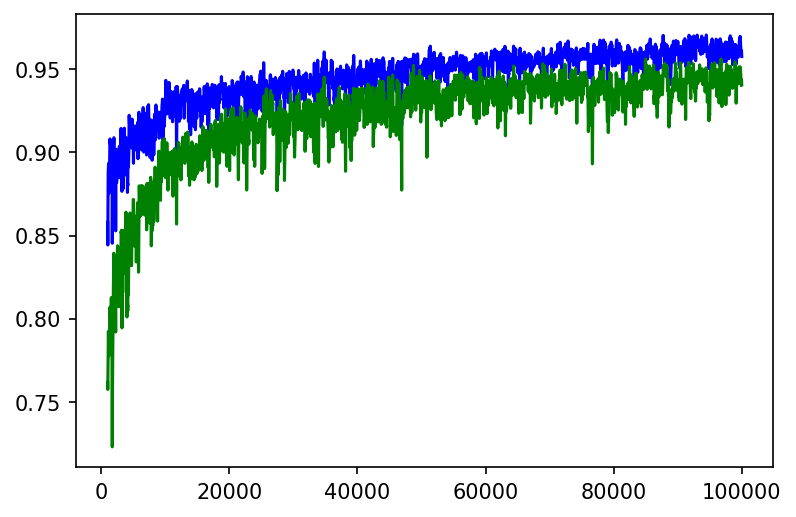

In [65]:
from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot[1000:],y1s[1000:],'b')
pyplot.plot(shot[1000:],y2s[1000:],'g')
pyplot.show()


In [76]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 1

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 256
two_hidden_layers = 3 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.01
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100000
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 100000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 1:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 1:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 1:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        err = np.sum(np.square(NN2.error))
        ttt.set_description("Err %6.3f" % (err), refresh=False)
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 1:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    if verbose > 0:
        print("%4d      %6d        %7.3f               %7.3f" % (i_shot + 1, epoch, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
loaded mnist Train dataset  with 10 labels None
Network parameters:  268800 dropped 0 real parameters 268800 drop definition []
additional hidden layer
additional hidden layer
additional hidden layer
Network parameters:  399872 dropped 0 real parameters 399872 drop definition []


  0%|          | 0/100000 [00:00<?, ?it/s]

loaded mnist Test dataset  with 10 labels [0, 1, 9, 3, 4, 5, 6, 7]
   1           7          0.106                 0.085
   2           5          0.115                 0.103
   3          10          0.107                 0.116
   4          49          0.142                 0.169
   5           6          0.153                 0.176
   6           5          0.154                 0.181
   7          33          0.149                 0.170
   8         199          0.162                 0.200
   9         307          0.193                 0.228
  10        1602          0.229                 0.260
  11           1          0.226                 0.261
  12           1          0.225                 0.256
  13          87          0.217                 0.253


Err  1.108:   0%|          | 14/100000 [00:10<21:21:31,  1.30it/s]

  14         245          0.237                 0.261
  15         224          0.258                 0.217
  16         102          0.263                 0.210
  17          11          0.268                 0.258
  18         105          0.271                 0.278
  19         327          0.293                 0.351
  20           1          0.294                 0.350
  21         675          0.319                 0.366
  22         132          0.309                 0.347
  23          73          0.343                 0.348
  24         243          0.331                 0.336
  25           1          0.331                 0.333
  26           1          0.329                 0.329
  27          61          0.332                 0.318
  28           9          0.316                 0.313
  29          40          0.312                 0.299
  30           1          0.312                 0.301
  31           4          0.321                 0.318
  32           1          0.

Err  0.981:   0%|          | 38/100000 [00:25<19:53:43,  1.40it/s]

  38        1029          0.370                 0.373
  39          77          0.383                 0.364
  40           5          0.389                 0.354
  41          59          0.409                 0.322
  42           1          0.413                 0.320
  43           1          0.412                 0.322
  44           1          0.409                 0.322
  45          72          0.407                 0.308
  46           1          0.407                 0.304
  47          43          0.400                 0.269
  48          16          0.378                 0.236
  49           4          0.390                 0.248
  50           7          0.391                 0.245
  51           1          0.391                 0.244
  52           1          0.394                 0.245
  53           1          0.395                 0.247
  54           5          0.417                 0.269
  55          20          0.453                 0.319
  56         693          0.

Err  0.982:   0%|          | 74/100000 [00:35<16:22:48,  1.69it/s]

  74         984          0.308                 0.260
  75           1          0.308                 0.262
  76           1          0.308                 0.261
  77          25          0.361                 0.315
  78           4          0.377                 0.321
  79          10          0.398                 0.327
  80          42          0.389                 0.297
  81          13          0.398                 0.289
  82           1          0.401                 0.288
  83          20          0.411                 0.316
  84           1          0.411                 0.316
  85         198          0.419                 0.299
  86          21          0.390                 0.255
  87           5          0.385                 0.252
  88          49          0.428                 0.333
  89           1          0.431                 0.335
  90           6          0.428                 0.323
  91           7          0.436                 0.326
  92          80          0.

Err  0.979:   0%|          | 136/100000 [01:26<18:14:54,  1.52it/s]

 136       10574          0.548                 0.539
 137        2742          0.565                 0.537
 138           1          0.565                 0.537


Err  0.965:   0%|          | 139/100000 [01:47<72:43:38,  2.62s/it]

 139        2278          0.605                 0.581
 140          35          0.618                 0.585
 141           1          0.618                 0.586
 142           3          0.620                 0.583
 143         122          0.590                 0.528
 144          22          0.598                 0.556
 145          48          0.632                 0.577
 146          16          0.633                 0.582
 147           2          0.634                 0.582
 148           1          0.633                 0.588
 149         332          0.609                 0.578
 150           1          0.607                 0.576
 151           1          0.606                 0.575
 152           1          0.600                 0.572
 153           5          0.586                 0.563
 154           1          0.586                 0.555
 155           4          0.579                 0.557
 156          15          0.553                 0.529
 157           1          0.

Err  1.297:   0%|          | 170/100000 [01:57<53:35:42,  1.93s/it]

 167          25          0.617                 0.620
 168           1          0.621                 0.621
 169           1          0.625                 0.621
 170          26          0.620                 0.619
 171           1          0.622                 0.619
 172           1          0.625                 0.623
 173           1          0.624                 0.623
 174           1          0.624                 0.623
 175           1          0.625                 0.628
 176          30          0.625                 0.637
 177           1          0.625                 0.636
 178         108          0.642                 0.680
 179          34          0.676                 0.691
 180           1          0.677                 0.690
 181          14          0.668                 0.673
 182           1          0.671                 0.673
 183           1          0.671                 0.671
 184           1          0.672                 0.674
 185           6          0.

Err  1.057:   0%|          | 253/100000 [02:07<38:29:32,  1.39s/it]

 253         150          0.675                 0.633
 254           1          0.675                 0.631
 255         712          0.647                 0.578
 256          27          0.674                 0.629
 257           1          0.678                 0.632
 258           1          0.686                 0.638
 259           2          0.690                 0.644
 260           1          0.695                 0.651
 261           1          0.697                 0.651
 262           1          0.701                 0.656
 263           1          0.700                 0.656
 264           1          0.702                 0.657
 265           1          0.700                 0.658
 266           5          0.716                 0.679
 267           1          0.717                 0.680
 268           1          0.717                 0.681
 269           1          0.717                 0.679
 270           1          0.715                 0.681
 271          43          0.

Err  0.978:   0%|          | 309/100000 [02:32<30:33:30,  1.10s/it]

 309        4782          0.666                 0.610
 310          16          0.692                 0.643
 311           1          0.690                 0.646
 312           1          0.687                 0.644
 313          14          0.705                 0.664


Err  0.979:   0%|          | 314/100000 [03:22<104:55:26,  3.79s/it]

 314       12263          0.686                 0.631


Err  0.995:   0%|          | 315/100000 [07:06<1931:45:57, 69.76s/it]

 315       54795          0.660                 0.612
 316           1          0.660                 0.612
 317          51          0.653                 0.617
 318           1          0.653                 0.620
 319           1          0.653                 0.618
 320           1          0.653                 0.620
 321           1          0.650                 0.621
 322           1          0.655                 0.621
 323           7          0.655                 0.612
 324          16          0.644                 0.598
 325        2166          0.635                 0.624
 326           1          0.636                 0.622
 327          58          0.654                 0.630


Err  0.946:   0%|          | 328/100000 [07:16<1358:35:25, 49.07s/it]

 328         142          0.617                 0.596
 329           1          0.613                 0.594
 330           1          0.613                 0.596
 331          13          0.617                 0.591
 332           9          0.644                 0.589
 333          10          0.685                 0.635
 334          11          0.685                 0.635
 335           1          0.688                 0.634
 336           1          0.686                 0.635
 337           1          0.685                 0.630
 338          44          0.664                 0.605
 339           1          0.664                 0.606
 340           2          0.663                 0.607
 341           1          0.665                 0.608
 342          12          0.683                 0.625
 343           1          0.686                 0.624
 344           1          0.689                 0.626
 345           3          0.699                 0.644
 346           1          0.

Err  0.975:   0%|          | 382/100000 [07:39<953:57:51, 34.47s/it] 

 382        4717          0.770                 0.693
 383           5          0.757                 0.692
 384           1          0.756                 0.692
 385           5          0.769                 0.671
 386           1          0.766                 0.669
 387          16          0.722                 0.631
 388           1          0.722                 0.632
 389          31          0.707                 0.612
 390           1          0.707                 0.614
 391           1          0.711                 0.621
 392           1          0.708                 0.628
 393           1          0.714                 0.632
 394           1          0.719                 0.646
 395           1          0.724                 0.652
 396          23          0.755                 0.661
 397           1          0.757                 0.657
 398          46          0.757                 0.646
 399          11          0.761                 0.679
 400           1          0.

Err  1.608:   1%|          | 512/100000 [07:49<667:32:36, 24.16s/it]

 510          48          0.844                 0.746
 511           1          0.843                 0.746
 512          14          0.837                 0.731
 513           1          0.836                 0.731
 514           1          0.836                 0.729
 515           1          0.834                 0.729
 516           3          0.836                 0.732
 517           3          0.826                 0.728
 518           1          0.821                 0.727
 519           5          0.808                 0.702
 520           1          0.807                 0.702
 521           1          0.810                 0.700
 522           1          0.811                 0.701
 523           1          0.810                 0.703
 524           1          0.808                 0.704
 525           3          0.815                 0.715
 526           1          0.812                 0.720
 527           1          0.811                 0.725
 528           1          0.

Err  0.989:   1%|          | 555/100000 [08:00<469:17:50, 16.99s/it]

 555        2310          0.790                 0.761
 556           1          0.789                 0.761
 557           1          0.791                 0.761
 558           1          0.792                 0.767
 559           1          0.794                 0.767
 560           1          0.789                 0.767
 561         506          0.781                 0.750


Err  0.977:   1%|          | 562/100000 [08:27<360:05:59, 13.04s/it]

 562        5916          0.794                 0.711
 563          45          0.802                 0.712
 564           1          0.800                 0.712
 565           9          0.804                 0.724
 566          41          0.798                 0.761
 567           1          0.801                 0.761
 568           2          0.807                 0.757
 569           1          0.808                 0.756
 570           2          0.803                 0.756
 571           4          0.805                 0.755
 572         277          0.806                 0.704
 573          27          0.822                 0.732
 574           8          0.831                 0.749
 575           1          0.833                 0.752
 576           1          0.830                 0.750
 577           1          0.830                 0.749
 578           1          0.827                 0.748
 579           1          0.828                 0.746
 580           1          0.

Err  0.973:   1%|          | 686/100000 [08:42<252:47:33,  9.16s/it]

 686        1940          0.808                 0.753
 687           1          0.808                 0.753
 688           1          0.807                 0.753
 689        2505          0.830                 0.769
 690           1          0.832                 0.768
 691           1          0.835                 0.769
 692           1          0.835                 0.766
 693           1          0.835                 0.764
 694           1          0.836                 0.765
 695           1          0.834                 0.764
 696           1          0.833                 0.764
 697           1          0.834                 0.762
 698           1          0.834                 0.759
 699          40          0.820                 0.719


Err  0.955:   1%|          | 700/100000 [09:00<187:03:07,  6.78s/it]

 700        1560          0.827                 0.767
 701           1          0.827                 0.763
 702           1          0.824                 0.762
 703           1          0.822                 0.763
 704           1          0.826                 0.761
 705           1          0.824                 0.761
 706           1          0.823                 0.759
 707           1          0.825                 0.759
 708           1          0.824                 0.762
 709           1          0.823                 0.763
 710          22          0.812                 0.754
 711          82          0.820                 0.760
 712        1132          0.837                 0.794
 713           1          0.833                 0.794
 714           1          0.834                 0.795
 715           1          0.838                 0.795
 716         192          0.842                 0.768
 717           1          0.845                 0.769
 718           1          0.

Err  1.782:   1%|          | 741/100000 [09:10<132:54:09,  4.82s/it]

 739           9          0.824                 0.700
 740           1          0.822                 0.700
 741           1          0.820                 0.699
 742           1          0.824                 0.701
 743           1          0.825                 0.703
 744           1          0.828                 0.704
 745          55          0.836                 0.726
 746         201          0.832                 0.746
 747           1          0.832                 0.746
 748           1          0.832                 0.746
 749           1          0.831                 0.745
 750          16          0.807                 0.740
 751           1          0.805                 0.737
 752           1          0.803                 0.735
 753           1          0.795                 0.733
 754           1          0.783                 0.729
 755          18          0.745                 0.675
 756           1          0.745                 0.675
 757           1          0.

Err  0.990:   1%|          | 786/100000 [09:35<97:34:39,  3.54s/it] 

 786        4787          0.800                 0.744
 787           1          0.801                 0.744
 788           1          0.802                 0.745
 789          47          0.834                 0.731
 790           1          0.834                 0.731
 791           1          0.837                 0.731
 792           1          0.841                 0.732
 793          12          0.843                 0.720
 794           2          0.840                 0.718
 795         154          0.812                 0.672
 796           1          0.815                 0.677
 797           1          0.821                 0.683
 798           1          0.827                 0.688
 799           1          0.831                 0.693
 800          63          0.829                 0.711
 801          12          0.822                 0.686
 802           1          0.819                 0.685
 803          11          0.791                 0.650
 804           4          0.

Err  0.987:   1%|          | 816/100000 [09:58<74:46:14,  2.71s/it]

 816        5233          0.874                 0.790
 817           1          0.872                 0.791
 818           1          0.871                 0.794
 819           6          0.863                 0.793
 820           2          0.865                 0.789
 821          46          0.845                 0.733
 822           1          0.849                 0.734
 823           1          0.854                 0.736
 824          18          0.862                 0.745
 825           1          0.859                 0.745
 826           1          0.857                 0.743
 827           1          0.860                 0.743
 828           1          0.860                 0.748
 829           1          0.861                 0.749
 830           1          0.863                 0.751
 831           1          0.862                 0.754
 832           1          0.861                 0.758
 833           1          0.859                 0.757
 834           1          0.

Err  0.971:   1%|          | 872/100000 [10:14<54:35:43,  1.98s/it]

 872        2546          0.797                 0.678
 873           1          0.798                 0.680
 874           6          0.811                 0.695
 875           1          0.813                 0.697
 876          23          0.812                 0.706
 877           1          0.814                 0.704
 878           1          0.812                 0.702


Err  0.970:   1%|          | 879/100000 [11:20<116:59:28,  4.25s/it]

 879       15816          0.761                 0.692
 880          87          0.756                 0.690
 881           1          0.758                 0.691
 882           2          0.762                 0.693
 883         451          0.827                 0.765
 884           1          0.827                 0.765
 885           1          0.831                 0.768
 886           1          0.830                 0.768
 887           1          0.829                 0.768
 888           1          0.833                 0.772
 889           3          0.837                 0.774
 890           1          0.838                 0.771
 891           1          0.837                 0.771
 892           5          0.842                 0.785
 893           1          0.843                 0.787
 894           1          0.845                 0.788
 895           1          0.846                 0.789
 896           1          0.848                 0.789
 897           1          0.

Err  0.990:   1%|          | 908/100000 [18:13<199:17:01,  7.24s/it]

 908       98046          0.863                 0.730
 909           1          0.864                 0.729
 910           1          0.864                 0.733
 911           1          0.858                 0.724
 912           4          0.855                 0.724
 913           1          0.856                 0.725
 914           1          0.858                 0.726
 915           1          0.858                 0.728
 916           1          0.858                 0.731
 917           1          0.857                 0.734
 918         359          0.841                 0.737
 919           1          0.844                 0.740
 920           1          0.846                 0.741
 921           1          0.846                 0.742
 922           1          0.845                 0.745
 923          20          0.863                 0.759
 924           1          0.862                 0.759
 925           1          0.862                 0.762
 926           1          0.

Err  0.977:   1%|          | 1009/100000 [18:45<141:59:07,  5.16s/it]

1009        5490          0.734                 0.697
1010           1          0.735                 0.697
1011          12          0.757                 0.711
1012           1          0.757                 0.711
1013           1          0.758                 0.712
1014          15          0.826                 0.763
1015           1          0.825                 0.764
1016           1          0.826                 0.765
1017          12          0.826                 0.780
1018           1          0.825                 0.779
1019           1          0.824                 0.779
1020           1          0.824                 0.778
1021           1          0.821                 0.778
1022          18          0.820                 0.771
1023          36          0.808                 0.769
1024           1          0.807                 0.767
1025           1          0.802                 0.764
1026           1          0.807                 0.762
1027           1          0.

Err  0.990:   1%|          | 1052/100000 [18:56<101:28:57,  3.69s/it]

1052         596          0.864                 0.771
1053           1          0.864                 0.771
1054          20          0.866                 0.769
1055          14          0.865                 0.746
1056           1          0.866                 0.742
1057           1          0.865                 0.742
1058           1          0.865                 0.742
1059           1          0.867                 0.740
1060           1          0.867                 0.741
1061           1          0.866                 0.741
1062           1          0.867                 0.740
1063         263          0.859                 0.742
1064           1          0.859                 0.741
1065           3          0.862                 0.748
1066           1          0.867                 0.752
1067           1          0.869                 0.755
1068           1          0.872                 0.754
1069           1          0.876                 0.760
1070           1          0.

Err  0.995:   1%|          | 1096/100000 [23:08<118:13:14,  4.30s/it]

1096       60605          0.862                 0.797
1097           1          0.864                 0.796
1098          48          0.867                 0.793
1099           1          0.868                 0.797
1100           4          0.875                 0.790
1101           1          0.877                 0.790
1102           1          0.876                 0.789


Err  1.000:   1%|          | 1103/100000 [30:02<569:50:51, 20.74s/it]

1103      100000          0.869                 0.782
1104         154          0.854                 0.771
1105           1          0.853                 0.771
1106          61          0.857                 0.755
1107           1          0.856                 0.755
1108           1          0.854                 0.754
1109          13          0.831                 0.735
1110           1          0.832                 0.738
1111           7          0.833                 0.740


Err  2.040:   1%|          | 1112/100000 [30:21<416:06:58, 15.15s/it]

1112        4328          0.847                 0.757


Err  1.000:   1%|          | 1113/100000 [37:35<3872:01:57, 140.96s/it]

1113      100000          0.853                 0.770
1114           8          0.851                 0.769
1115          14          0.847                 0.765
1116           1          0.848                 0.765
1117          71          0.875                 0.797
1118           1          0.875                 0.796
1119           1          0.876                 0.796
1120           1          0.877                 0.795
1121           1          0.881                 0.797
1122           1          0.883                 0.798
1123           1          0.884                 0.799
1124           1          0.886                 0.802
1125           1          0.887                 0.803
1126           1          0.887                 0.804
1127           1          0.886                 0.806
1128           1          0.886                 0.810
1129           3          0.884                 0.820
1130          13          0.878                 0.829
1131           1          0.

Err  0.985:   1%|          | 1136/100000 [37:48<2714:25:27, 98.84s/it] 

1136        2897          0.842                 0.809
1137          68          0.853                 0.788
1138           1          0.853                 0.788
1139           1          0.854                 0.787
1140           1          0.854                 0.787
1141           1          0.854                 0.786
1142          14          0.873                 0.792
1143          22          0.863                 0.760
1144           2          0.864                 0.759
1145           1          0.863                 0.756
1146          18          0.867                 0.755
1147           1          0.867                 0.756
1148           1          0.865                 0.755
1149           1          0.866                 0.754
1150           1          0.866                 0.753
1151           1          0.864                 0.753
1152           1          0.864                 0.751
1153           1          0.865                 0.749
1154           6          0.

Err  0.513:   1%|          | 1193/100000 [37:58<1900:28:53, 69.24s/it]

1193         209          0.849                 0.814
1194           1          0.849                 0.817
1195           6          0.864                 0.828
1196          11          0.869                 0.826


Err  1.000:   1%|          | 1197/100000 [44:48<2172:59:15, 79.18s/it]

1197      100000          0.866                 0.792
1198           1          0.867                 0.793
1199           1          0.865                 0.791
1200           1          0.862                 0.789
1201           1          0.860                 0.788
1202           2          0.870                 0.790
1203           1          0.872                 0.790
1204           1          0.871                 0.788
1205           1          0.870                 0.790
1206           5          0.862                 0.787


Err  1.000:   1%|          | 1207/100000 [52:08<1883:46:03, 68.64s/it]

1207      100000          0.827                 0.741
1208           1          0.828                 0.745
1209           1          0.830                 0.748
1210           1          0.831                 0.747
1211           1          0.833                 0.752
1212           1          0.837                 0.753
1213          32          0.853                 0.779
1214           1          0.856                 0.779


Err  0.997:   1%|          | 1215/100000 [52:29<1339:16:44, 48.81s/it]

1215        4830          0.851                 0.805
1216           1          0.851                 0.805
1217           1          0.851                 0.805
1218          23          0.856                 0.802
1219           1          0.856                 0.801
1220           4          0.867                 0.810
1221          14          0.874                 0.806
1222           1          0.877                 0.804
1223         170          0.868                 0.780
1224           1          0.867                 0.780
1225           1          0.869                 0.782
1226           1          0.870                 0.785
1227           1          0.868                 0.791
1228          29          0.873                 0.791
1229         298          0.855                 0.767


Err  0.976:   1%|          | 1230/100000 [53:03<956:20:04, 34.86s/it] 

1230        7759          0.863                 0.799
1231           1          0.863                 0.799
1232           1          0.863                 0.799
1233           1          0.863                 0.799
1234           1          0.863                 0.799
1235           1          0.863                 0.799
1236           1          0.862                 0.802
1237           1          0.862                 0.803
1238           1          0.863                 0.802
1239           1          0.861                 0.802
1240          48          0.849                 0.794
1241          81          0.882                 0.814
1242           1          0.882                 0.814
1243          21          0.886                 0.822
1244           1          0.884                 0.821
1245          29          0.883                 0.805
1246           1          0.885                 0.805
1247           1          0.885                 0.806
1248           1          0.

Err  0.983:   1%|▏         | 1279/100000 [53:36<674:39:08, 24.60s/it]

1279        7562          0.851                 0.739
1280           3          0.850                 0.739
1281           1          0.850                 0.738
1282           1          0.847                 0.738
1283           5          0.843                 0.741
1284           1          0.843                 0.744
1285           1          0.840                 0.745
1286           4          0.839                 0.747
1287           1          0.842                 0.748
1288        1238          0.836                 0.768
1289           1          0.835                 0.767
1290           1          0.833                 0.767
1291         472          0.835                 0.764
1292           1          0.836                 0.764
1293           1          0.836                 0.760
1294           1          0.837                 0.756
1295          58          0.828                 0.760
1296           1          0.828                 0.761
1297           1          0.

Err  0.948:   1%|▏         | 1349/100000 [53:49<473:25:29, 17.28s/it]

1349         996          0.877                 0.817
1350           6          0.885                 0.830
1351           1          0.888                 0.829
1352           8          0.890                 0.821
1353           1          0.891                 0.820
1354          31          0.889                 0.800
1355           1          0.888                 0.795
1356           1          0.888                 0.795
1357           1          0.888                 0.796
1358           1          0.889                 0.798
1359          32          0.888                 0.796
1360           1          0.887                 0.798
1361           1          0.887                 0.799
1362         272          0.870                 0.798
1363           1          0.874                 0.801
1364           1          0.879                 0.805
1365           1          0.880                 0.807
1366           1          0.880                 0.806
1367           8          0.

Err  0.454:   1%|▏         | 1372/100000 [54:00<335:19:36, 12.24s/it]

1372        2143          0.875                 0.808
1373           1          0.875                 0.810
1374           1          0.875                 0.810
1375          13          0.871                 0.804
1376           1          0.871                 0.804
1377           1          0.872                 0.803
1378           4          0.880                 0.808
1379           1          0.878                 0.809
1380           1          0.877                 0.808
1381           1          0.878                 0.807
1382           1          0.878                 0.808
1383           1          0.879                 0.809
1384           1          0.879                 0.811
1385           1          0.879                 0.812
1386           1          0.879                 0.814
1387           1          0.883                 0.814
1388           1          0.884                 0.815
1389           1          0.885                 0.814
1390           1          0.

Err  0.983:   1%|▏         | 1404/100000 [54:16<238:44:45,  8.72s/it]

1404        3692          0.879                 0.802
1405           1          0.881                 0.803


Err  0.990:   1%|▏         | 1406/100000 [56:19<671:41:40, 24.53s/it]

1406       29573          0.862                 0.768
1407          14          0.867                 0.771
1408           1          0.866                 0.773
1409           3          0.855                 0.762
1410           1          0.854                 0.759
1411           1          0.854                 0.761
1412           1          0.857                 0.760
1413           1          0.857                 0.761
1414          23          0.845                 0.758
1415           1          0.844                 0.758
1416          93          0.828                 0.749
1417           4          0.843                 0.758
1418           1          0.845                 0.761
1419           1          0.849                 0.766
1420          28          0.859                 0.796
1421          26          0.849                 0.808
1422           1          0.848                 0.808
1423           1          0.850                 0.808
1424           4          0.

Err  1.000:   2%|▏         | 1515/100000 [1:03:18<501:12:08, 18.32s/it]

1515      100000          0.852                 0.797
1516          24          0.856                 0.790
1517           1          0.858                 0.788
1518           1          0.858                 0.787
1519           1          0.858                 0.788
1520           1          0.856                 0.789
1521           1          0.858                 0.787
1522           1          0.860                 0.785
1523           1          0.857                 0.779
1524           1          0.854                 0.773


Err  0.550:   2%|▏         | 1525/100000 [1:06:48<523:20:47, 19.13s/it]

1525       48227          0.835                 0.756
1526        2090          0.855                 0.769
1527           1          0.855                 0.769
1528           8          0.866                 0.799
1529           1          0.870                 0.802
1530           1          0.873                 0.803
1531           1          0.873                 0.804
1532           1          0.873                 0.806
1533           1          0.877                 0.806
1534           1          0.877                 0.806
1535           1          0.876                 0.806
1536          25          0.863                 0.793
1537           1          0.863                 0.793
1538           1          0.861                 0.791
1539           1          0.862                 0.789
1540           1          0.859                 0.789
1541          40          0.871                 0.814
1542           1          0.871                 0.814


Err  0.974:   2%|▏         | 1543/100000 [1:07:32<386:10:19, 14.12s/it]

1543        8397          0.858                 0.820
1544           1          0.857                 0.820
1545           1          0.856                 0.819
1546          12          0.853                 0.809
1547         850          0.823                 0.770
1548           1          0.822                 0.770
1549           1          0.823                 0.769
1550           1          0.823                 0.769


Err  0.985:   2%|▏         | 1551/100000 [1:07:49<288:13:15, 10.54s/it]

1551        3355          0.797                 0.757
1552          40          0.813                 0.759
1553           1          0.813                 0.759
1554           1          0.813                 0.759
1555           1          0.813                 0.759
1556           1          0.814                 0.759
1557           1          0.815                 0.758
1558           1          0.818                 0.759
1559           1          0.820                 0.759
1560           5          0.818                 0.759
1561           2          0.812                 0.761
1562           1          0.810                 0.761
1563           1          0.809                 0.760
1564           1          0.808                 0.762
1565           1          0.807                 0.762
1566           1          0.808                 0.763
1567           1          0.806                 0.765
1568           1          0.806                 0.765
1569           2          0.

Err  0.984:   2%|▏         | 1663/100000 [1:08:05<202:40:15,  7.42s/it]

1663        3090          0.835                 0.747
1664           1          0.835                 0.747
1665           1          0.835                 0.747
1666          26          0.836                 0.738
1667           1          0.837                 0.738
1668           1          0.837                 0.738
1669           1          0.841                 0.734
1670           1          0.842                 0.735
1671           1          0.846                 0.737
1672           1          0.847                 0.741
1673          56          0.853                 0.742
1674           1          0.855                 0.746
1675           1          0.857                 0.756
1676           1          0.860                 0.759
1677           1          0.861                 0.766
1678           1          0.859                 0.765
1679           1          0.864                 0.767
1680           1          0.866                 0.780
1681           1          0.

Err  0.990:   2%|▏         | 1704/100000 [1:09:04<153:35:33,  5.63s/it]

1704       14203          0.830                 0.747
1705           2          0.833                 0.750
1706         316          0.816                 0.715
1707           1          0.816                 0.713
1708           1          0.816                 0.716
1709           1          0.815                 0.714
1710           3          0.825                 0.721
1711           1          0.826                 0.722
1712           1          0.825                 0.722
1713           1          0.827                 0.725
1714         444          0.816                 0.714
1715           1          0.816                 0.715
1716           1          0.817                 0.715
1717           1          0.816                 0.715
1718           1          0.817                 0.715
1719         258          0.812                 0.706
1720           1          0.814                 0.709
1721           1          0.817                 0.715
1722           1          0.

Err  0.982:   2%|▏         | 1762/100000 [1:09:17<109:21:36,  4.01s/it]

1762        1734          0.861                 0.809
1763           1          0.861                 0.809
1764           1          0.861                 0.809
1765           1          0.861                 0.809
1766           1          0.861                 0.809
1767          97          0.851                 0.812
1768           1          0.850                 0.809
1769           1          0.851                 0.808
1770           1          0.850                 0.807
1771           1          0.851                 0.806
1772           1          0.849                 0.806
1773           1          0.848                 0.806
1774           8          0.846                 0.802
1775         688          0.862                 0.782
1776           1          0.861                 0.782
1777           1          0.862                 0.783
1778           6          0.883                 0.802
1779           1          0.883                 0.800
1780           1          0.

Err  0.981:   2%|▏         | 1864/100000 [1:09:52<79:12:37,  2.91s/it] 

1864        6766          0.880                 0.804
1865           1          0.880                 0.803
1866           1          0.879                 0.803
1867           1          0.879                 0.802
1868           1          0.878                 0.802
1869          24          0.886                 0.810
1870           1          0.886                 0.812
1871           8          0.895                 0.798
1872           1          0.894                 0.794
1873           1          0.894                 0.794
1874         102          0.890                 0.800
1875           1          0.893                 0.803
1876           1          0.893                 0.806
1877          37          0.897                 0.829
1878           1          0.898                 0.829
1879           1          0.898                 0.829
1880           1          0.899                 0.830
1881           1          0.900                 0.832
1882           1          0.

Err  1.000:   2%|▏         | 2018/100000 [1:16:54<77:46:45,  2.86s/it]

2018      100000          0.868                 0.821
2019           1          0.868                 0.822
2020           1          0.868                 0.822
2021           1          0.869                 0.823
2022           3          0.875                 0.830
2023           1          0.875                 0.832
2024           1          0.878                 0.832
2025           1          0.879                 0.838
2026           1          0.881                 0.841
2027           1          0.883                 0.842


Err  1.000:   2%|▏         | 2028/100000 [1:24:30<426:41:20, 15.68s/it]

2028      100000          0.886                 0.836
2029           1          0.886                 0.836
2030           1          0.883                 0.836
2031           1          0.883                 0.836
2032           1          0.883                 0.836
2033           1          0.883                 0.836
2034           4          0.882                 0.834
2035           1          0.885                 0.833
2036           1          0.886                 0.834
2037          94          0.876                 0.781
2038           2          0.872                 0.778
2039           1          0.872                 0.779
2040           1          0.871                 0.778
2041           1          0.872                 0.778
2042           1          0.871                 0.775
2043           1          0.868                 0.774
2044           1          0.867                 0.773
2045           1          0.866                 0.771
2046           1          0.

Err  0.993:   2%|▏         | 2052/100000 [1:26:50<345:55:53, 12.71s/it]

2052       32173          0.860                 0.770
2053           2          0.868                 0.778
2054           1          0.869                 0.780
2055           1          0.869                 0.786
2056           1          0.870                 0.788
2057           1          0.870                 0.787
2058           1          0.870                 0.789
2059           1          0.869                 0.789
2060           1          0.870                 0.789
2061           1          0.872                 0.792
2062         183          0.875                 0.813
2063        1463          0.865                 0.822
2064           1          0.866                 0.822
2065           6          0.862                 0.818
2066           1          0.863                 0.816
2067          38          0.851                 0.820
2068           1          0.851                 0.819
2069           1          0.851                 0.820
2070           3          0.

Err  0.983:   2%|▏         | 2076/100000 [1:27:04<247:05:41,  9.08s/it]

2076        1508          0.864                 0.856
2077          24          0.878                 0.841
2078           1          0.877                 0.837
2079           1          0.875                 0.836
2080           1          0.869                 0.835
2081           1          0.865                 0.830
2082           1          0.863                 0.829
2083           1          0.865                 0.828
2084           1          0.865                 0.828
2085           1          0.870                 0.829
2086           1          0.873                 0.830
2087           1          0.874                 0.830
2088         820          0.891                 0.827
2089           1          0.891                 0.827
2090           1          0.891                 0.827
2091           1          0.891                 0.827
2092           1          0.890                 0.827
2093           1          0.890                 0.827
2094           1          0.

Err  0.992:   2%|▏         | 2098/100000 [1:28:34<206:11:43,  7.58s/it]

2098       20213          0.903                 0.817
2099          33          0.887                 0.800
2100           1          0.886                 0.801
2101           1          0.886                 0.801
2102           1          0.885                 0.799
2103           3          0.888                 0.804
2104           7          0.892                 0.814
2105           1          0.891                 0.813
2106           1          0.892                 0.814


Err  0.992:   2%|▏         | 2107/100000 [1:30:24<244:16:33,  8.98s/it]

2107       25634          0.818                 0.746
2108           1          0.818                 0.746
2109           1          0.817                 0.748
2110           1          0.817                 0.749
2111           1          0.818                 0.749
2112           1          0.817                 0.750
2113         226          0.809                 0.757
2114           1          0.810                 0.757
2115           1          0.811                 0.758
2116           1          0.811                 0.757
2117           1          0.811                 0.759
2118           1          0.812                 0.762
2119           1          0.811                 0.760
2120          36          0.824                 0.780
2121           1          0.826                 0.779
2122           1          0.828                 0.778
2123           1          0.827                 0.780
2124           1          0.827                 0.780
2125          17          0.

Err  0.981:   2%|▏         | 2129/100000 [1:31:20<191:39:53,  7.05s/it]

2129       12858          0.861                 0.792
2130           1          0.861                 0.793
2131           1          0.861                 0.793
2132           1          0.861                 0.793
2133           2          0.860                 0.794
2134           1          0.861                 0.794
2135           1          0.862                 0.795
2136          28          0.885                 0.821
2137           1          0.884                 0.822
2138           1          0.884                 0.823
2139           1          0.887                 0.825
2140           1          0.885                 0.826
2141           1          0.883                 0.827
2142           1          0.882                 0.828
2143           3          0.878                 0.834
2144        2235          0.872                 0.842
2145           4          0.871                 0.846


Err  0.955:   2%|▏         | 2146/100000 [1:31:32<139:49:41,  5.14s/it]

2146         518          0.855                 0.833
2147           1          0.855                 0.833
2148           3          0.860                 0.837
2149           1          0.862                 0.839
2150           1          0.860                 0.839
2151           1          0.863                 0.840
2152           1          0.862                 0.836
2153          66          0.865                 0.817
2154           1          0.865                 0.818
2155           1          0.866                 0.817
2156           1          0.867                 0.816
2157           6          0.874                 0.805
2158           1          0.872                 0.804
2159           1          0.873                 0.804
2160           1          0.875                 0.803
2161           1          0.877                 0.807
2162           1          0.875                 0.812
2163         138          0.894                 0.826
2164           1          0.

Err  0.993:   2%|▏         | 2197/100000 [1:31:48<68:06:53,  2.51s/it] 


KeyboardInterrupt: 

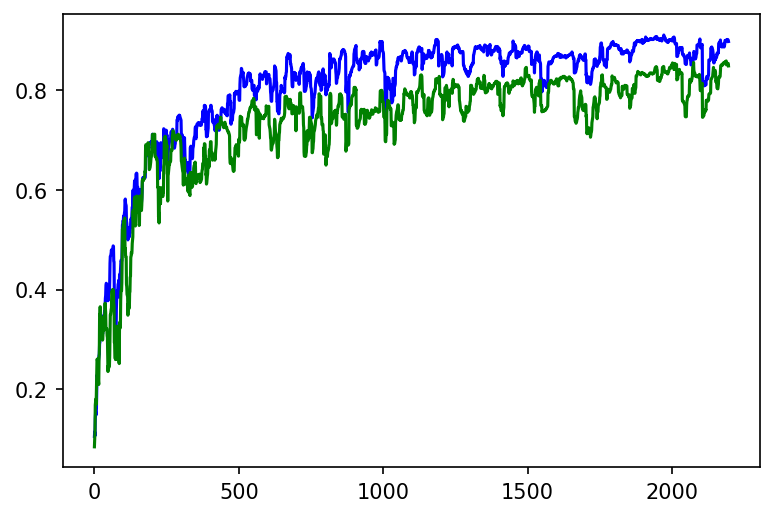

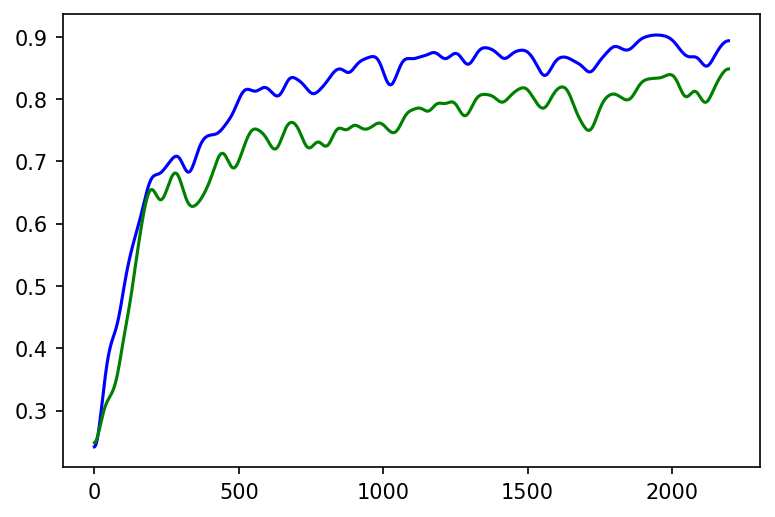

In [77]:
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  399872 dropped 0 real parameters 399872 drop definition []


Err 117.646 Acc  0.930: 100%|██████████| 100000/100000 [2:57:01<00:00,  9.41it/s] 


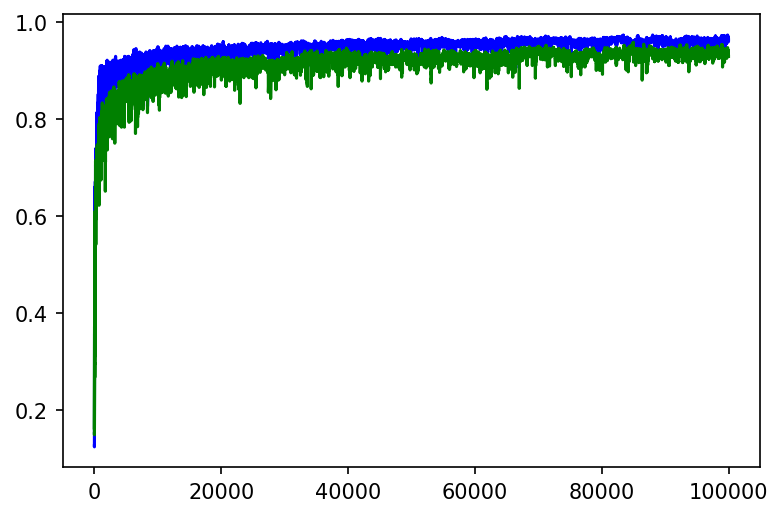

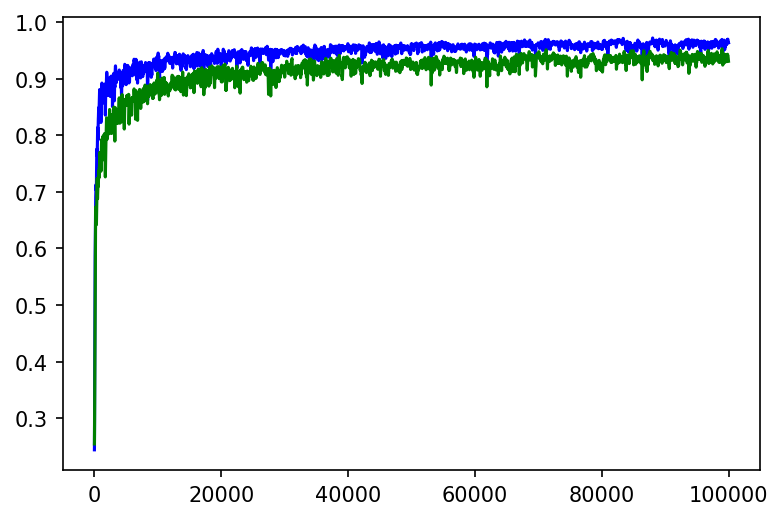

In [88]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 256
two_hidden_layers = 3 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.003
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 1000
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 100000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 1:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 1:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 1:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 1:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    err = np.sum(NN2.error**2)
    ttt.set_description("Err %6.3f Acc %6.3f" % (err, acc_test), refresh=False)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', err / len(NN2.error))
    if verbose > 0:
        print("%4d      %6d        %7.3f               %7.3f" % (i_shot + 1, epoch, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


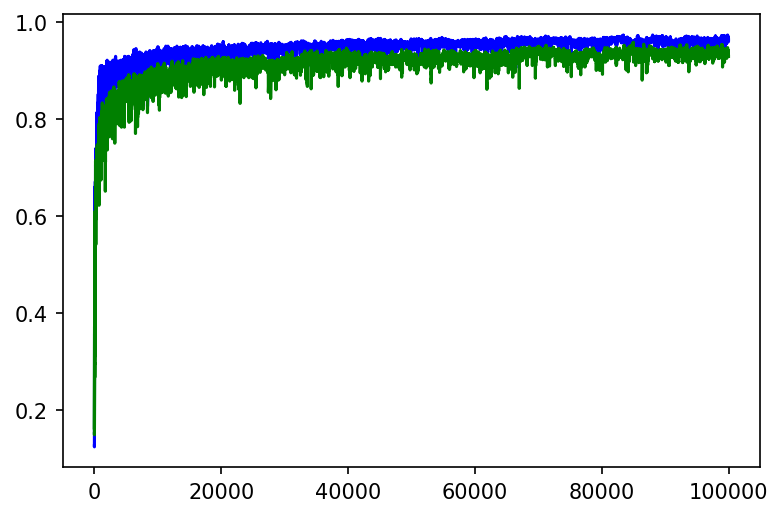

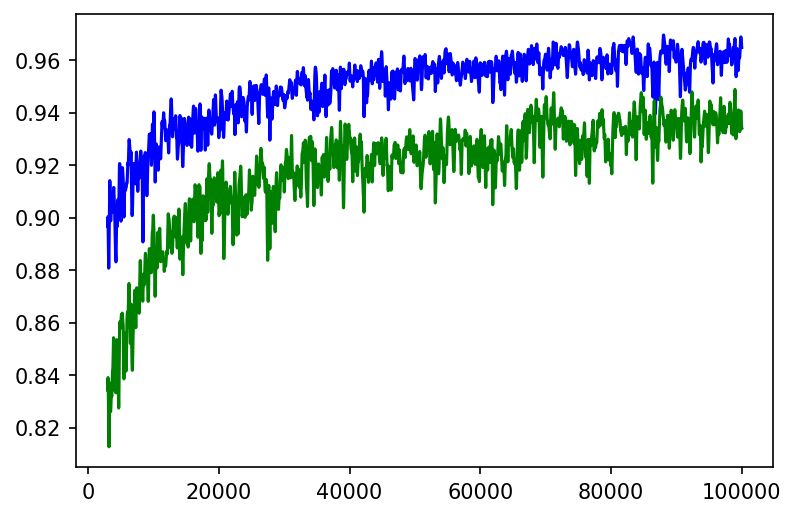

In [91]:
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=50)
y2s = gaussian_filter1d(y2, sigma=50)
pyplot.plot(shot[3000:],y1s[3000:],'b')
pyplot.plot(shot[3000:],y2s[3000:],'g')
pyplot.show()


In [92]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 128
two_hidden_layers = 3 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.001
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 2000
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 100000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 1:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 1:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 1:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 1:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    err = np.sum(NN2.error**2)
    ttt.set_description("Err %6.3f Acc %6.3f" % (err, acc_test), refresh=False)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', err / len(NN2.error))
    if verbose > 0:
        print("%4d      %6d        %7.3f               %7.3f" % (i_shot + 1, epoch, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  150784 dropped 0 real parameters 150784 drop definition []


Err 118.776 Acc  0.933:  75%|███████▍  | 74541/100000 [7:49:22<2:40:18,  2.65it/s] 


KeyboardInterrupt: 

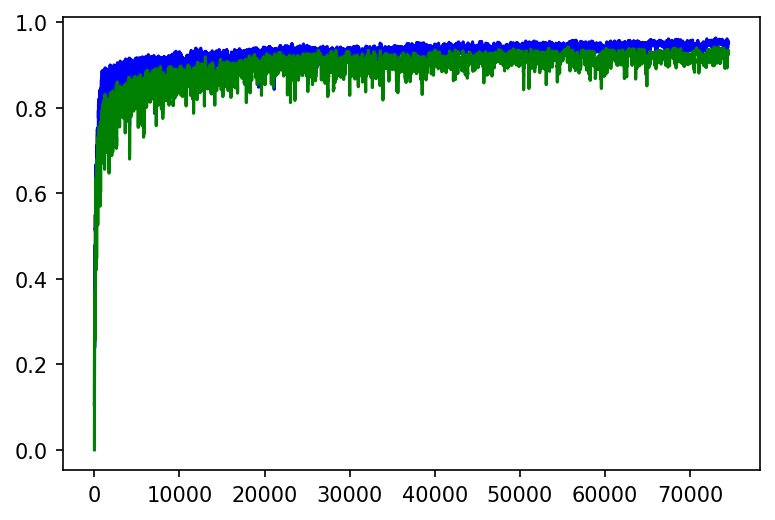

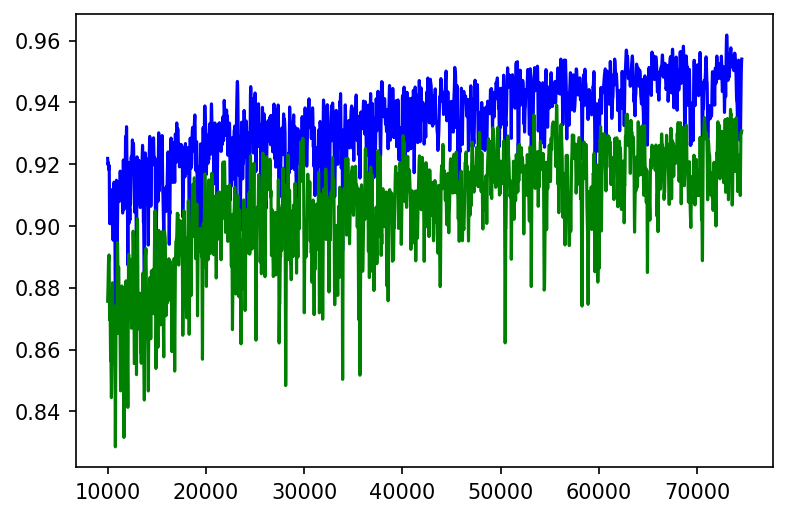

In [94]:
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot[10000:],y1s[10000:],'b')
pyplot.plot(shot[10000:],y2s[10000:],'g')
pyplot.show()


In [102]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 128
two_hidden_layers = 3 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.0001
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 20
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 100
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 100000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

pos_1 = 0
(inputs, outputs, bbs) = run_load_mnist(use_test = False)
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True, only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 1:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 1:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 1:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 1:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    err = np.sum(NN2.error**2)
    ttt.set_description("Err %6.3f Acc %6.3f" % (err, acc_test), refresh=False)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', err / len(NN2.error))
    if verbose > 0:
        print("%4d      %6d        %7.3f               %7.3f" % (i_shot + 1, epoch, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


Err 122.180 Acc  0.928:  21%|██▏       | 21338/100000 [04:50<17:50, 73.46it/s]


KeyboardInterrupt: 

In [125]:
lr = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.5 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)
do_drop_weights = [] # [0.9, 0.9, 0.9, 0.9]
two_hidden_layers = 2
change_first_layers_slow_learning = [0.125, 0.25, 0.5] # [0, 0.1]
NN2 = setup_net()
NN2.set_input(inputs, outputs, batch_size=1000)
NN2.train(10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Network parameters:  134400 dropped 0 real parameters 134400 drop definition []


Err  0.017: 100%|██████████| 10000/10000 [19:18<00:00,  8.63it/s]


0.976


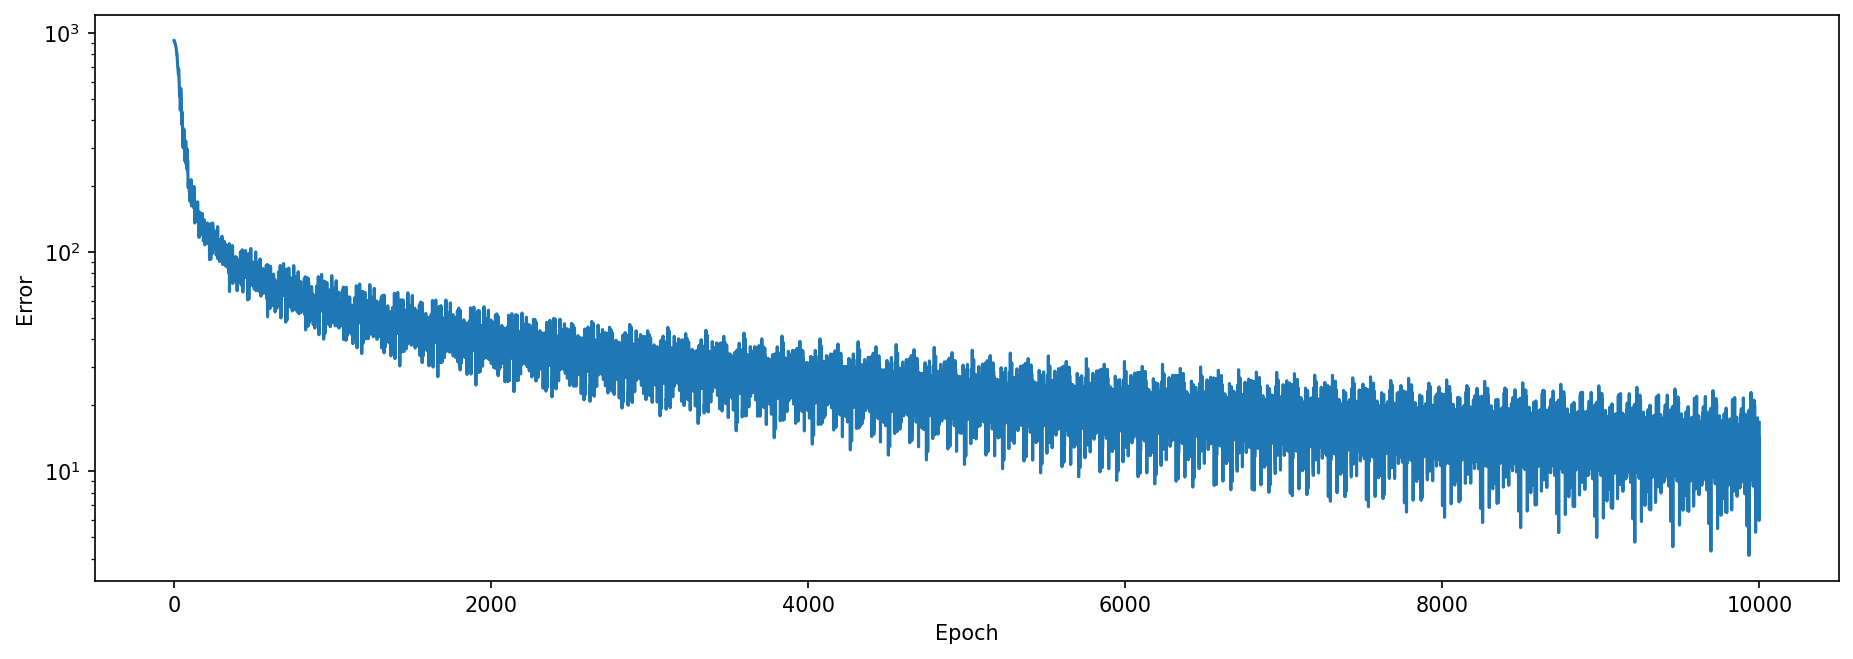

In [126]:
NN2.set_input(inputs_test, outputs_test, batch_size=1000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)
NN2.plot_train_history()

In [145]:
lr = 0.3
hidden_size = 64
init_rand_ampl = 0.5
init_rand_ampl0 = 0.1 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)
do_drop_weights = [] # [0.9, 0.9, 0.9, 0.9]
use_bias = False
two_hidden_layers = 2
change_first_layers_slow_learning = [0.125, 0.25, 0.5] # [0, 0.1]
NN2 = setup_net()
NN2.set_input(inputs, outputs, batch_size=1000)
NN2.train(10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Network parameters:  59008 dropped 0 real parameters 59008 drop definition []


Err  0.029: 100%|██████████| 10000/10000 [08:36<00:00, 19.38it/s]


0.977


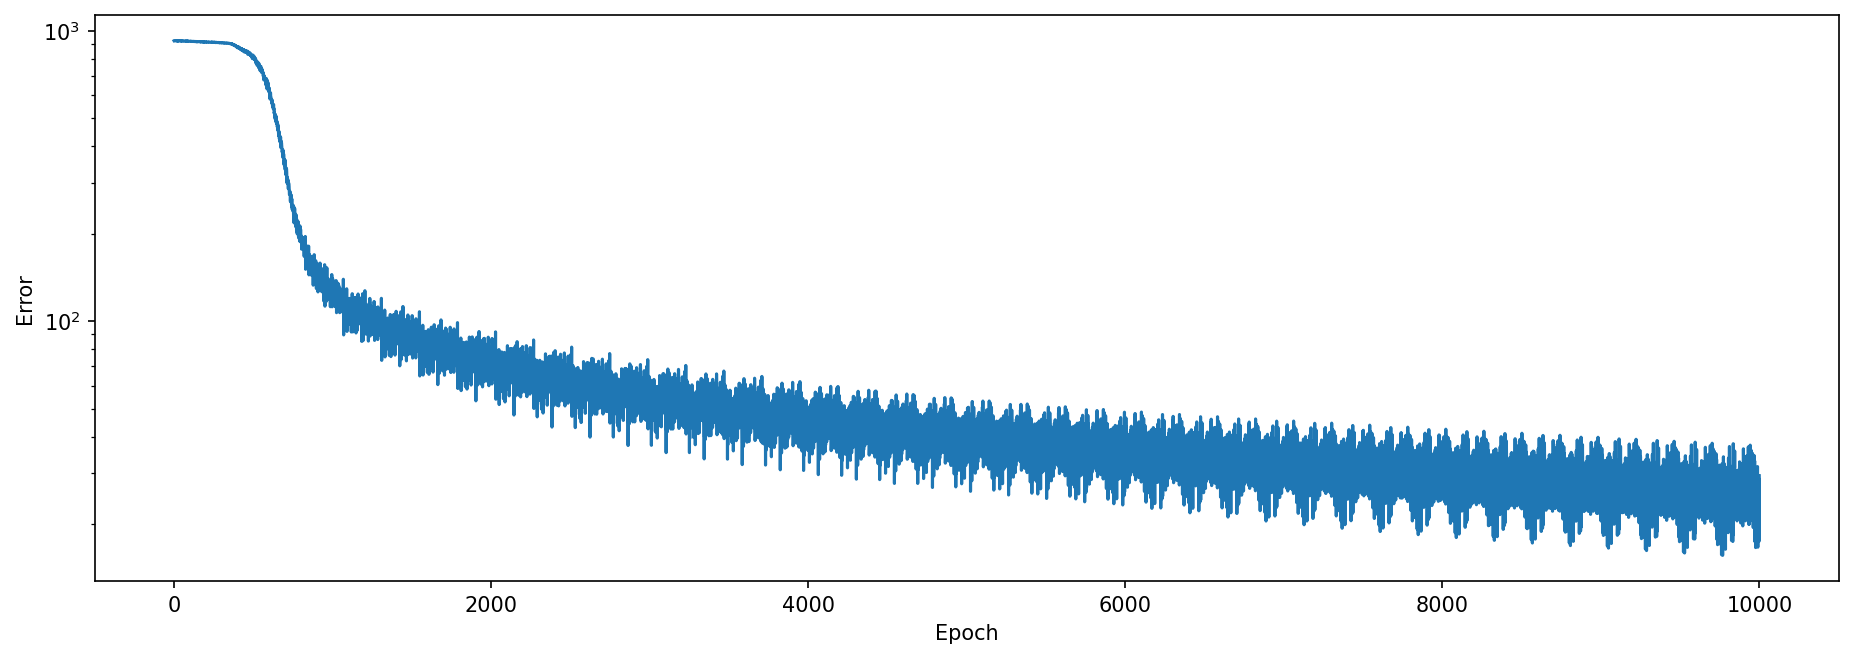

In [146]:
NN2.set_input(inputs_test, outputs_test, batch_size=1000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)
NN2.plot_train_history()

In [147]:
NN2.set_input(inputs, outputs, batch_size=1000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)

0.989


In [148]:
lr = 0.3
hidden_size = 64
init_rand_ampl = 0.5
init_rand_ampl0 = 0.1 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)
do_drop_weights = [] # [0.9, 0.9, 0.9, 0.9]
use_bias = False
two_hidden_layers = 2
change_first_layers_slow_learning = [0.125, 0.25, 0.5] # [0, 0.1]
NN2 = setup_net()
NN2.set_input(inputs, outputs, batch_size=1000)
NN2.train(100000)
NN2.set_input(inputs_test, outputs_test, batch_size=1000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)
NN2.plot_train_history()

  0%|          | 0/100000 [00:00<?, ?it/s]

Network parameters:  59008 dropped 0 real parameters 59008 drop definition []


Err  0.013:  30%|██▉       | 29667/100000 [25:10<59:42, 19.63it/s]  


KeyboardInterrupt: 

0.985


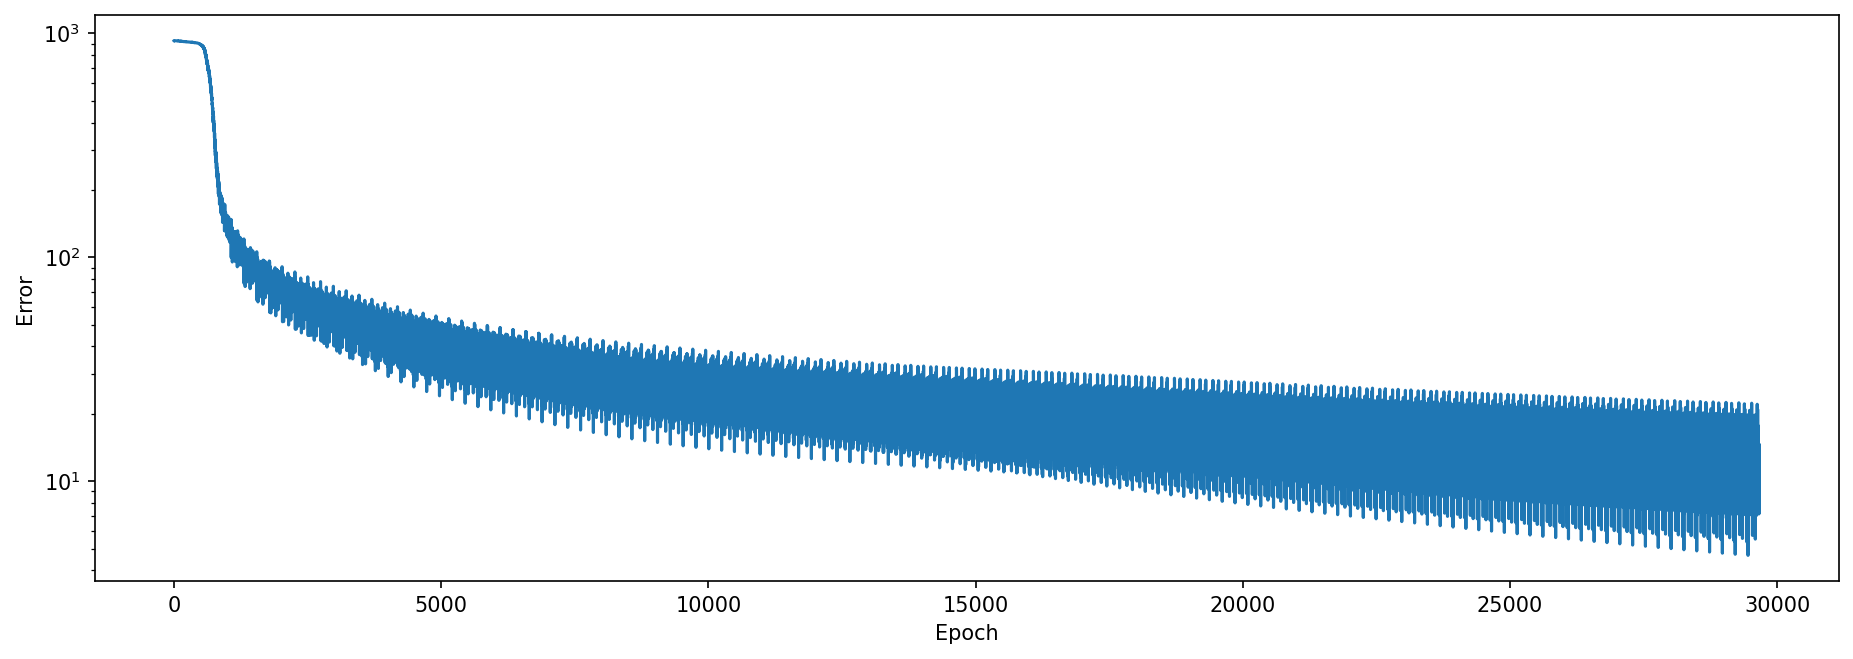

In [152]:
NN2.set_input(inputs_test, outputs_test, batch_size=4000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)
NN2.plot_train_history()

In [153]:
lr = 0.3
hidden_size = 64
init_rand_ampl = 0.5
init_rand_ampl0 = 0.1 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)
do_drop_weights = [] # [0.9, 0.9, 0.9, 0.9]
use_bias = False
two_hidden_layers = 2
change_first_layers_slow_learning = [0.125, 0.25, 0.5] # [0, 0.1]
NN2 = setup_net()
NN2.set_input(inputs, outputs, batch_size=1000)
NN2.train(200000)
NN2.set_input(inputs_test, outputs_test, batch_size=4000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)
NN2.plot_train_history()

  0%|          | 0/200000 [00:00<?, ?it/s]

Network parameters:  59008 dropped 0 real parameters 59008 drop definition []


Err  0.000:  97%|█████████▋| 193656/200000 [2:43:35<05:21, 19.73it/s]  


KeyboardInterrupt: 

0.98525


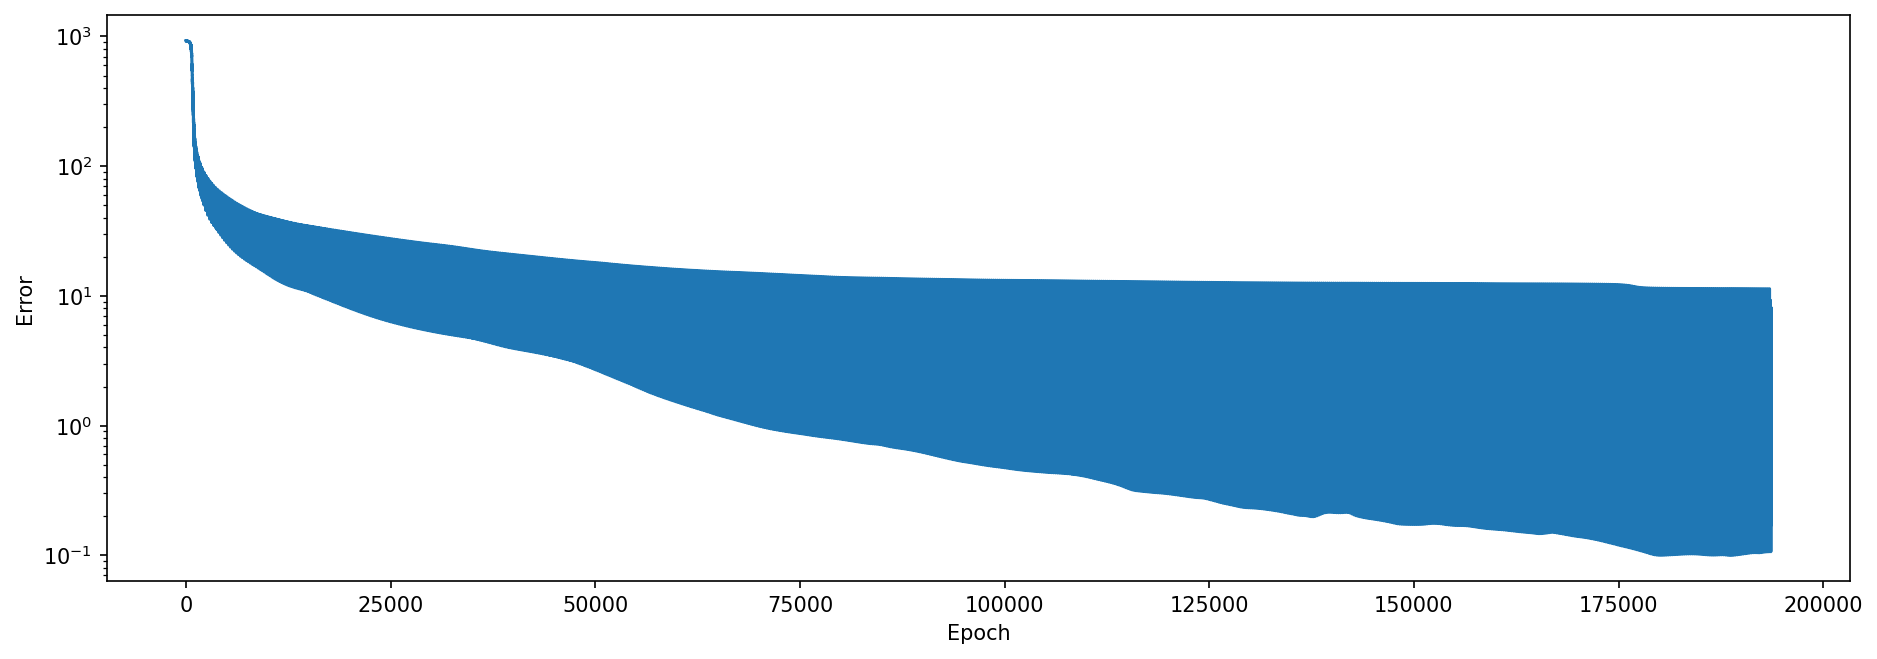

In [154]:
NN2.set_input(inputs_test, outputs_test, batch_size=4000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)
NN2.plot_train_history()

# Test with few shot algorithm for usual training. 
hidden_size 64 (test accuracy is not done with all labels, the last two were not in the test. This did not change the result, as checked in the cell after the tests)

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  59008 dropped 0 real parameters 59008 drop definition []


Err 78.318 Acc  0.955: 100%|██████████| 100000/100000 [3:19:14<00:00,  8.37it/s]  


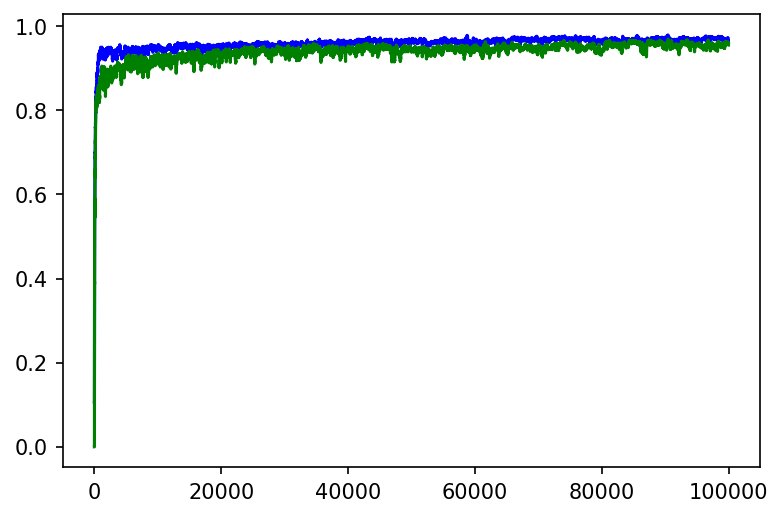

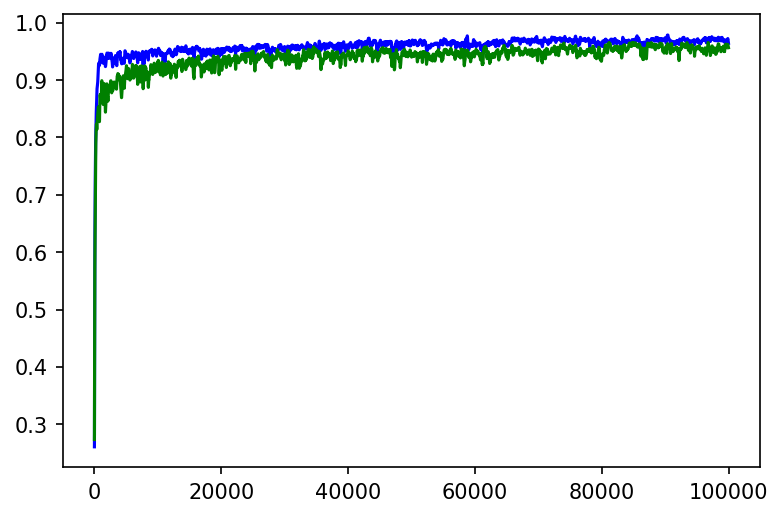

In [157]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = 2 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.01
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.1 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 2000
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 100
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 100000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.125, 0.25, 0.5] # [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 1:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 1:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 1:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 1:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    err = np.sum(NN2.error**2)
    ttt.set_description("Err %6.3f Acc %6.3f" % (err, acc_test), refresh=False)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', err / len(NN2.error))
    if verbose > 0:
        print("%4d      %6d        %7.3f               %7.3f" % (i_shot + 1, epoch, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


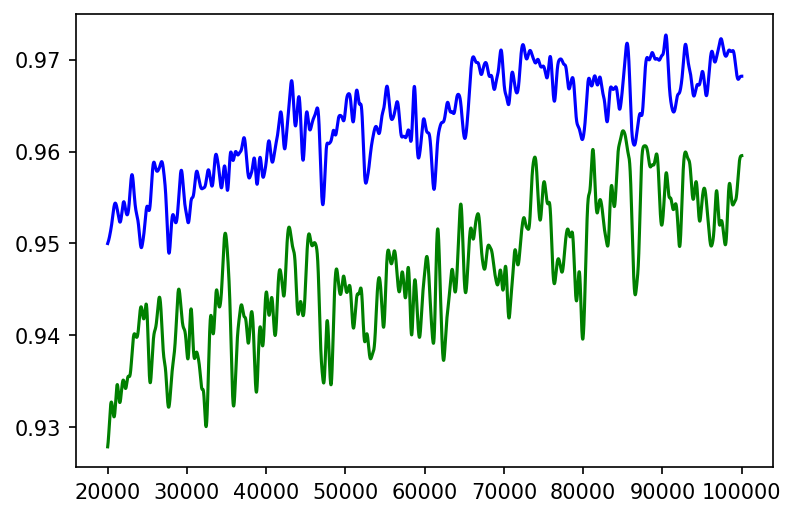

In [159]:
from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=200)
y2s = gaussian_filter1d(y2, sigma=200)
pyplot.plot(shot[20000:],y1s[20000:],'b')
pyplot.plot(shot[20000:],y2s[20000:],'g')
pyplot.show()


In [172]:
import numpy as np
with open("pickled_NN2_pretraining_23082020_with_few_shot_algoritm.pkl", "br") as fh:
     NN2 = pickle.load(fh)
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
NN2.set_input(inputs_test, outputs_test, batch_size=4000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels, only_load_num=few_shot_fast_load_num)
NN2.set_input(inputs_test, outputs_test, batch_size=4000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)

0.961
0.96


In [160]:
            with open("pickled_NN2_pretraining_23082020_with_few_shot_algoritm.pkl", "bw") as fh:
                pickle.dump(NN2, fh)


In [173]:
import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
(inputs, outputs, bbs) = run_load_mnist(use_test = False)
lr = 0.1
NN2 = setup_net()
NN2.set_input(inputs, outputs, batch_size=1000)
NN2.train(40000)
NN2.set_input(inputs_test, outputs_test, batch_size=4000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels, only_load_num=few_shot_fast_load_num)
NN2.set_input(inputs_test, outputs_test, batch_size=4000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)

  0%|          | 0/40000 [00:00<?, ?it/s]

Network parameters:  59008 dropped 0 real parameters 59008 drop definition []


Err  0.024: 100%|██████████| 40000/40000 [33:57<00:00, 19.64it/s]


KeyError: <class 'numpy.object_'>

In [174]:
NN2.set_input(inputs, outputs, batch_size=4000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels, only_load_num=few_shot_fast_load_num)
NN2.set_input(inputs_test, outputs_test, batch_size=4000)
NN2.forward()
acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
print(acc_test)

0.98925
0.982


The test shows, that usual training is better than training with pre-train procedure.

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  59008 dropped 0 real parameters 59008 drop definition []
loaded mnist Train dataset  with 10 labels [0, 1, 9, 3, 4, 5, 6, 7]


  0%|          | 0/100000 [00:00<?, ?it/s]

loaded mnist Test dataset  with 10 labels [0, 1, 9, 3, 4, 5, 6, 7]


Err 56.632 Acc  0.967: 100%|██████████| 100000/100000 [34:37<00:00, 48.14it/s] 


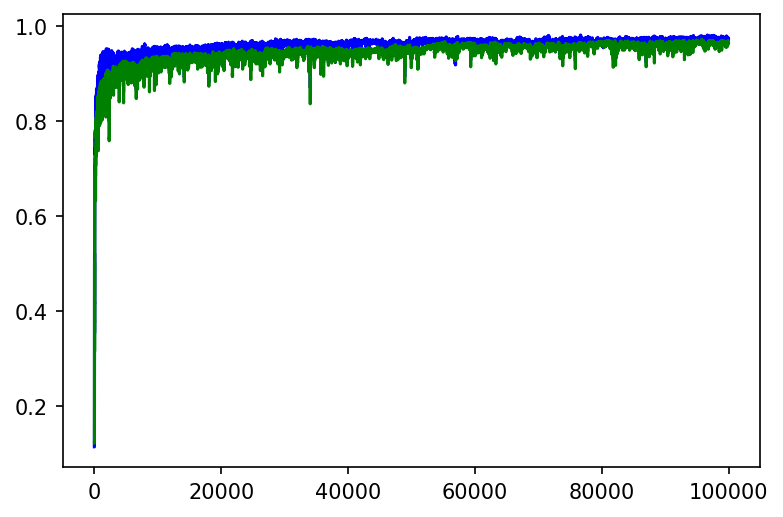

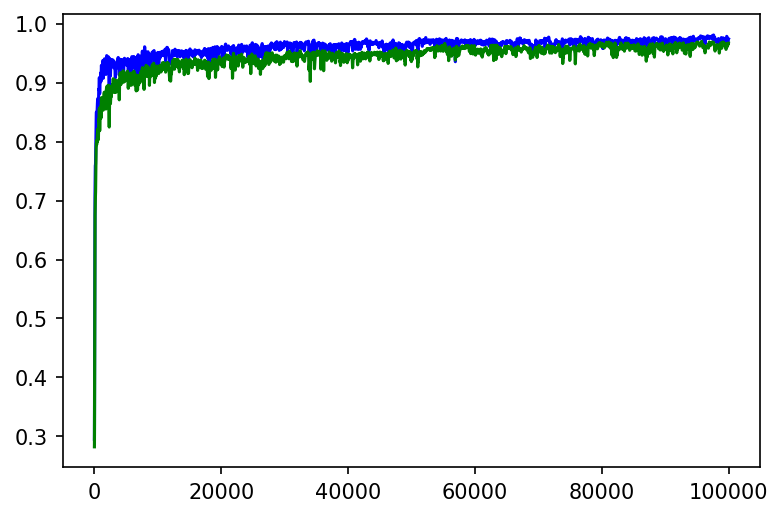

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = 2 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.01
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.1 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 2000
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 10
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 100000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.125, 0.25, 0.5] # [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
inputs = None
outputs = None
bbs = None
verbose = 1
(inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2])
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
verbose = 0
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 1:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 1:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 1:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 1:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    err = np.sum(NN2.error**2)
    ttt.set_description("Err %6.3f Acc %6.3f" % (err, acc_test), refresh=False)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', err / len(NN2.error))
    if verbose > 0:
        print("%4d      %6d        %7.3f               %7.3f" % (i_shot + 1, epoch, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot,y1s,'b')
pyplot.plot(shot,y2s,'g')
pyplot.show()


In [3]:
NN2.set_input(inputs, outputs, batch_size=1000)
NN2.forward()
if num_outputs == 1:
    print('new  ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
else:
    print('new  ', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

# now try a few shot learning for some steps
# load with labels [8,9] and train every to a measure
#
# criteria label correct: (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0] true
# distance to second largest label
# biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
# ratio = biggest_two[-1] / [-2] > threshold

# max_iter is the maximal number of try's to optimize one data point in few_shot
pos_1 = 0
pos_2 = 0
try:
    print('few shot accuracy results')
    print('shot     try       old labels            new labels  new labels (forced)              over all')
    for i_shot in range(try_mnist_few_shot): # some shots
        if change_first_layers_slow_learning is not None:
            for l in range(len(change_first_layers_slow_learning)):
                before = NN2.layers[l].slow_learning
                NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
                if verbose > 0:
                    print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
        before = lr
        lr = lr_few_shot
        if verbose > 0:
            print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
        (inputs, outputs, bbs) = run_load_mnist(use_test = False)
        few1 = all_labels[-2]
        few2 = all_labels[-1]
        ok1 = False
        while not ok1:
            while outputs[pos_1].argmax() != few1:
                pos_1 += 1
            inp_1 = inputs[pos_1:pos_1+few_shot_more_at_once]
            outp_1 = outputs[pos_1:pos_1+few_shot_more_at_once]
            pos_1 += few_shot_more_at_once # prepare the next shot
            ok1 = True
            if check_wrong:
                for ii in range(1, few_shot_more_at_once):
                    if outp_1[ii].argmax() == few2:
                        ok1 = False
        ok2 = False
        while not ok2:
            while outputs[pos_2].argmax() != few2:
                pos_2 += 1
            inp_2 = inputs[pos_2:pos_2+few_shot_more_at_once]
            outp_2 = outputs[pos_2:pos_2+few_shot_more_at_once]
            pos_2 += few_shot_more_at_once
            ok2 = True
            if check_wrong:
                for ii in range(1, few_shot_more_at_once):
                    if outp_2[ii].argmax() == few1:
                        ok1 = False
        for m in range(use_every_shot_n_times):
            for (inp,outp) in [(inp_1,outp_1), (inp_2,outp_2)]:
                if verbose > 0:
                    print('start training', outp)
                epoch = 0
                NN2.set_input(inp, outp)
                while epoch < few_shot_max_try:
                    NN2.forward()
                    NN2.backward()
                    # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
                    if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0]:
                        biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
                        if do_pm:
                            ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
                        else:
                            ratio = biggest_two[-1] / biggest_two[-2]
                        if verbose > 0:
                            print(biggest_two, ratio)
                        if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                            break
            if verbose > 0:
                print('Results after few shot', i_shot + 1, 'used the ', m + 1, '. time')
                (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
            (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
            NN2.set_input(inputs, outputs, batch_size=1000)
            NN2.forward()
            acc_only_old_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
            (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
            NN2.set_input(inputs, outputs, batch_size=1000)
            NN2.forward()
            acc_only_new_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

            # here only the few_shot trained lables are considdered
            res_values = NN2.layers[-1].values
            mask = [0] * len(all_labels)
            for l in all_labels[-2:]:
                mask[l] = 1
            mask = np_array([mask])
            res_values = res_values * mask
            # deb = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum())
            acc_only_new_labels_forced = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('using only the few shot trained labels for possible output of neural net')
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(res_values.argmax(axis = 1) == few1), 'few2:', np.sum(res_values.argmax(axis = 1) == few2), 'correct', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))



            (inputs, outputs, bbs) = run_load_mnist(use_test = True, only_load_num=few_shot_fast_load_num)
            NN2.set_input(inputs, outputs, batch_size=1000)
            NN2.forward()
            acc_only_overall_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
            print("%4d    %3d           %7.3f               %7.3f              %7.3f               %7.3f" % (i_shot + 1, m + 1, acc_only_old_labels, acc_only_new_labels, acc_only_new_labels_forced, acc_only_overall_labels))
except KeyboardInterrupt:
    print('Interrupted')


new   192000 batch_size 1000 correct 974.0 of 1000 Ratio 0.974 Error 0.043773129144944196
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.836                 0.479                0.768                 0.756
   2      1             0.904                 0.468                0.730                 0.821
   3      1             0.825                 0.572                0.752                 0.775
   4      1             0.842                 0.681                0.844                 0.803
   5      1             0.892                 0.597                0.786                 0.831
   6      1             0.898                 0.666                0.867                 0.848
   7      1             0.911                 0.689                0.895                 0.859
   8      1             0.925                 0.577                0.766                 0.854
   9      1             0.926